# SETTING UP ENVIRONMENT

1) <b>fork github</b> (add on github and use git pull):

*git clone git@github.com:flurinh/mt.git*

2) <b>create conda environment</b>

*conda env create -f requirement.yml*

*conda activate gpcr*

3) <b>create (missing) folders</b>

unzip file

4) <b>check if everything works</b> (import)

In [3]:
from processing.utils import *
from processing.utils2 import *
from processing.utils3 import *
from processing.gpcrdb_soup import *
from processing.download import *
from processing.processor import *
from processing.df_to_cif import *
from analysis.analysis import *

# DATA PROCESSING

The data (and file structure) is provided in a zipfile, so you do not have to download and process everything.
This walkthrough shows how to (theoretically) build from scratch and/or update your outdated data.

## DOWNLOADING / UPDATING METADATA

With metadata we primarily refer to the [gpcrdb](https://gpcrdb.org) [GPCR structure table](https://gpcrdb.org/structure/) containing a curated list of gpcrs (their name, uniprot id etc) - new entries in this list may automatically be updated!

In our code we use a dedicated downloading class which handles both the <b>table download</b> and the <b>cif file download</b> of all missing structures. The table is saved to the subdirectory "*data/gpcrdb/*", the cif (or pdb) files are put into *data/mmcif/*.

In [10]:
D = Download(fileformat='cif')
D.download_table(reload=True)  # without reload-flag set to True (i.e. file exists) we do not re-download
# since these are unprocessed files, existing files are NOT RE-DOWNLOADED
# however we "reference" the gpcrdb gpcr structure table to see if we have missing structures, and download those
D.download_pdbs()

  0%|                                                                                                                              | 0/1 [00:00<?, ?it/s]

writing gpcrdb table to file: data/data_table.pkl
Reloading pdb files...
Missing pdbs: ['1F88']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


## DOWNLOADING MORE (META)DATA

Next we initialize our processing class, creatively named ***CifProcessor***, which includes all the functions used to gather more metainformation; Such as download data from **sifts mapping** (aka the mapping of the sequence of the pdb structure against the related uniprot gene sequence), the **(generic residue) numbering** from gpcrdb, as well as does the calculation of consecutive **psi-** and **phi-angles** and **assigns the generic residue numbers** for both the gpcr or (in complexes) the gprotein. (This of course includes alignment functions and many more). Last and not least the common data format in this processor class, as we will see, are python **DataFrames**.

Let's start slow by initializing the processor:

In [11]:
p = CifProcessor()

Next we load 3 datatables (referred to as metainfo): sifts mapping ('p.mappings'), table with uniprot ids and corresponding generic residue numbers ('p.numbering') and our previously downloaded data structure table ('p.table'). 

In [12]:
p.read_pkl_metainfo()

In [13]:
p.mappings.head(3)

,identifier,name,mappings,PDB,uniprot
0,D9IEF7_BPT4,D9IEF7_BPT4,"{'entity_id': 1, 'chain_id': 'A', 'start': {'a...",6LUQ,D9IEF7
1,DRD2_HUMAN,DRD2_HUMAN,"{'entity_id': 1, 'chain_id': 'A', 'start': {'a...",6LUQ,P14416
2,DRD2_HUMAN,DRD2_HUMAN,"{'entity_id': 1, 'chain_id': 'A', 'start': {'a...",6LUQ,P14416


In [14]:
p.numbering.head(3)

,PDB,identifier,family,numbering
0,6LUQ,drd2_human,001_001_004_002,"[{'sequence_number': 1, 'amino_acid': 'M', 'pr..."
1,5L7D,smo_human,006_001_001_011,"[{'sequence_number': 1, 'amino_acid': 'M', 'pr..."
2,5TUD,5ht2b_human,001_001_001_007,"[{'sequence_number': 1, 'amino_acid': 'M', 'pr..."


In [15]:
p.table.head(3)

,uniprot(gene),receptor family,Cl.,Species,Method,PDB,Resolution,Preferred Chain,State,Degree active %,Family,Subtype,Function
0,STE2,STE2,D1(Ste2-likefungalpheromone),strainATCC204508/S288c,cryo-EM,7AD3,3.5,A,Active,-,GPa1family,αPa1,Agonist
1,OPRM,Opioid,A(Rhodopsin),Mouse,X-ray,4DKL,2.8,A,Inactive,7,-,-,Antagonist
2,OXYR,Vasopressinandoxytocin,A(Rhodopsin),Human,X-ray,6TPK,3.2,A,Inactive,24,-,-,Antagonist


This next step takes a very long time (**~30 minutes**), depending on if we make calls to download generic residue numbers (for uniprot ids) from [gpcrdb](https://docs.gpcrdb.org/web_services.html). (Of course if you have new samples, setting *reload_numbering* to *False* will still mean you are going to update your data to include it.) If you have an existing table, **NOT RELOADING IS ADVISED**!

In [16]:
p.make_metainfo(reload_numbering=False, reload_mapping=False, overwrite=True)

557it [00:00, 4972.24it/s]


## CREATING RAW DATAFRAMES

To start processing files from scratch you may run this next line, it will **DELETE** all pickle files (*.pkl*, the format of the dataframes) in your specified folder:

*p.del_pkl(folder='data/raw/')*

So far we only have a folder with unprocessed cif files - data is in text format. Very slow to process etc, so we first create the base structure of our dataset: a list of dataframes, **one dataframe per structure**. (During the loading process we also calculate the psi, phi and omega angles for all residues in the structure.) These are then saved (without any further processing to the subdirectory *data/raw/*.

In [30]:
p.make_raws(overwrite=False)

557it [00:00, 29309.45it/s]


Setting overwrite to False will skip all processed samples! If it is set to True, you process all your samples and overwrite the existing data.

# GENERIC RESIDUE NUMBERS

As mentioned, the dataformat we use (after loading the cif files) are DataFrames (implements a variety of SQL methods and provides easy pythonic access to big datatables). Now each of our structures corresponds to a single DataFrame in the main data container in our processor class: p.dfl (dataframe list), for easier access and search it is paired with a list containing only the respective pdb name, p.dfl_list.

In [33]:
p.dfl

[]

What happened? Well currently we have no new structures (since a few days ago when I last updated the data), thus no new structures were processed and added to the data list. To load our data:

In [4]:
p.read_pkl(mode='', folder='data/raw/')

Reading files without generic numbers...


Let's have a look at the first entry:

In [38]:
p.dfl[10].head(3)

,PDB,group_PDB,auth_asym_id,label_asym_id,label_seq_id,auth_seq_id,label_comp_id,id,label_atom_id,type_symbol,Cartn_x,Cartn_y,Cartn_z,phi,omega,psi,identifier,label_comp_sid
0,2J4Y,ATOM,A,A,2,1,MET,4,N,N,-32.043,16.427,-13.796,-144.390068,179.597085,-176.94101,OPSD_BOVIN,M
1,2J4Y,ATOM,A,A,2,1,MET,5,CA,C,-31.142,16.987,-12.785,-144.390068,179.597085,-176.94101,OPSD_BOVIN,M
2,2J4Y,ATOM,A,A,2,1,MET,6,C,C,-29.663,16.868,-13.200,-144.390068,179.597085,-176.94101,OPSD_BOVIN,M


In [39]:
p.dfl_list[10]

'2J4Y'

In [7]:
p.table

,uniprot(gene),receptor family,Cl.,Species,Method,PDB,Resolution,Preferred Chain,State,Degree active %,Family,Subtype,Function
0,STE2,STE2,D1(Ste2-likefungalpheromone),strainATCC204508/S288c,cryo-EM,7AD3,3.5,A,Active,-,GPa1family,αPa1,Agonist
1,OPRM,Opioid,A(Rhodopsin),Mouse,X-ray,4DKL,2.8,A,Inactive,7,-,-,Antagonist
2,OXYR,Vasopressinandoxytocin,A(Rhodopsin),Human,X-ray,6TPK,3.2,A,Inactive,24,-,-,Antagonist
3,CCR2,Chemokine,A(Rhodopsin),Human,X-ray,5T1A,2.8,A,Inactive,30,-,-,AllostericantagonistAntagonist
4,CNR2,Cannabinoid,A(Rhodopsin),Human,X-ray,5ZTY,2.8,A,Inactive,6,-,-,Antagonist
...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,NPY2R,NeuropeptideY,A(Rhodopsin),Human,X-ray,7DDZ,2.8,A,Inactive,1,-,-,Antagonist
553,NTR1,Neurotensin,A(Rhodopsin),Rat,cryo-EM,7L0P,4.1,C,Active,100,Gi/o,αi1,Agonist
554,ADA2C,Adrenoceptors,A(Rhodopsin),Human,X-ray,6KUW,2.8,A,Inactive,1,-,-,Antagonist
555,NTR1,Neurotensin,A(Rhodopsin),Rat,cryo-EM,7L0Q,4.3,C,Active,100,Gi/o,αi1,Agonist


## FILTERING, REDUCED TABLES AND PDB LISTS

Creating filters is easy with the processor and can primarily be done in two ways. The first is by applying the class function *p.make_filter()*:

In [5]:
f_act = p.make_filter(State='Active')

The implemented filter options (such as filtering by states etc) with examples in brackets are:
- Species  (Human, Bovine)
- State  (Active, Inactive, Intermediate)
- Cl  (Rhodopsin, A, ...)
- Family  (Gi/o, Gs, ...)
- Subtype  (αi1, ...)
- Resolution  (<=3.5)
- Function  (Agonist, Antagonist)
- gprotein  (filters out all complexes where not both Family and Subtype are within a predifined set of regular gproteins)
- pdb_ids  (eg. \['7AD3', '4DKL'\] -> creates a filter only containing the listed pdbs if present in our metainfo table) 

Filters may be "applied", where we effectively remove all data except the ones present in the filter (simultaneously being removed from both *p.dfl* and *p.dfl_list*.

In [ ]:
p.apply_filter(f_act)

The second option and this is what happens behind the scene of the *p.make_filter()* function: **QUERIES** (SQL)

In [8]:
f_act = f_act[f_act['Method']=='cryo-EM']

In [10]:
f_act.head(3)

,uniprot(gene),receptor family,Cl.,Species,Method,PDB,Resolution,Preferred Chain,State,Degree active %,Family,Subtype,Function
0,STE2,STE2,D1(Ste2-likefungalpheromone),strainATCC204508/S288c,cryo-EM,7AD3,3.5,A,Active,-,GPa1family,αPa1,Agonist
6,5HT1B,5-Hydroxytryptamine,A(Rhodopsin),Human,cryo-EM,6G79,3.8,S,Active,100,Gi/o,αo,Agonist
8,PTH1R,Parathyroidhormone,B1(Secretin),Human,cryo-EM,6NBI,4.0,R,Active,100,Gs,αs,Agonist


So filters really are just filtered metainfotables and since they are easily interchangable / by extension also pdb lists. 

## GPCR GENERIC RESIDUE NUMBERS

The tricky thing about assigning generic residue numbers to structures is that many times the residue sequence of the structure is not exactly the same as that of the *correct, corresponding gene*, further a structure may include many different chains, include fused parts, be in a complex with gproteins etc

We got the **generic residue number** from [gpcrdb](https://docs.gpcrdb.org/web_services.html), now we want to allign the uniprot sequence to the structure's sequence - this is why we got the **sifts mapping** (it's a crude alignment where we have pairs of starting and end points of intervals that align of both sequences). Unfortunately the sifts is often not correct - there are often shifts or other miss-alignments withing a given sifts interval, sometimes the sifts interval do not even have equal length... In cases where this happens we do sequence alignment ourselves.

The **DATAFLOW** is as follows:
- p.table contains the "preferred chain" information that tells us which chain in the pdb is the gpcr.
- p.mapping contains the sifts mapping (we check if the interval length is correct).
- We get the uniprot sequence.
- We use SQL to quickly produce new columns in our dataframe - very much like *label_seq_id* (which corresponds to the autogenerated sequence id of each atom (of its residue), but instead gives the position (if said atom/residue is present in the gene) within the uniprot sequence...
- .. as well as the corresponding uniprot residue name.
- We check, if there are (too) many non-matching residues of the alignment between structure and uniprot sequence and..
- .. should there be too many too many non-matching residues, we, instead of using the sifts data to align structure to uniprot, do a sequence alignment.
- Lastly, given the uniprot sequence number we can look up the generic residue numbers in p.numbering

In [11]:
p.allow_exception=False  # default

If set to True, this flag makes the processor skip any structures that throw errors, may be useful if you have "dirty data", but don't want to go through the pain of sorting out anything that won't get processed.

To start from scratch let's delete the processor (and all data loaded into memory) ... 

In [12]:
del p

... and reinitialize it, quickly, in 3 lines:

In [ ]:
p = CifProcessor()
p.read_pkl_metainfo()
p.read_pkl(mode='', folder='data/raw/')

Before (finally) running the generic residue assignment a quick explanation of the function inputs:
- f: filter, this is a dataframe gained from filtering the p.table
- pdb_ids: a list of pdbs to process (optional; an empty list means we use the filter)
- overwrite: if set to True, after processing all structures get saved (overwriting existing files)
- folder: location where the processed files get stored

You need to provide a filter-like input, so the processor knows which data it should assign generic residue numbers to. Imagine loading all the data from the raw folder and being interested in *Class A (Rhodopsin)* of *humans* structures only... Notably, providing a list of ***pdb_ids*** **overwrites whatever** ***filter*** you give it. If you want **NO FILTER** (i.e. process all your raw structures) just use ***f=p.table*** (not applying any filter at all).

In [43]:
p.assign_generic_numbers_r(f=p.table, pdb_ids=[], overwrite=True, folder='data/processed/')

  0%|                                                                                                                            | 0/557 [00:00<?, ?it/s]


5K2A P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5K2A P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

  0%|▏                                                                                                                   | 1/557 [00:00<08:33,  1.08it/s]


intervals : []
Error Status: False
assigned dfl[167] generic residue numbers for the receptor...

6KUY P08913
Found error!
6KUY: Using uniprot (looking up P08913) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADA2A_HUMAN
start pdb: 1
start uni: 35

6KUY P08913
Found error!
6KUY: Using uniprot (looking up P08913) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADA2A_HUMAN
start pdb: 274
start uni: 335

6KUY P08913
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

  0%|▍                                                                                                                   | 2/557 [00:02<10:54,  1.18s/it]


intervals : []
Error Status: False
assigned dfl[336] generic residue numbers for the receptor...

6M1H P41586
Found error!
6M1H: Using uniprot (looking up P41586) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for PACR_HUMAN
start pdb: 6
start uni: 23


  1%|▌                                                                                                                   | 3/557 [00:03<11:45,  1.27s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[354] generic residue numbers for the receptor...

6WW2 Q13467
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6WW2 Q13467
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  1%|▊                                                                                                                   | 4/557 [00:05<15:30,  1.68s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[469] generic residue numbers for the receptor...

3OE8 P61073
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3OE8 P61073
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  1%|█                                                                                                                   | 5/557 [00:08<19:45,  2.15s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[46] generic residue numbers for the receptor...

5WF6 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5WF6 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

  1%|█▏                                                                                                                  | 6/557 [00:09<16:06,  1.75s/it]


intervals : []
Error Status: False
assigned dfl[224] generic residue numbers for the receptor...

4RWS P61073
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4RWS P61073
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  1%|█▍                                                                                                                  | 7/557 [00:11<14:14,  1.55s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[117] generic residue numbers for the receptor...

6LPB P41586
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  1%|█▋                                                                                                                  | 8/557 [00:12<15:06,  1.65s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[347] generic residue numbers for the receptor...

4N4W Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  2%|█▊                                                                                                                  | 9/557 [00:13<12:51,  1.41s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[101] generic residue numbers for the receptor...

5VAI G1SGD4
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  2%|██                                                                                                                 | 10/557 [00:15<14:15,  1.56s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[215] generic residue numbers for the receptor...

3AYM P31356
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  2%|██▎                                                                                                                | 11/557 [00:17<13:38,  1.50s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[30] generic residue numbers for the receptor...

4PXF P02699
Trying to assign error free uniprotlabels based on SIFTS!


  2%|██▍                                                                                                                | 12/557 [00:17<11:23,  1.25s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[109] generic residue numbers for the receptor...

5T1A P41597
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5T1A P41597
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  2%|██▋                                                                                                                | 13/557 [00:18<10:45,  1.19s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[195] generic residue numbers for the receptor...

5ZK8 P08172
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5ZK8 P08172
Trying to assign error free uniprotlabels based on SIFTS!


  3%|██▉                                                                                                                | 14/557 [00:19<09:54,  1.10s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[248] generic residue numbers for the receptor...

6KPG P21554
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  3%|███                                                                                                                | 15/557 [00:21<12:43,  1.41s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[332] generic residue numbers for the receptor...

6FJ3 Q03431
Found error!
6FJ3: Using uniprot (looking up Q03431) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for PTH1R_HUMAN
start pdb: 3
start uni: 24

6FJ3 Q03431
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  3%|███▎                                                                                                               | 16/557 [00:23<12:17,  1.36s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[286] generic residue numbers for the receptor...

3OE9 P61073
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3OE9 P61073
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  3%|███▌                                                                                                               | 17/557 [00:24<13:25,  1.49s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[47] generic residue numbers for the receptor...

7DTV P41180
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  3%|███▋                                                                                                               | 18/557 [00:28<19:16,  2.15s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[526] generic residue numbers for the receptor...

6CM4 P14416
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6CM4 P14416
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

  3%|███▉                                                                                                               | 19/557 [00:29<15:54,  1.77s/it]


intervals : []
Error Status: False
assigned dfl[267] generic residue numbers for the receptor...

5UNH P50052
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  4%|████▏                                                                                                              | 20/557 [00:30<14:17,  1.60s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[209] generic residue numbers for the receptor...

7DDZ P49146
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

7DDZ P49146
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  4%|████▎                                                                                                              | 21/557 [00:31<12:46,  1.43s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[519] generic residue numbers for the receptor...

4DAJ P08483
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4DAJ P08483
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  4%|████▌                                                                                                              | 22/557 [00:35<18:43,  2.10s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[79] generic residue numbers for the receptor...

7DHI P07550
Found error!
7DHI: Using uniprot (looking up P07550) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB2_HUMAN
start pdb: 25
start uni: 1


  4%|████▋                                                                                                              | 23/557 [00:36<16:19,  1.83s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[522] generic residue numbers for the receptor...

6PS7 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6PS7 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

  4%|████▉                                                                                                              | 24/557 [00:37<13:55,  1.57s/it]


intervals : []
Error Status: False
assigned dfl[410] generic residue numbers for the receptor...

6O3C P56726
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  4%|█████▏                                                                                                             | 25/557 [00:38<12:59,  1.46s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[379] generic residue numbers for the receptor...

6WHA P28223
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  5%|█████▎                                                                                                             | 26/557 [00:40<13:18,  1.50s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[462] generic residue numbers for the receptor...

3AYN P31356
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  5%|█████▌                                                                                                             | 27/557 [00:41<12:51,  1.45s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[31] generic residue numbers for the receptor...

5TZY O14842
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5TZY O14842
Trying to assign error free uniprotlabels based on SIFTS!


  5%|█████▊                                                                                                             | 28/557 [00:42<11:17,  1.28s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[202] generic residue numbers for the receptor...

4AMI P07700
Found error!
4AMI: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 3
start uni: 33


  5%|█████▉                                                                                                             | 29/557 [00:43<09:59,  1.14s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[71] generic residue numbers for the receptor...

7BW0 Q8TDU6
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  5%|██████▏                                                                                                            | 30/557 [00:45<11:57,  1.36s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[491] generic residue numbers for the receptor...

5GLI P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5GLI P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5GLI P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  6%|██████▍                                                                                                            | 31/557 [00:46<11:39,  1.33s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[159] generic residue numbers for the receptor...

6WJC P11229
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6WJC P11229
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  6%|██████▌                                                                                                            | 32/557 [00:47<11:12,  1.28s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[466] generic residue numbers for the receptor...

6GDG P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  6%|██████▊                                                                                                            | 33/557 [00:49<11:34,  1.33s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[297] generic residue numbers for the receptor...

6WHC P47871
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  6%|███████                                                                                                            | 34/557 [00:51<13:16,  1.52s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[463] generic residue numbers for the receptor...

7KH0 P30518
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  6%|███████▏                                                                                                           | 35/557 [00:53<14:29,  1.67s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[541] generic residue numbers for the receptor...

6VCB P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  6%|███████▍                                                                                                           | 36/557 [00:54<15:05,  1.74s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[452] generic residue numbers for the receptor...

5OLH P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5OLH P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

  7%|███████▋                                                                                                           | 37/557 [00:55<12:55,  1.49s/it]


intervals : []
Error Status: False
assigned dfl[188] generic residue numbers for the receptor...

7LCK P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

  7%|███████▊                                                                                                           | 38/557 [00:56<11:19,  1.31s/it]


intervals : []
Error Status: False
assigned dfl[552] generic residue numbers for the receptor...

5X33 Q9WTK1
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5X33 Q9WTK1
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  7%|████████                                                                                                           | 39/557 [00:58<11:26,  1.32s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[230] generic residue numbers for the receptor...

6ME9 P49286
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6ME9 P49286
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  7%|████████▎                                                                                                          | 40/557 [00:59<12:05,  1.40s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[364] generic residue numbers for the receptor...

4PY0 Q9H244
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4PY0 Q9H244
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

  7%|████████▍                                                                                                          | 41/557 [01:00<10:54,  1.27s/it]


intervals : []
Error Status: False
assigned dfl[111] generic residue numbers for the receptor...

6OYA P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  8%|████████▋                                                                                                          | 42/557 [01:02<11:54,  1.39s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[394] generic residue numbers for the receptor...

4Z34 Q92633
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4Z34 Q92633
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

  8%|████████▉                                                                                                          | 43/557 [01:03<10:39,  1.24s/it]


intervals : []
Error Status: False
assigned dfl[133] generic residue numbers for the receptor...

6KK7 P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6KK7 P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6KK7 P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  8%|█████████                                                                                                          | 44/557 [01:05<12:55,  1.51s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[326] generic residue numbers for the receptor...

6VI4 P41145
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  8%|█████████▎                                                                                                         | 45/557 [01:06<12:08,  1.42s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[453] generic residue numbers for the receptor...

6X18 P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  8%|█████████▍                                                                                                         | 46/557 [01:08<14:12,  1.67s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[472] generic residue numbers for the receptor...

6PS3 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6PS3 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  8%|█████████▋                                                                                                         | 47/557 [01:09<12:36,  1.48s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[406] generic residue numbers for the receptor...

6KPC P34972
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6KPC P34972
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

  9%|█████████▉                                                                                                         | 48/557 [01:11<12:16,  1.45s/it]


intervals : []
Error Status: False
assigned dfl[330] generic residue numbers for the receptor...

4ZUD P30556
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

  9%|██████████                                                                                                         | 49/557 [01:11<10:20,  1.22s/it]


intervals : []
Error Status: False
assigned dfl[139] generic residue numbers for the receptor...

6TOT O43613
Found error!
6TOT: Using uniprot (looking up O43613) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for OX1R_HUMAN
start pdb: 4
start uni: 28


  9%|██████████▎                                                                                                        | 50/557 [01:12<09:20,  1.11s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[431] generic residue numbers for the receptor...

6UUN Q16602
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  9%|██████████▌                                                                                                        | 51/557 [01:14<11:31,  1.37s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[448] generic residue numbers for the receptor...

4Z9G P34998
Found error!
4Z9G: Using uniprot (looking up P34998) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for CRFR1_HUMAN
start pdb: 2
start uni: 104

4Z9G P34998
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


  9%|██████████▋                                                                                                        | 52/557 [01:17<14:05,  1.67s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[136] generic residue numbers for the receptor...

7JOZ P21728
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 10%|██████████▉                                                                                                        | 53/557 [01:18<14:20,  1.71s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[535] generic residue numbers for the receptor...

6XBL Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 10%|███████████▏                                                                                                       | 54/557 [01:21<17:29,  2.09s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[477] generic residue numbers for the receptor...

2HPY P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 10%|███████████▎                                                                                                       | 55/557 [01:23<15:11,  1.82s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[6] generic residue numbers for the receptor...

2YCX P07700
Found error!
2YCX: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 3
start uni: 33


 10%|███████████▌                                                                                                       | 56/557 [01:23<12:37,  1.51s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[23] generic residue numbers for the receptor...

3VG9 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 10%|███████████▊                                                                                                       | 57/557 [01:25<11:45,  1.41s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[64] generic residue numbers for the receptor...

5ZKQ P25105
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5ZKQ P25105
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 10%|███████████▉                                                                                                       | 58/557 [01:26<11:49,  1.42s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[252] generic residue numbers for the receptor...

5XSZ Q08BG4
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5XSZ Q08BG4
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 11%|████████████▏                                                                                                      | 59/557 [01:27<10:47,  1.30s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[239] generic residue numbers for the receptor...

6PS2 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6PS2 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 11%|████████████▍                                                                                                      | 60/557 [01:28<10:10,  1.23s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[405] generic residue numbers for the receptor...

7L0P P20789
Found error!
7L0P: Using uniprot (looking up P20789) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for NTR1_RAT
start pdb: 5
start uni: 50


 11%|████████████▌                                                                                                      | 61/557 [01:29<09:52,  1.19s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[544] generic residue numbers for the receptor...

6Z10 Q6IYF9
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 11%|████████████▊                                                                                                      | 62/557 [01:30<08:47,  1.07s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[480] generic residue numbers for the receptor...

6IGK P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6IGK P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6IGK P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 11%|█████████████                                                                                                      | 63/557 [01:31<09:38,  1.17s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[312] generic residue numbers for the receptor...

5ZK3 P08172
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5ZK3 P08172
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 11%|█████████████▏                                                                                                     | 64/557 [01:32<08:57,  1.09s/it]


intervals : []
Error Status: False
assigned dfl[247] generic residue numbers for the receptor...

7CZ5 Q02643
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 12%|█████████████▍                                                                                                     | 65/557 [01:34<10:34,  1.29s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[513] generic residue numbers for the receptor...

2YDO P29274
Trying to assign error free uniprotlabels based on SIFTS!


 12%|█████████████▋                                                                                                     | 66/557 [01:35<09:47,  1.20s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[26] generic residue numbers for the receptor...

5OLG P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5OLG P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 12%|█████████████▊                                                                                                     | 67/557 [01:36<09:06,  1.12s/it]


intervals : []
Error Status: False
assigned dfl[187] generic residue numbers for the receptor...

4RWA P41143
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 12%|██████████████                                                                                                     | 68/557 [01:37<09:17,  1.14s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[115] generic residue numbers for the receptor...

4Z35 Q92633
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4Z35 Q92633
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 12%|██████████████▏                                                                                                    | 69/557 [01:38<08:42,  1.07s/it]


intervals : []
Error Status: False
assigned dfl[134] generic residue numbers for the receptor...

3RZE P35367
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3RZE P35367
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3RZE P35367
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 13%|██████████████▍                                                                                                    | 70/557 [01:39<09:04,  1.12s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[57] generic residue numbers for the receptor...

6QZH P32248
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 13%|██████████████▋                                                                                                    | 71/557 [01:40<08:53,  1.10s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[417] generic residue numbers for the receptor...

3EML P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3EML P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 13%|██████████████▊                                                                                                    | 72/557 [01:41<08:41,  1.08s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[37] generic residue numbers for the receptor...

5VEW P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5VEW P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5VEW P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5VEW P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 13%|███████████████                                                                                                    | 73/557 [01:44<12:16,  1.52s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[217] generic residue numbers for the receptor...

5L7D Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5L7D Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 13%|███████████████▎                                                                                                   | 74/557 [01:47<15:11,  1.89s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[172] generic residue numbers for the receptor...

1f88 P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 13%|███████████████▍                                                                                                   | 75/557 [01:48<14:10,  1.76s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[0] generic residue numbers for the receptor...

6KQI P21554
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6KQI P21554
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 14%|███████████████▋                                                                                                   | 76/557 [01:49<12:24,  1.55s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[333] generic residue numbers for the receptor...

4IAR P28222
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4IAR P28222
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 14%|███████████████▉                                                                                                   | 77/557 [01:50<10:45,  1.35s/it]


intervals : []
Error Status: False
assigned dfl[89] generic residue numbers for the receptor...

6UOA O75899
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 14%|████████████████                                                                                                   | 78/557 [01:53<13:44,  1.72s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[446] generic residue numbers for the receptor...

2G87 P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 14%|████████████████▎                                                                                                  | 79/557 [01:54<12:27,  1.56s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[5] generic residue numbers for the receptor...

6ZDR P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6ZDR P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 14%|████████████████▌                                                                                                  | 80/557 [01:55<10:53,  1.37s/it]


intervals : []
Error Status: False
assigned dfl[481] generic residue numbers for the receptor...

5UNF P50052
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 15%|████████████████▋                                                                                                  | 81/557 [01:56<10:33,  1.33s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[207] generic residue numbers for the receptor...

6RZ7 Q9NS75
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6RZ7 Q9NS75
Trying to assign error free uniprotlabels based on SIFTS!


 15%|████████████████▉                                                                                                  | 82/557 [01:57<09:22,  1.18s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[422] generic residue numbers for the receptor...

6E59 P25103
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6E59 P25103
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 15%|█████████████████▏                                                                                                 | 83/557 [01:58<09:14,  1.17s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[282] generic residue numbers for the receptor...

6TO7 O43613
Found error!
6TO7: Using uniprot (looking up O43613) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for OX1R_HUMAN
start pdb: 4
start uni: 28


 15%|█████████████████▎                                                                                                 | 84/557 [01:59<08:25,  1.07s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[428] generic residue numbers for the receptor...

5JTB P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5JTB P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 15%|█████████████████▌                                                                                                 | 85/557 [02:00<08:02,  1.02s/it]


intervals : []
Error Status: False
assigned dfl[166] generic residue numbers for the receptor...

5V56 Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5V56 Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 15%|█████████████████▊                                                                                                 | 86/557 [02:03<12:15,  1.56s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[213] generic residue numbers for the receptor...

6CMO P08100
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 16%|█████████████████▉                                                                                                 | 87/557 [02:05<14:41,  1.88s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[268] generic residue numbers for the receptor...

6RZ6 Q9NS75
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6RZ6 Q9NS75
Trying to assign error free uniprotlabels based on SIFTS!


 16%|██████████████████▏                                                                                                | 88/557 [02:06<12:15,  1.57s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[421] generic residue numbers for the receptor...

2I35 P02699
Trying to assign error free uniprotlabels based on SIFTS!


 16%|██████████████████▍                                                                                                | 89/557 [02:07<10:09,  1.30s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[7] generic residue numbers for the receptor...

6WI9 P47872
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 16%|██████████████████▌                                                                                                | 90/557 [02:09<11:25,  1.47s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[464] generic residue numbers for the receptor...

6PT3 P41143
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 16%|██████████████████▊                                                                                                | 91/557 [02:10<10:39,  1.37s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[414] generic residue numbers for the receptor...

5MZP P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5MZP P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 17%|██████████████████▉                                                                                                | 92/557 [02:11<09:35,  1.24s/it]


intervals : []
Error Status: False
assigned dfl[176] generic residue numbers for the receptor...

6BQG P28335
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6BQG P28335
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 17%|███████████████████▏                                                                                               | 93/557 [02:12<08:46,  1.13s/it]


intervals : []
Error Status: False
assigned dfl[263] generic residue numbers for the receptor...

2Z73 P31356
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 17%|███████████████████▍                                                                                               | 94/557 [02:13<09:16,  1.20s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[28] generic residue numbers for the receptor...

7CMU P35462
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 17%|███████████████████▌                                                                                               | 95/557 [02:15<10:47,  1.40s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[506] generic residue numbers for the receptor...

4XEE P20789
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 17%|███████████████████▊                                                                                               | 96/557 [02:16<09:37,  1.25s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[126] generic residue numbers for the receptor...

7MBX P32238
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 17%|████████████████████                                                                                               | 97/557 [02:17<10:57,  1.43s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[555] generic residue numbers for the receptor...

3ZEV P20789
Found error!
3ZEV: Using uniprot (looking up P20789) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for NTR1_RAT
start pdb: 5
start uni: 50


 18%|████████████████████▏                                                                                              | 98/557 [02:19<10:27,  1.37s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[67] generic residue numbers for the receptor...

6HLP P25103
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6HLP P25103
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 18%|████████████████████▍                                                                                              | 99/557 [02:20<09:51,  1.29s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[308] generic residue numbers for the receptor...

4XNV P47900
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4XNV P47900
Trying to assign error free uniprotlabels based on SIFTS!


 18%|████████████████████▍                                                                                             | 100/557 [02:21<08:55,  1.17s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[128] generic residue numbers for the receptor...

6H7J P07700
Found error!
6H7J: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 6
start uni: 44


 18%|████████████████████▋                                                                                             | 101/557 [02:22<09:00,  1.19s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[301] generic residue numbers for the receptor...

4EA3 P41146
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 18%|████████████████████▉                                                                                             | 102/557 [02:23<08:40,  1.14s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[82] generic residue numbers for the receptor...

6M9T P43115
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6M9T P43115
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 18%|█████████████████████                                                                                             | 103/557 [02:24<08:25,  1.11s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[356] generic residue numbers for the receptor...

6P9X P34998
Found error!
6P9X: Using uniprot (looking up P34998) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for CRFR1_HUMAN
start pdb: 16
start uni: 23


 19%|█████████████████████▎                                                                                            | 104/557 [02:25<08:42,  1.15s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[395] generic residue numbers for the receptor...

7JVQ P21728
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 19%|█████████████████████▍                                                                                            | 105/557 [02:27<10:15,  1.36s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[538] generic residue numbers for the receptor...

5IU4 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5IU4 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 19%|█████████████████████▋                                                                                            | 106/557 [02:28<09:16,  1.23s/it]


intervals : []
Error Status: False
assigned dfl[160] generic residue numbers for the receptor...

4NTJ Q9H244
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4NTJ Q9H244
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...
intervals : []

 19%|█████████████████████▉                                                                                            | 107/557 [02:29<08:32,  1.14s/it]


Error Status: False
assigned dfl[104] generic residue numbers for the receptor...

6KPF P34972
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 19%|██████████████████████                                                                                            | 108/557 [02:31<09:55,  1.33s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[331] generic residue numbers for the receptor...

5OLO P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5OLO P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 20%|██████████████████████▎                                                                                           | 109/557 [02:32<09:46,  1.31s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[189] generic residue numbers for the receptor...

3V2Y P21453
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3V2Y P21453
Found error!
3V2Y: Using uniprot (looking up P21453) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for S1PR1_HUMAN
start pdb: 410
start uni: 244


 20%|██████████████████████▌                                                                                           | 110/557 [02:33<09:20,  1.25s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[63] generic residue numbers for the receptor...

6W2X O75899
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 20%|██████████████████████▋                                                                                           | 111/557 [02:36<13:13,  1.78s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[458] generic residue numbers for the receptor...

6TKO P07700
Found error!
6TKO: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 1
start uni: 32


 20%|██████████████████████▉                                                                                           | 112/557 [02:37<12:00,  1.62s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[427] generic residue numbers for the receptor...

5T04 P20789
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5T04 P20789
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 20%|███████████████████████▏                                                                                          | 113/557 [02:38<10:47,  1.46s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[194] generic residue numbers for the receptor...

6KO5 Q92847
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 20%|███████████████████████▎                                                                                          | 114/557 [02:40<10:27,  1.42s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[328] generic residue numbers for the receptor...

6OS9 P30989
Found error!
6OS9: Using uniprot (looking up P30989) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for NTR1_HUMAN
start pdb: 40
start uni: 20


 21%|███████████████████████▌                                                                                          | 115/557 [02:41<10:18,  1.40s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[390] generic residue numbers for the receptor...

6K41 P18089
Found error!
6K41: Using uniprot (looking up P18089) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADA2B_HUMAN
start pdb: 208
start uni: 9


 21%|███████████████████████▋                                                                                          | 116/557 [02:42<10:05,  1.37s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[322] generic residue numbers for the receptor...

6OFJ P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 21%|███████████████████████▉                                                                                          | 117/557 [02:45<12:21,  1.69s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[381] generic residue numbers for the receptor...

4X1H P02699
Trying to assign error free uniprotlabels based on SIFTS!


 21%|████████████████████████▏                                                                                         | 118/557 [02:46<10:13,  1.40s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[125] generic residue numbers for the receptor...

4J4Q P02699
Trying to assign error free uniprotlabels based on SIFTS!


 21%|████████████████████████▎                                                                                         | 119/557 [02:46<08:40,  1.19s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[91] generic residue numbers for the receptor...

7CKX P21728
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 22%|████████████████████████▌                                                                                         | 120/557 [02:48<10:01,  1.38s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[503] generic residue numbers for the receptor...

4BUO P20789
Found error!
4BUO: Using uniprot (looking up P20789) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for NTR1_RAT
start pdb: 4
start uni: 50


 22%|████████████████████████▊                                                                                         | 121/557 [02:49<08:53,  1.22s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[75] generic residue numbers for the receptor...

2YCZ P07700
Found error!
2YCZ: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 3
start uni: 33


 22%|████████████████████████▉                                                                                         | 122/557 [02:50<08:01,  1.11s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[25] generic residue numbers for the receptor...

6N52 P41594
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 22%|█████████████████████████▏                                                                                        | 123/557 [02:53<12:30,  1.73s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[372] generic residue numbers for the receptor...

2ZIY P31356
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 22%|█████████████████████████▍                                                                                        | 124/557 [02:54<10:23,  1.44s/it]


intervals : []
Error Status: False
assigned dfl[29] generic residue numbers for the receptor...

7KNU Q16602
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 22%|█████████████████████████▌                                                                                        | 125/557 [02:55<09:26,  1.31s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[543] generic residue numbers for the receptor...

5CGC P41594
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5CGC P41594
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 23%|█████████████████████████▊                                                                                        | 126/557 [02:56<08:33,  1.19s/it]


intervals : []
Error Status: False
assigned dfl[143] generic residue numbers for the receptor...

6XBK Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 23%|█████████████████████████▉                                                                                        | 127/557 [02:59<12:20,  1.72s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[476] generic residue numbers for the receptor...

6N48 P07550
Found error!
6N48: Using uniprot (looking up P07550) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB2_HUMAN
start pdb: 178
start uni: 29


 23%|██████████████████████████▏                                                                                       | 128/557 [02:59<10:19,  1.44s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[369] generic residue numbers for the receptor...

6I9K B1B1U5
Trying to assign error free uniprotlabels based on SIFTS!


 23%|██████████████████████████▍                                                                                       | 129/557 [03:00<08:39,  1.21s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[309] generic residue numbers for the receptor...

6IGL P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6IGL P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6IGL P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 23%|██████████████████████████▌                                                                                       | 130/557 [03:01<09:00,  1.27s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[313] generic residue numbers for the receptor...

5DYS P02699
Trying to assign error free uniprotlabels based on SIFTS!


 24%|██████████████████████████▊                                                                                       | 131/557 [03:02<07:45,  1.09s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[153] generic residue numbers for the receptor...

5ZBH P25929
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5ZBH P25929
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 24%|███████████████████████████                                                                                       | 132/557 [03:03<07:47,  1.10s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[244] generic residue numbers for the receptor...

6D26 Q9Y5Y4
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6D26 Q9Y5Y4
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6D26 Q9Y5Y4
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 24%|███████████████████████████▏                                                                                      | 133/557 [03:05<08:08,  1.15s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[269] generic residue numbers for the receptor...

5A8E P07700
Found error!
5A8E: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 3
start uni: 33


 24%|███████████████████████████▍                                                                                      | 134/557 [03:05<06:48,  1.04it/s]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[141] generic residue numbers for the receptor...

6J21 P25103
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6J21 P25103
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 24%|███████████████████████████▋                                                                                      | 135/557 [03:06<06:45,  1.04it/s]


intervals : []
Error Status: False
assigned dfl[318] generic residue numbers for the receptor...

6D9H P30542
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 24%|███████████████████████████▊                                                                                      | 136/557 [03:07<07:43,  1.10s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[273] generic residue numbers for the receptor...

6DDE P42866
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6DDE P42866
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 25%|████████████████████████████                                                                                      | 137/557 [03:10<10:06,  1.44s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[274] generic residue numbers for the receptor...

4MQT P08172
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4MQT P08172
Found error!
4MQT: Using uniprot (looking up P08172) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ACM2_HUMAN
start pdb: 36
start uni: 19


 25%|████████████████████████████▏                                                                                     | 138/557 [03:11<08:46,  1.26s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[100] generic residue numbers for the receptor...

4EIY P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4EIY P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 25%|████████████████████████████▍                                                                                     | 139/557 [03:11<08:03,  1.16s/it]


intervals : []
Error Status: False
assigned dfl[83] generic residue numbers for the receptor...

6FKA P02699
Trying to assign error free uniprotlabels based on SIFTS!


 25%|████████████████████████████▋                                                                                     | 140/557 [03:12<07:03,  1.02s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[291] generic residue numbers for the receptor...

5TGZ P21554
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5TGZ P21554
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 25%|████████████████████████████▊                                                                                     | 141/557 [03:13<06:59,  1.01s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[198] generic residue numbers for the receptor...

5UZ7 P30988
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 25%|█████████████████████████████                                                                                     | 142/557 [03:15<09:15,  1.34s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[211] generic residue numbers for the receptor...

6VMS P14416
Found error!
6VMS: Using uniprot (looking up P14416) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for DRD2_HUMAN
start pdb: 170
start uni: 29


 26%|█████████████████████████████▎                                                                                    | 143/557 [03:17<09:17,  1.35s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[455] generic residue numbers for the receptor...

6PS5 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6PS5 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 26%|█████████████████████████████▍                                                                                    | 144/557 [03:18<08:35,  1.25s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[408] generic residue numbers for the receptor...

6GPS P41597
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6GPS P41597
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 26%|█████████████████████████████▋                                                                                    | 145/557 [03:19<09:06,  1.33s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[298] generic residue numbers for the receptor...

5D5A P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5D5A P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 26%|█████████████████████████████▉                                                                                    | 146/557 [03:20<08:34,  1.25s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[146] generic residue numbers for the receptor...

6XBM Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 26%|██████████████████████████████                                                                                    | 147/557 [03:23<11:00,  1.61s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[478] generic residue numbers for the receptor...

7CRH P21728
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 27%|██████████████████████████████▎                                                                                   | 148/557 [03:24<11:25,  1.68s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[508] generic residue numbers for the receptor...

4ZWJ P08100
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 27%|██████████████████████████████▍                                                                                   | 149/557 [03:29<17:54,  2.63s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[140] generic residue numbers for the receptor...

4QKX P07550
Found error!
4QKX: Using uniprot (looking up P07550) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB2_HUMAN
start pdb: 178
start uni: 29


 27%|██████████████████████████████▋                                                                                   | 150/557 [03:30<14:06,  2.08s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[114] generic residue numbers for the receptor...

5X93 P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5X93 P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 27%|██████████████████████████████▉                                                                                   | 151/557 [03:31<11:56,  1.76s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[232] generic residue numbers for the receptor...

5EE7 P47871
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5EE7 P47871
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 27%|███████████████████████████████                                                                                   | 152/557 [03:32<10:17,  1.52s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[154] generic residue numbers for the receptor...

5TVN P41595
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5TVN P41595
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5TVN P41595
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 27%|███████████████████████████████▎                                                                                  | 153/557 [03:33<09:22,  1.39s/it]


intervals : []
Error Status: False
assigned dfl[200] generic residue numbers for the receptor...

2X72 P02699
Trying to assign error free uniprotlabels based on SIFTS!


 28%|███████████████████████████████▌                                                                                  | 154/557 [03:34<07:57,  1.18s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[16] generic residue numbers for the receptor...

2YCY P07700
Found error!
2YCY: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 3
start uni: 33


 28%|███████████████████████████████▋                                                                                  | 155/557 [03:35<07:12,  1.08s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[24] generic residue numbers for the receptor...

5GLH P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5GLH P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 28%|███████████████████████████████▉                                                                                  | 156/557 [03:36<07:14,  1.08s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[158] generic residue numbers for the receptor...

7C61 P28222
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

7C61 P28222
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 28%|████████████████████████████████▏                                                                                 | 157/557 [03:38<08:58,  1.35s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[494] generic residue numbers for the receptor...

3ZPQ P07700
Found error!
3ZPQ: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 3
start uni: 33


 28%|████████████████████████████████▎                                                                                 | 158/557 [03:39<07:52,  1.18s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[68] generic residue numbers for the receptor...

6UUS Q16602
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 29%|████████████████████████████████▌                                                                                 | 159/557 [03:41<09:31,  1.44s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[449] generic residue numbers for the receptor...


 29%|████████████████████████████████▋                                                                                 | 160/557 [03:41<07:14,  1.09s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[271] generic residue numbers for the receptor...

2YCW P07700
Found error!
2YCW: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 3
start uni: 33


 29%|████████████████████████████████▉                                                                                 | 161/557 [03:42<06:42,  1.02s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[22] generic residue numbers for the receptor...

6ME4 P48039
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6ME4 P48039
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 29%|█████████████████████████████████▏                                                                                | 162/557 [03:43<06:48,  1.03s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[359] generic residue numbers for the receptor...

6B73 P41145
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 29%|█████████████████████████████████▎                                                                                | 163/557 [03:44<07:08,  1.09s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[261] generic residue numbers for the receptor...

5UIW P51681
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5UIW P51681
Found error!
5UIW: Using uniprot (looking up P51681) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for CCR5_HUMAN
start pdb: 280
start uni: 227


 29%|█████████████████████████████████▌                                                                                | 164/557 [03:45<07:04,  1.08s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[206] generic residue numbers for the receptor...

4BWB P20789
Found error!
4BWB: Using uniprot (looking up P20789) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for NTR1_RAT
start pdb: 5
start uni: 50


 30%|█████████████████████████████████▊                                                                                | 165/557 [03:46<06:36,  1.01s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[78] generic residue numbers for the receptor...

2Y03 P07700
Found error!
2Y03: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 3
start uni: 33


 30%|█████████████████████████████████▉                                                                                | 166/557 [03:47<06:12,  1.05it/s]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[20] generic residue numbers for the receptor...

6BQH P28335
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6BQH P28335
Trying to assign error free uniprotlabels based on SIFTS!


 30%|██████████████████████████████████▏                                                                               | 167/557 [03:48<05:55,  1.10it/s]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[264] generic residue numbers for the receptor...

6PT2 P41143
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 30%|██████████████████████████████████▍                                                                               | 168/557 [03:49<06:24,  1.01it/s]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[413] generic residue numbers for the receptor...

7BU6 P08588
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 30%|██████████████████████████████████▌                                                                               | 169/557 [03:50<07:05,  1.10s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[488] generic residue numbers for the receptor...

6LFL P25025
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6LFL P25025
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 31%|██████████████████████████████████▊                                                                               | 170/557 [03:51<07:00,  1.09s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[337] generic residue numbers for the receptor...

6WQA P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6WQA P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 31%|██████████████████████████████████▉                                                                               | 171/557 [03:52<06:37,  1.03s/it]


intervals : []
Error Status: False
assigned dfl[468] generic residue numbers for the receptor...

7MBY P32238
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 31%|███████████████████████████████████▏                                                                              | 172/557 [03:54<07:39,  1.19s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[556] generic residue numbers for the receptor...

5IU8 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5IU8 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 31%|███████████████████████████████████▍                                                                              | 173/557 [03:55<07:07,  1.11s/it]


intervals : []
Error Status: False
assigned dfl[162] generic residue numbers for the receptor...

3PBL P35462
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3PBL P35462
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 31%|███████████████████████████████████▌                                                                              | 174/557 [03:56<08:18,  1.30s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[49] generic residue numbers for the receptor...

4S0V O43614
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4S0V O43614
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 31%|███████████████████████████████████▊                                                                              | 175/557 [03:57<07:57,  1.25s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[118] generic residue numbers for the receptor...

6KUX P08913
Found error!
6KUX: Using uniprot (looking up P08913) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADA2A_HUMAN
start pdb: 1
start uni: 35

6KUX P08913
Found error!
6KUX: Using uniprot (looking up P08913) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADA2A_HUMAN
start pdb: 274
start uni: 335

6KUX P08913
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 32%|████████████████████████████████████                                                                              | 176/557 [03:59<07:55,  1.25s/it]


intervals : []
Error Status: False
assigned dfl[335] generic residue numbers for the receptor...

7DTW P41180
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 32%|████████████████████████████████████▏                                                                             | 177/557 [04:02<12:00,  1.90s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[527] generic residue numbers for the receptor...

6HLO P25103
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6HLO P25103
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 32%|████████████████████████████████████▍                                                                             | 178/557 [04:03<10:29,  1.66s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[307] generic residue numbers for the receptor...

7BR3 P30968
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

7BR3 P30968
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 32%|████████████████████████████████████▋                                                                             | 179/557 [04:04<09:20,  1.48s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[486] generic residue numbers for the receptor...

6RZ9 Q9NS75
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6RZ9 Q9NS75
Trying to assign error free uniprotlabels based on SIFTS!


 32%|████████████████████████████████████▊                                                                             | 180/557 [04:05<08:05,  1.29s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[424] generic residue numbers for the receptor...

6TOD O43613
Found error!
6TOD: Using uniprot (looking up O43613) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for OX1R_HUMAN
start pdb: 4
start uni: 28


 32%|█████████████████████████████████████                                                                             | 181/557 [04:06<07:16,  1.16s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[429] generic residue numbers for the receptor...

5YQZ P47871
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5YQZ P47871
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 33%|█████████████████████████████████████▏                                                                            | 182/557 [04:08<08:20,  1.33s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[242] generic residue numbers for the receptor...

5VEX P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5VEX P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5VEX P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5VEX P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 33%|█████████████████████████████████████▍                                                                            | 183/557 [04:10<10:34,  1.70s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[218] generic residue numbers for the receptor...

2RH1 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

2RH1 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 33%|█████████████████████████████████████▋                                                                            | 184/557 [04:11<09:21,  1.50s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[14] generic residue numbers for the receptor...

7CKZ P21728
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 33%|█████████████████████████████████████▊                                                                            | 185/557 [04:13<09:54,  1.60s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[505] generic residue numbers for the receptor...

4XNW P47900
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4XNW P47900
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 33%|██████████████████████████████████████                                                                            | 186/557 [04:15<09:52,  1.60s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[129] generic residue numbers for the receptor...

6LML P47871
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 34%|██████████████████████████████████████▎                                                                           | 187/557 [04:17<10:33,  1.71s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[345] generic residue numbers for the receptor...

5WIU P21917
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5WIU P21917
Trying to assign error free uniprotlabels based on SIFTS!


 34%|██████████████████████████████████████▍                                                                           | 188/557 [04:18<08:57,  1.46s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[225] generic residue numbers for the receptor...

6AKX P51681
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6AKX P51681
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 34%|██████████████████████████████████████▋                                                                           | 189/557 [04:19<08:59,  1.47s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[257] generic residue numbers for the receptor...

7D77 Q86Y34
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 34%|██████████████████████████████████████▉                                                                           | 190/557 [04:22<10:44,  1.76s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[517] generic residue numbers for the receptor...

5TE5 P02699
Trying to assign error free uniprotlabels based on SIFTS!


 34%|███████████████████████████████████████                                                                           | 191/557 [04:22<08:48,  1.44s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[197] generic residue numbers for the receptor...

7CX2 P43116
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 34%|███████████████████████████████████████▎                                                                          | 192/557 [04:24<09:07,  1.50s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[510] generic residue numbers for the receptor...

3OAX P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 35%|███████████████████████████████████████▌                                                                          | 193/557 [04:25<08:32,  1.41s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[42] generic residue numbers for the receptor...

6WIV O75899
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 35%|███████████████████████████████████████▋                                                                          | 194/557 [04:28<11:39,  1.93s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[465] generic residue numbers for the receptor...

6ME5 P48039
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6ME5 P48039
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 35%|███████████████████████████████████████▉                                                                          | 195/557 [04:29<10:03,  1.67s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[360] generic residue numbers for the receptor...

7L1V O43614
Found error!
7L1V: Using uniprot (looking up O43614) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for OX2R_HUMAN
start pdb: 9
start uni: 3


 35%|████████████████████████████████████████                                                                          | 196/557 [04:31<09:34,  1.59s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[549] generic residue numbers for the receptor...

7LCJ P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 35%|████████████████████████████████████████▎                                                                         | 197/557 [04:32<08:17,  1.38s/it]


intervals : []
Error Status: False
assigned dfl[551] generic residue numbers for the receptor...

6OIJ P11229
Found error!
6OIJ: Using uniprot (looking up P11229) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ACM1_HUMAN
start pdb: 11
start uni: 2


 36%|████████████████████████████████████████▌                                                                         | 198/557 [04:33<08:51,  1.48s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[382] generic residue numbers for the receptor...

4NC3 P41595
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4NC3 P41595
Trying to assign error free uniprotlabels based on SIFTS!


 36%|████████████████████████████████████████▋                                                                         | 199/557 [04:34<07:43,  1.30s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[103] generic residue numbers for the receptor...

6VJM O75899
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 36%|████████████████████████████████████████▉                                                                         | 200/557 [04:37<10:38,  1.79s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[454] generic residue numbers for the receptor...

4PHU O14842
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4PHU O14842
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 36%|█████████████████████████████████████████▏                                                                        | 201/557 [04:38<09:08,  1.54s/it]


intervals : []
Error Status: False
assigned dfl[108] generic residue numbers for the receptor...

4Z36 Q92633
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4Z36 Q92633
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 36%|█████████████████████████████████████████▎                                                                        | 202/557 [04:39<07:59,  1.35s/it]


intervals : []
Error Status: False
assigned dfl[135] generic residue numbers for the receptor...

6NIY P30988
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 36%|█████████████████████████████████████████▌                                                                        | 203/557 [04:41<08:46,  1.49s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[377] generic residue numbers for the receptor...

2VT4 P07700
Found error!
2VT4: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 1
start uni: 31


 37%|█████████████████████████████████████████▊                                                                        | 204/557 [04:42<08:25,  1.43s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[15] generic residue numbers for the receptor...

6ME2 P48039
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6ME2 P48039
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 37%|█████████████████████████████████████████▉                                                                        | 205/557 [04:43<07:45,  1.32s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[357] generic residue numbers for the receptor...

6IBB Q6IYF9
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 37%|██████████████████████████████████████████▏                                                                       | 206/557 [04:44<07:46,  1.33s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[310] generic residue numbers for the receptor...

6KNM P35414
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6KNM P35414
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 37%|██████████████████████████████████████████▎                                                                       | 207/557 [04:46<07:18,  1.25s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[327] generic residue numbers for the receptor...

4GRV P20789
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4GRV P20789
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 37%|██████████████████████████████████████████▌                                                                       | 208/557 [04:47<06:54,  1.19s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[87] generic residue numbers for the receptor...

5DGY P08100
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 38%|██████████████████████████████████████████▊                                                                       | 209/557 [04:51<13:20,  2.30s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[149] generic residue numbers for the receptor...

5UNG P50052
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 38%|██████████████████████████████████████████▉                                                                       | 210/557 [04:52<10:35,  1.83s/it]


intervals : []
Error Status: False
assigned dfl[208] generic residue numbers for the receptor...

6WH4 P28223
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6WH4 P28223
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 38%|███████████████████████████████████████████▏                                                                      | 211/557 [04:54<10:52,  1.89s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[461] generic residue numbers for the receptor...

5N2S P30542
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 38%|███████████████████████████████████████████▍                                                                      | 212/557 [04:55<08:49,  1.54s/it]


intervals : []
Error Status: False
assigned dfl[178] generic residue numbers for the receptor...

5YWY P35408
Found error!
5YWY: Using uniprot (looking up P35408) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for PE2R4_HUMAN
start pdb: 4
start uni: 4


 38%|███████████████████████████████████████████▌                                                                      | 213/557 [04:56<07:45,  1.35s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[243] generic residue numbers for the receptor...

5CXV P11229
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5CXV P11229
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5CXV P11229
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 38%|███████████████████████████████████████████▊                                                                      | 214/557 [04:57<07:35,  1.33s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[145] generic residue numbers for the receptor...

5EN0 P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 39%|████████████████████████████████████████████                                                                      | 215/557 [04:58<07:05,  1.25s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[155] generic residue numbers for the receptor...

6BD4 Q9ULV1
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6BD4 Q9ULV1
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 39%|████████████████████████████████████████████▏                                                                     | 216/557 [04:59<06:31,  1.15s/it]


intervals : []
Error Status: False
assigned dfl[262] generic residue numbers for the receptor...

6JOD P50052
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 39%|████████████████████████████████████████████▍                                                                     | 217/557 [05:00<06:44,  1.19s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[319] generic residue numbers for the receptor...

6X19 P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 39%|████████████████████████████████████████████▌                                                                     | 218/557 [05:03<08:22,  1.48s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[473] generic residue numbers for the receptor...

7LJD P21728
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 39%|████████████████████████████████████████████▊                                                                     | 219/557 [05:04<08:58,  1.59s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[554] generic residue numbers for the receptor...

6DRY P41595
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6DRY P41595
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 39%|█████████████████████████████████████████████                                                                     | 220/557 [05:05<07:45,  1.38s/it]


intervals : []
Error Status: False
assigned dfl[278] generic residue numbers for the receptor...

6TOS O43613
Found error!
6TOS: Using uniprot (looking up O43613) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for OX1R_HUMAN
start pdb: 4
start uni: 28


 40%|█████████████████████████████████████████████▏                                                                    | 221/557 [05:06<06:51,  1.22s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[430] generic residue numbers for the receptor...

5XJM P50052
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5XJM P50052
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 40%|█████████████████████████████████████████████▍                                                                    | 222/557 [05:08<07:35,  1.36s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[235] generic residue numbers for the receptor...

6LFO P25025
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 40%|█████████████████████████████████████████████▋                                                                    | 223/557 [05:10<09:06,  1.64s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[339] generic residue numbers for the receptor...

5NM2 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5NM2 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 40%|█████████████████████████████████████████████▊                                                                    | 224/557 [05:12<09:10,  1.65s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[183] generic residue numbers for the receptor...

6DRZ P41595
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6DRZ P41595
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 40%|██████████████████████████████████████████████                                                                    | 225/557 [05:13<07:50,  1.42s/it]


intervals : []
Error Status: False
assigned dfl[279] generic residue numbers for the receptor...

6LN2 P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6LN2 P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 41%|██████████████████████████████████████████████▎                                                                   | 226/557 [05:15<08:33,  1.55s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[346] generic residue numbers for the receptor...

6DS0 P41595
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6DS0 P41595
Trying to assign error free uniprotlabels based on SIFTS!


 41%|██████████████████████████████████████████████▍                                                                   | 227/557 [05:15<07:22,  1.34s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[280] generic residue numbers for the receptor...

6QNO P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 41%|██████████████████████████████████████████████▋                                                                   | 228/557 [05:17<08:29,  1.55s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[416] generic residue numbers for the receptor...

7BVQ P08588
Found error!
7BVQ: Using uniprot (looking up P08588) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_HUMAN
start pdb: 171
start uni: 54


 41%|██████████████████████████████████████████████▊                                                                   | 229/557 [05:19<07:44,  1.42s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[490] generic residue numbers for the receptor...

6OL9 P08912
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6OL9 P08912
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 41%|███████████████████████████████████████████████                                                                   | 230/557 [05:19<06:56,  1.27s/it]


intervals : []
Error Status: False
assigned dfl[384] generic residue numbers for the receptor...

6K1Q P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6K1Q P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 41%|███████████████████████████████████████████████▎                                                                  | 231/557 [05:20<06:28,  1.19s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[321] generic residue numbers for the receptor...

2I36 P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 42%|███████████████████████████████████████████████▍                                                                  | 232/557 [05:22<07:38,  1.41s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[8] generic residue numbers for the receptor...

5YHL P35408
Found error!
5YHL: Using uniprot (looking up P35408) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for PE2R4_HUMAN
start pdb: 4
start uni: 4


 42%|███████████████████████████████████████████████▋                                                                  | 233/557 [05:23<06:49,  1.27s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[241] generic residue numbers for the receptor...

6PS4 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6PS4 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 42%|███████████████████████████████████████████████▉                                                                  | 234/557 [05:24<06:26,  1.20s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[407] generic residue numbers for the receptor...

6TP3 O43613
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 42%|████████████████████████████████████████████████                                                                  | 235/557 [05:25<06:16,  1.17s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[432] generic residue numbers for the receptor...

6OS0 P30556
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6OS0 P30556
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 42%|████████████████████████████████████████████████▎                                                                 | 236/557 [05:27<06:15,  1.17s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[387] generic residue numbers for the receptor...

6OT0 Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 43%|████████████████████████████████████████████████▌                                                                 | 237/557 [05:29<08:21,  1.57s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[392] generic residue numbers for the receptor...

5WS3 O43614
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5WS3 O43614
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 43%|████████████████████████████████████████████████▋                                                                 | 238/557 [05:30<07:44,  1.46s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[229] generic residue numbers for the receptor...

2Y00 P07700
Found error!
2Y00: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 3
start uni: 33


 43%|████████████████████████████████████████████████▉                                                                 | 239/557 [05:31<06:42,  1.26s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[17] generic residue numbers for the receptor...

6ZDV P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6ZDV P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 43%|█████████████████████████████████████████████████                                                                 | 240/557 [05:32<06:07,  1.16s/it]


intervals : []
Error Status: False
assigned dfl[482] generic residue numbers for the receptor...

6X1A P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 43%|█████████████████████████████████████████████████▎                                                                | 241/557 [05:34<07:43,  1.47s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[474] generic residue numbers for the receptor...

6KK1 P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6KK1 P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6KK1 P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 43%|█████████████████████████████████████████████████▌                                                                | 242/557 [05:37<09:20,  1.78s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[325] generic residue numbers for the receptor...


 44%|█████████████████████████████████████████████████▋                                                                | 243/557 [05:37<06:51,  1.31s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[221] generic residue numbers for the receptor...

6N51 P41594
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 44%|█████████████████████████████████████████████████▉                                                                | 244/557 [05:41<10:46,  2.06s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[371] generic residue numbers for the receptor...

6E67 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6E67 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 44%|██████████████████████████████████████████████████▏                                                               | 245/557 [05:43<10:28,  2.01s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[283] generic residue numbers for the receptor...

4BVN P07700
Found error!
4BVN: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 3
start uni: 33


 44%|██████████████████████████████████████████████████▎                                                               | 246/557 [05:43<08:09,  1.57s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[77] generic residue numbers for the receptor...

5DSG P08173
Found error!
5DSG: Using uniprot (looking up P08173) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ACM4_HUMAN
start pdb: 3
start uni: 22

5DSG P08173
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 44%|██████████████████████████████████████████████████▌                                                               | 247/557 [05:45<08:03,  1.56s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[152] generic residue numbers for the receptor...

6UVA Q16602
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 45%|██████████████████████████████████████████████████▊                                                               | 248/557 [05:47<08:52,  1.72s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[450] generic residue numbers for the receptor...

6LFM P25025
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 45%|██████████████████████████████████████████████████▉                                                               | 249/557 [05:49<09:53,  1.93s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[338] generic residue numbers for the receptor...

6PT0 P34972
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 45%|███████████████████████████████████████████████████▏                                                              | 250/557 [05:51<09:58,  1.95s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[412] generic residue numbers for the receptor...

4GPO P07700
Found error!
4GPO: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 1
start uni: 31


 45%|███████████████████████████████████████████████████▎                                                              | 251/557 [05:52<08:11,  1.61s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[86] generic residue numbers for the receptor...

3VW7 P25116
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3VW7 P25116
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 45%|███████████████████████████████████████████████████▌                                                              | 252/557 [05:53<07:16,  1.43s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[66] generic residue numbers for the receptor...

6FUF P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 45%|███████████████████████████████████████████████████▊                                                              | 253/557 [05:54<06:28,  1.28s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[295] generic residue numbers for the receptor...

6FK9 P02699
Trying to assign error free uniprotlabels based on SIFTS!


 46%|███████████████████████████████████████████████████▉                                                              | 254/557 [05:55<05:34,  1.11s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[290] generic residue numbers for the receptor...

6FK6 P02699
Trying to assign error free uniprotlabels based on SIFTS!


 46%|████████████████████████████████████████████████████▏                                                             | 255/557 [05:55<04:53,  1.03it/s]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[287] generic residue numbers for the receptor...

7JVP P21728
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 46%|████████████████████████████████████████████████████▍                                                             | 256/557 [05:57<06:11,  1.23s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[537] generic residue numbers for the receptor...

4XT3 P69332
Trying to assign error free uniprotlabels based on SIFTS!


 46%|████████████████████████████████████████████████████▌                                                             | 257/557 [05:58<05:22,  1.08s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[131] generic residue numbers for the receptor...

6XBJ Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 46%|████████████████████████████████████████████████████▊                                                             | 258/557 [06:01<07:39,  1.54s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[475] generic residue numbers for the receptor...

6LI2 Q9Y2T5
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6LI2 Q9Y2T5
Trying to assign error free uniprotlabels based on SIFTS!


 46%|█████████████████████████████████████████████████████                                                             | 259/557 [06:01<06:36,  1.33s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[342] generic residue numbers for the receptor...

6TP6 O43613
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 47%|█████████████████████████████████████████████████████▏                                                            | 260/557 [06:02<06:12,  1.26s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[434] generic residue numbers for the receptor...

4YAY P30556
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 47%|█████████████████████████████████████████████████████▍                                                            | 261/557 [06:03<05:24,  1.10s/it]


intervals : []
Error Status: False
assigned dfl[132] generic residue numbers for the receptor...

6RZ5 Q9Y271
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6RZ5 Q9Y271
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 47%|█████████████████████████████████████████████████████▌                                                            | 262/557 [06:05<06:31,  1.33s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[420] generic residue numbers for the receptor...

6PB0 P34998
Found error!
6PB0: Using uniprot (looking up P34998) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for CRFR1_HUMAN
start pdb: 1
start uni: 24


 47%|█████████████████████████████████████████████████████▊                                                            | 263/557 [06:06<06:29,  1.32s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[397] generic residue numbers for the receptor...

5VRA P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5VRA P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 47%|██████████████████████████████████████████████████████                                                            | 264/557 [06:08<06:57,  1.42s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[219] generic residue numbers for the receptor...

3UZA P29274
Trying to assign error free uniprotlabels based on SIFTS!


 48%|██████████████████████████████████████████████████████▏                                                           | 265/557 [06:09<05:43,  1.18s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[60] generic residue numbers for the receptor...

6NBH Q03431
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 48%|██████████████████████████████████████████████████████▍                                                           | 266/557 [06:11<07:01,  1.45s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[374] generic residue numbers for the receptor...

7D68 O95838
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 48%|██████████████████████████████████████████████████████▋                                                           | 267/557 [06:13<07:46,  1.61s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[515] generic residue numbers for the receptor...

6UP7 P30989
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 48%|██████████████████████████████████████████████████████▊                                                           | 268/557 [06:14<06:46,  1.41s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[447] generic residue numbers for the receptor...

3OE6 P61073
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3OE6 P61073
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 48%|███████████████████████████████████████████████████████                                                           | 269/557 [06:15<06:10,  1.29s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[45] generic residue numbers for the receptor...

5NDZ P55085
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5NDZ P55085
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 48%|███████████████████████████████████████████████████████▎                                                          | 270/557 [06:16<06:36,  1.38s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[180] generic residue numbers for the receptor...

4BEZ P02699
Trying to assign error free uniprotlabels based on SIFTS!


 49%|███████████████████████████████████████████████████████▍                                                          | 271/557 [06:17<05:34,  1.17s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[74] generic residue numbers for the receptor...

3C9M P02699
Trying to assign error free uniprotlabels based on SIFTS!


 49%|███████████████████████████████████████████████████████▋                                                          | 272/557 [06:18<04:51,  1.02s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[33] generic residue numbers for the receptor...

5XEZ P47871
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5XEZ P47871
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 49%|███████████████████████████████████████████████████████▊                                                          | 273/557 [06:21<08:53,  1.88s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[233] generic residue numbers for the receptor...

5D6L P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5D6L P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 49%|████████████████████████████████████████████████████████                                                          | 274/557 [06:23<07:41,  1.63s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[148] generic residue numbers for the receptor...

6UO9 O75899
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 49%|████████████████████████████████████████████████████████▎                                                         | 275/557 [06:25<09:15,  1.97s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[445] generic residue numbers for the receptor...

7C7S O75899
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 50%|████████████████████████████████████████████████████████▍                                                         | 276/557 [06:28<10:41,  2.28s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[497] generic residue numbers for the receptor...

6TPK P30559
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 50%|████████████████████████████████████████████████████████▋                                                         | 277/557 [06:29<09:06,  1.95s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[437] generic residue numbers for the receptor...

6KJV P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6KJV P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6KJV P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 50%|████████████████████████████████████████████████████████▉                                                         | 278/557 [06:32<09:20,  2.01s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[324] generic residue numbers for the receptor...

5VBL P35414
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5VBL P35414
Trying to assign error free uniprotlabels based on SIFTS!


 50%|█████████████████████████████████████████████████████████                                                         | 279/557 [06:32<07:44,  1.67s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[216] generic residue numbers for the receptor...

6ME6 P49286
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6ME6 P49286
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 50%|█████████████████████████████████████████████████████████▎                                                        | 280/557 [06:34<07:39,  1.66s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[361] generic residue numbers for the receptor...

5V57 Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5V57 Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 50%|█████████████████████████████████████████████████████████▌                                                        | 281/557 [06:37<09:18,  2.02s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[214] generic residue numbers for the receptor...

4GBR P07550
Found error!
4GBR: Using uniprot (looking up P07550) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB2_HUMAN
start pdb: 1
start uni: 29


 51%|█████████████████████████████████████████████████████████▋                                                        | 282/557 [06:38<07:26,  1.63s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[85] generic residue numbers for the receptor...

3UON P08172
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3UON P08172
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 51%|█████████████████████████████████████████████████████████▉                                                        | 283/557 [06:39<06:35,  1.44s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[59] generic residue numbers for the receptor...

6FFI P41594
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6FFI P41594
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 51%|██████████████████████████████████████████████████████████▏                                                       | 284/557 [06:40<05:51,  1.29s/it]


intervals : []
Error Status: False
assigned dfl[285] generic residue numbers for the receptor...

6AQF P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6AQF P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 51%|██████████████████████████████████████████████████████████▎                                                       | 285/557 [06:41<05:19,  1.18s/it]


intervals : []
Error Status: False
assigned dfl[259] generic residue numbers for the receptor...

3DQB P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 51%|██████████████████████████████████████████████████████████▌                                                       | 286/557 [06:42<05:10,  1.14s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[36] generic residue numbers for the receptor...

4OR2 Q13255
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 52%|██████████████████████████████████████████████████████████▋                                                       | 287/557 [06:43<05:06,  1.14s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[107] generic residue numbers for the receptor...

6TPJ O43614
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6TPJ O43614
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 52%|██████████████████████████████████████████████████████████▉                                                       | 288/557 [06:45<06:27,  1.44s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[436] generic residue numbers for the receptor...

4LDE P07550
Found error!
4LDE: Using uniprot (looking up P07550) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB2_HUMAN
start pdb: 178
start uni: 29


 52%|███████████████████████████████████████████████████████████▏                                                      | 289/557 [06:46<05:34,  1.25s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[95] generic residue numbers for the receptor...

5W0P P08100
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 52%|███████████████████████████████████████████████████████████▎                                                      | 290/557 [06:50<10:11,  2.29s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[220] generic residue numbers for the receptor...

5N2R P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5N2R P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 52%|███████████████████████████████████████████████████████████▌                                                      | 291/557 [06:52<08:47,  1.98s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[177] generic residue numbers for the receptor...

6IQL P51436
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6IQL P51436
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 52%|███████████████████████████████████████████████████████████▊                                                      | 292/557 [06:53<07:53,  1.79s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[316] generic residue numbers for the receptor...

6LI0 Q9Y2T5
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6LI0 Q9Y2T5
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 53%|███████████████████████████████████████████████████████████▉                                                      | 293/557 [06:54<06:50,  1.55s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[340] generic residue numbers for the receptor...

6J20 P25103
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6J20 P25103
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 53%|████████████████████████████████████████████████████████████▏                                                     | 294/557 [06:55<06:01,  1.37s/it]


intervals : []
Error Status: False
assigned dfl[317] generic residue numbers for the receptor...

7DFP P14416
Found error!
7DFP: Using uniprot (looking up P14416) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for DRD2_HUMAN
start pdb: 1
start uni: 34

7DFP P14416
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

7DFP P14416
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 53%|████████████████████████████████████████████████████████████▍                                                     | 295/557 [06:57<06:35,  1.51s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[521] generic residue numbers for the receptor...

5X7D P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5X7D P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 53%|████████████████████████████████████████████████████████████▌                                                     | 296/557 [06:58<05:58,  1.37s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[231] generic residue numbers for the receptor...

6LPJ P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6LPJ P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 53%|████████████████████████████████████████████████████████████▊                                                     | 297/557 [06:59<05:21,  1.24s/it]


intervals : []
Error Status: False
assigned dfl[348] generic residue numbers for the receptor...

6D27 Q9Y5Y4
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6D27 Q9Y5Y4
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6D27 Q9Y5Y4
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 54%|████████████████████████████████████████████████████████████▉                                                     | 298/557 [07:00<05:22,  1.24s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[270] generic residue numbers for the receptor...

6M1I P41586
Found error!
6M1I: Using uniprot (looking up P41586) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for PACR_HUMAN
start pdb: 6
start uni: 23


 54%|█████████████████████████████████████████████████████████████▏                                                    | 299/557 [07:01<05:31,  1.29s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[355] generic residue numbers for the receptor...

7BZ2 P07550
Found error!
7BZ2: Using uniprot (looking up P07550) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB2_HUMAN
start pdb: 25
start uni: 1


 54%|█████████████████████████████████████████████████████████████▍                                                    | 300/557 [07:03<05:20,  1.25s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[492] generic residue numbers for the receptor...

5UVI P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5UVI P29274
Trying to assign error free uniprotlabels based on SIFTS!


 54%|█████████████████████████████████████████████████████████████▌                                                    | 301/557 [07:03<04:52,  1.14s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[210] generic residue numbers for the receptor...

5DHG P41146
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 54%|█████████████████████████████████████████████████████████████▊                                                    | 302/557 [07:05<05:11,  1.22s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[150] generic residue numbers for the receptor...

5LWE P51686
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 54%|██████████████████████████████████████████████████████████████                                                    | 303/557 [07:06<04:51,  1.15s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[174] generic residue numbers for the receptor...

5K2B P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5K2B P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 55%|██████████████████████████████████████████████████████████████▏                                                   | 304/557 [07:07<04:34,  1.08s/it]


intervals : []
Error Status: False
assigned dfl[168] generic residue numbers for the receptor...

4QIM Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4QIM Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 55%|██████████████████████████████████████████████████████████████▍                                                   | 305/557 [07:08<04:33,  1.09s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[112] generic residue numbers for the receptor...

6RNK Q6IYF9
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 55%|██████████████████████████████████████████████████████████████▋                                                   | 306/557 [07:09<04:08,  1.01it/s]


intervals : []
Error Status: False
assigned dfl[418] generic residue numbers for the receptor...

1U19 P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 55%|██████████████████████████████████████████████████████████████▊                                                   | 307/557 [07:10<04:22,  1.05s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[4] generic residue numbers for the receptor...

6PRZ P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6PRZ P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 55%|███████████████████████████████████████████████████████████████                                                   | 308/557 [07:11<04:20,  1.04s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[402] generic residue numbers for the receptor...

5WF5 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5WF5 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 55%|███████████████████████████████████████████████████████████████▏                                                  | 309/557 [07:12<04:17,  1.04s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[223] generic residue numbers for the receptor...

5XPR P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5XPR P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 56%|███████████████████████████████████████████████████████████████▍                                                  | 310/557 [07:13<04:12,  1.02s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[236] generic residue numbers for the receptor...

5ZBQ P25929
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 56%|███████████████████████████████████████████████████████████████▋                                                  | 311/557 [07:14<04:01,  1.02it/s]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[245] generic residue numbers for the receptor...

3PXO P02699
Trying to assign error free uniprotlabels based on SIFTS!


 56%|███████████████████████████████████████████████████████████████▊                                                  | 312/557 [07:14<03:38,  1.12it/s]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[53] generic residue numbers for the receptor...

6WGT P28223
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6WGT P28223
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 56%|████████████████████████████████████████████████████████████████                                                  | 313/557 [07:16<05:01,  1.23s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[460] generic residue numbers for the receptor...

6RZ4 Q9Y271
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6RZ4 Q9Y271
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...
intervals : []


 56%|████████████████████████████████████████████████████████████████▎                                                 | 314/557 [07:17<04:36,  1.14s/it]

Error Status: False
assigned dfl[419] generic residue numbers for the receptor...

6PS0 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6PS0 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 57%|████████████████████████████████████████████████████████████████▍                                                 | 315/557 [07:18<04:28,  1.11s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[403] generic residue numbers for the receptor...

7CMV P35462
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 57%|████████████████████████████████████████████████████████████████▋                                                 | 316/557 [07:21<05:56,  1.48s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[507] generic residue numbers for the receptor...

7DHR P07550
Found error!
7DHR: Using uniprot (looking up P07550) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB2_HUMAN
start pdb: 25
start uni: 1


 57%|████████████████████████████████████████████████████████████████▉                                                 | 317/557 [07:22<05:29,  1.37s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[523] generic residue numbers for the receptor...

6OBA P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6OBA P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 57%|█████████████████████████████████████████████████████████████████                                                 | 318/557 [07:23<05:06,  1.28s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[380] generic residue numbers for the receptor...

6FFH P41594
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6FFH P41594
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 57%|█████████████████████████████████████████████████████████████████▎                                                | 319/557 [07:24<04:38,  1.17s/it]


intervals : []
Error Status: False
assigned dfl[284] generic residue numbers for the receptor...

6LRY P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6LRY P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6LRY P24530
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 57%|█████████████████████████████████████████████████████████████████▍                                                | 320/557 [07:25<04:54,  1.24s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[351] generic residue numbers for the receptor...

3REY P29274
Trying to assign error free uniprotlabels based on SIFTS!


 58%|█████████████████████████████████████████████████████████████████▋                                                | 321/557 [07:26<04:08,  1.05s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[55] generic residue numbers for the receptor...


 58%|█████████████████████████████████████████████████████████████████▉                                                | 322/557 [07:26<03:15,  1.20it/s]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[222] generic residue numbers for the receptor...

6NWE P02699
Trying to assign error free uniprotlabels based on SIFTS!


 58%|██████████████████████████████████████████████████████████████████                                                | 323/557 [07:27<03:05,  1.26it/s]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[378] generic residue numbers for the receptor...

6LUQ P14416
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6LUQ P14416
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 58%|██████████████████████████████████████████████████████████████████▎                                               | 324/557 [07:28<03:12,  1.21it/s]


intervals : []
Error Status: False
assigned dfl[352] generic residue numbers for the receptor...

7C2E P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 58%|██████████████████████████████████████████████████████████████████▌                                               | 325/557 [07:30<04:28,  1.16s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[493] generic residue numbers for the receptor...

4K5Y P34998
Found error!
4K5Y: Using uniprot (looking up P34998) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for CRFR1_HUMAN
start pdb: 1
start uni: 103

4K5Y P34998
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 59%|██████████████████████████████████████████████████████████████████▋                                               | 326/557 [07:32<05:55,  1.54s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[93] generic residue numbers for the receptor...

6H7O P07700
Found error!
6H7O: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 6
start uni: 44


 59%|██████████████████████████████████████████████████████████████████▉                                               | 327/557 [07:33<05:31,  1.44s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[305] generic residue numbers for the receptor...

6PS8 P48039
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6PS8 P48039
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 59%|███████████████████████████████████████████████████████████████████▏                                              | 328/557 [07:34<05:02,  1.32s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[411] generic residue numbers for the receptor...

6OY9 P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 59%|███████████████████████████████████████████████████████████████████▎                                              | 329/557 [07:36<05:17,  1.39s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[393] generic residue numbers for the receptor...

5ZTY P34972
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5ZTY P34972
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 59%|███████████████████████████████████████████████████████████████████▌                                              | 330/557 [07:37<04:50,  1.28s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[253] generic residue numbers for the receptor...

3NYA P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3NYA P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 59%|███████████████████████████████████████████████████████████████████▋                                              | 331/557 [07:38<04:34,  1.21s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[41] generic residue numbers for the receptor...

5ZHP P08483
Found error!
5ZHP: Using uniprot (looking up P08483) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ACM3_RAT
start pdb: 2
start uni: 57

5ZHP P08483
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 60%|███████████████████████████████████████████████████████████████████▉                                              | 332/557 [07:40<04:54,  1.31s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[246] generic residue numbers for the receptor...

6FKC P02699
Trying to assign error free uniprotlabels based on SIFTS!


 60%|████████████████████████████████████████████████████████████████████▏                                             | 333/557 [07:40<04:10,  1.12s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[293] generic residue numbers for the receptor...

6FK8 P02699
Trying to assign error free uniprotlabels based on SIFTS!


 60%|████████████████████████████████████████████████████████████████████▎                                             | 334/557 [07:41<03:40,  1.01it/s]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[289] generic residue numbers for the receptor...

5TZR O14842
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5TZR O14842
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 60%|████████████████████████████████████████████████████████████████████▌                                             | 335/557 [07:42<03:37,  1.02it/s]


intervals : []
Error Status: False
assigned dfl[201] generic residue numbers for the receptor...

6LI3 Q9Y2T5
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 60%|████████████████████████████████████████████████████████████████████▊                                             | 336/557 [07:44<04:23,  1.19s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[343] generic residue numbers for the receptor...

5NM4 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5NM4 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 61%|████████████████████████████████████████████████████████████████████▉                                             | 337/557 [07:46<05:12,  1.42s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[184] generic residue numbers for the receptor...

4ZJC O43613
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4ZJC O43613
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 61%|█████████████████████████████████████████████████████████████████████▏                                            | 338/557 [07:47<04:56,  1.35s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[138] generic residue numbers for the receptor...

7EB2 O75899
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 61%|█████████████████████████████████████████████████████████████████████▍                                            | 339/557 [07:52<08:44,  2.41s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[533] generic residue numbers for the receptor...

4L6R P47871
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 61%|█████████████████████████████████████████████████████████████████████▌                                            | 340/557 [07:52<06:52,  1.90s/it]


intervals : []
Error Status: False
assigned dfl[94] generic residue numbers for the receptor...

3C9L P02699
Trying to assign error free uniprotlabels based on SIFTS!


 61%|█████████████████████████████████████████████████████████████████████▊                                            | 341/557 [07:53<05:31,  1.54s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[32] generic residue numbers for the receptor...

4XT1 P69332
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 61%|█████████████████████████████████████████████████████████████████████▉                                            | 342/557 [07:54<04:48,  1.34s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[130] generic residue numbers for the receptor...

6TQ6 O43613
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 62%|██████████████████████████████████████████████████████████████████████▏                                           | 343/557 [07:55<04:29,  1.26s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[440] generic residue numbers for the receptor...

1L9H P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 62%|██████████████████████████████████████████████████████████████████████▍                                           | 344/557 [07:56<04:18,  1.21s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[3] generic residue numbers for the receptor...

3D4S P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3D4S P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 62%|██████████████████████████████████████████████████████████████████████▌                                           | 345/557 [07:57<04:05,  1.16s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[35] generic residue numbers for the receptor...

2Y02 P07700
Found error!
2Y02: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 3
start uni: 33


 62%|██████████████████████████████████████████████████████████████████████▊                                           | 346/557 [07:58<03:42,  1.06s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[19] generic residue numbers for the receptor...

3PWH P29274
Trying to assign error free uniprotlabels based on SIFTS!


 62%|███████████████████████████████████████████████████████████████████████                                           | 347/557 [07:59<03:12,  1.09it/s]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[52] generic residue numbers for the receptor...

5ZKP P25105
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5ZKP P25105
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 62%|███████████████████████████████████████████████████████████████████████▏                                          | 348/557 [08:00<03:17,  1.06it/s]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[251] generic residue numbers for the receptor...

2YDV P29274
Trying to assign error free uniprotlabels based on SIFTS!


 63%|███████████████████████████████████████████████████████████████████████▍                                          | 349/557 [08:00<02:56,  1.18it/s]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[27] generic residue numbers for the receptor...

6NBI Q03431
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 63%|███████████████████████████████████████████████████████████████████████▋                                          | 350/557 [08:03<04:32,  1.32s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[375] generic residue numbers for the receptor...

5WKT P02699
Trying to assign error free uniprotlabels based on SIFTS!


 63%|███████████████████████████████████████████████████████████████████████▊                                          | 351/557 [08:03<03:53,  1.13s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[227] generic residue numbers for the receptor...

6PB1 Q13324
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 63%|████████████████████████████████████████████████████████████████████████                                          | 352/557 [08:05<04:34,  1.34s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[398] generic residue numbers for the receptor...

6MXT P07550
Found error!
6MXT: Using uniprot (looking up P07550) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB2_HUMAN
start pdb: 164
start uni: 29


 63%|████████████████████████████████████████████████████████████████████████▏                                         | 353/557 [08:06<04:00,  1.18s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[368] generic residue numbers for the receptor...

3PQR P02699
Trying to assign error free uniprotlabels based on SIFTS!


 64%|████████████████████████████████████████████████████████████████████████▍                                         | 354/557 [08:07<03:30,  1.04s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[51] generic residue numbers for the receptor...

4LDO P07550
Found error!
4LDO: Using uniprot (looking up P07550) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB2_HUMAN
start pdb: 178
start uni: 29


 64%|████████████████████████████████████████████████████████████████████████▋                                         | 355/557 [08:07<03:14,  1.04it/s]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[97] generic residue numbers for the receptor...

5O9H P21730
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 64%|████████████████████████████████████████████████████████████████████████▊                                         | 356/557 [08:08<03:14,  1.03it/s]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[186] generic residue numbers for the receptor...
Found no mapping -> not assigning any residue numbers
assigned dfl[386] generic residue numbers for the receptor...

5NDD P55085
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5NDD P55085
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 64%|█████████████████████████████████████████████████████████████████████████▎                                        | 358/557 [08:10<02:42,  1.23it/s]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[179] generic residue numbers for the receptor...

5OLV P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5OLV P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 64%|█████████████████████████████████████████████████████████████████████████▍                                        | 359/557 [08:11<02:46,  1.19it/s]


intervals : []
Error Status: False
assigned dfl[190] generic residue numbers for the receptor...

3KJ6 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 65%|█████████████████████████████████████████████████████████████████████████▋                                        | 360/557 [08:12<03:00,  1.09it/s]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[38] generic residue numbers for the receptor...

6PS6 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6PS6 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 65%|█████████████████████████████████████████████████████████████████████████▉                                        | 361/557 [08:13<03:05,  1.06it/s]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[409] generic residue numbers for the receptor...

6AK3 P43115
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 65%|██████████████████████████████████████████████████████████████████████████                                        | 362/557 [08:14<03:02,  1.07it/s]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[256] generic residue numbers for the receptor...

6ME7 P49286
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6ME7 P49286
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 65%|██████████████████████████████████████████████████████████████████████████▎                                       | 363/557 [08:16<03:59,  1.24s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[362] generic residue numbers for the receptor...

6IIU P21731
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6IIU P21731
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 65%|██████████████████████████████████████████████████████████████████████████▍                                       | 364/557 [08:17<03:46,  1.17s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[314] generic residue numbers for the receptor...

3NY8 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3NY8 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 66%|██████████████████████████████████████████████████████████████████████████▋                                       | 365/557 [08:18<03:37,  1.13s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[39] generic residue numbers for the receptor...

3V2W P21453
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3V2W P21453
Found error!
3V2W: Using uniprot (looking up P21453) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for S1PR1_HUMAN
start pdb: 410
start uni: 244


 66%|██████████████████████████████████████████████████████████████████████████▉                                       | 366/557 [08:19<03:33,  1.12s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[62] generic residue numbers for the receptor...

4XES P20789
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 66%|███████████████████████████████████████████████████████████████████████████                                       | 367/557 [08:20<03:20,  1.05s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[127] generic residue numbers for the receptor...

4WW3 P31356
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 66%|███████████████████████████████████████████████████████████████████████████▎                                      | 368/557 [08:21<03:28,  1.10s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[124] generic residue numbers for the receptor...

6N4B P21554
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6N4B P21554
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 66%|███████████████████████████████████████████████████████████████████████████▌                                      | 369/557 [08:23<04:41,  1.50s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[370] generic residue numbers for the receptor...

4MQS P08172
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4MQS P08172
Found error!
4MQS: Using uniprot (looking up P08172) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ACM2_HUMAN
start pdb: 36
start uni: 19


 66%|███████████████████████████████████████████████████████████████████████████▋                                      | 370/557 [08:24<04:02,  1.29s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[99] generic residue numbers for the receptor...

6FKD P02699
Trying to assign error free uniprotlabels based on SIFTS!


 67%|███████████████████████████████████████████████████████████████████████████▉                                      | 371/557 [08:25<03:27,  1.11s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[294] generic residue numbers for the receptor...

5XF1 P47871
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5XF1 P47871
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 67%|████████████████████████████████████████████████████████████████████████████▏                                     | 372/557 [08:29<06:18,  2.05s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[234] generic residue numbers for the receptor...

6TPG O43614
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6TPG O43614
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 67%|████████████████████████████████████████████████████████████████████████████▎                                     | 373/557 [08:30<05:28,  1.79s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[435] generic residue numbers for the receptor...

6OIK P08172
Found error!
6OIK: Using uniprot (looking up P08172) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ACM2_HUMAN
start pdb: 8
start uni: 3


 67%|████████████████████████████████████████████████████████████████████████████▌                                     | 374/557 [08:32<04:58,  1.63s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[383] generic residue numbers for the receptor...

2R4R P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 67%|████████████████████████████████████████████████████████████████████████████▊                                     | 375/557 [08:33<04:28,  1.47s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[12] generic residue numbers for the receptor...

6TPN O43614
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6TPN O43614
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 68%|████████████████████████████████████████████████████████████████████████████▉                                     | 376/557 [08:34<04:11,  1.39s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[438] generic residue numbers for the receptor...

6H7L P07700
Found error!
6H7L: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 6
start uni: 44


 68%|█████████████████████████████████████████████████████████████████████████████▏                                    | 377/557 [08:35<04:00,  1.34s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[302] generic residue numbers for the receptor...

2R4S P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 68%|█████████████████████████████████████████████████████████████████████████████▎                                    | 378/557 [08:36<03:44,  1.25s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[13] generic residue numbers for the receptor...

6P9Y P41586
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 68%|█████████████████████████████████████████████████████████████████████████████▌                                    | 379/557 [08:38<04:11,  1.41s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[396] generic residue numbers for the receptor...

5WQC O43614
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5WQC O43614
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 68%|█████████████████████████████████████████████████████████████████████████████▊                                    | 380/557 [08:39<03:56,  1.34s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[228] generic residue numbers for the receptor...

6E3Y Q16602
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 68%|█████████████████████████████████████████████████████████████████████████████▉                                    | 381/557 [08:41<04:50,  1.65s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[281] generic residue numbers for the receptor...

4QIN Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4QIN Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 69%|██████████████████████████████████████████████████████████████████████████████▏                                   | 382/557 [08:42<04:16,  1.47s/it]


intervals : []
Error Status: False
assigned dfl[113] generic residue numbers for the receptor...

6IBL P07700
Found error!
6IBL: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 115
start uni: 44


 69%|██████████████████████████████████████████████████████████████████████████████▍                                   | 383/557 [08:44<04:01,  1.39s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[311] generic residue numbers for the receptor...

5TUD P41595
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5TUD P41595
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 69%|██████████████████████████████████████████████████████████████████████████████▌                                   | 384/557 [08:47<05:22,  1.87s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[199] generic residue numbers for the receptor...

5JQH P07550
Found error!
5JQH: Using uniprot (looking up P07550) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB2_HUMAN
start pdb: 179
start uni: 30


 69%|██████████████████████████████████████████████████████████████████████████████▊                                   | 385/557 [08:48<04:44,  1.65s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[165] generic residue numbers for the receptor...

6AKY P51681
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6AKY P51681
Trying to assign error free uniprotlabels based on SIFTS!


 69%|███████████████████████████████████████████████████████████████████████████████                                   | 386/557 [08:49<04:00,  1.40s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[258] generic residue numbers for the receptor...

7K15 Q15722
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

7K15 Q15722
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 69%|███████████████████████████████████████████████████████████████████████████████▏                                  | 387/557 [08:50<03:37,  1.28s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[540] generic residue numbers for the receptor...

4AMJ P07700
Found error!
4AMJ: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 3
start uni: 33


 70%|███████████████████████████████████████████████████████████████████████████████▍                                  | 388/557 [08:50<03:12,  1.14s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[72] generic residue numbers for the receptor...

4UG2 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 70%|███████████████████████████████████████████████████████████████████████████████▌                                  | 389/557 [08:52<03:19,  1.19s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[122] generic residue numbers for the receptor...

4MBS P51681
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4MBS P51681
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 390/557 [08:53<03:35,  1.29s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[98] generic residue numbers for the receptor...

6NBF Q03431
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 70%|████████████████████████████████████████████████████████████████████████████████                                  | 391/557 [08:55<04:12,  1.52s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[373] generic residue numbers for the receptor...

6PH7 P02699
Trying to assign error free uniprotlabels based on SIFTS!


 70%|████████████████████████████████████████████████████████████████████████████████▏                                 | 392/557 [08:56<03:29,  1.27s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[401] generic residue numbers for the receptor...

5KW2 O14842
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5KW2 O14842
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 71%|████████████████████████████████████████████████████████████████████████████████▍                                 | 393/557 [08:57<03:10,  1.16s/it]


intervals : []
Error Status: False
assigned dfl[171] generic residue numbers for the receptor...

3NY9 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3NY9 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 71%|████████████████████████████████████████████████████████████████████████████████▋                                 | 394/557 [08:58<03:01,  1.11s/it]


intervals : []
Error Status: False
assigned dfl[40] generic residue numbers for the receptor...

5ZKC P08172
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5ZKC P08172
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 71%|████████████████████████████████████████████████████████████████████████████████▊                                 | 395/557 [08:59<02:49,  1.05s/it]


intervals : []
Error Status: False
assigned dfl[250] generic residue numbers for the receptor...

6MET P51681
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 71%|█████████████████████████████████████████████████████████████████████████████████                                 | 396/557 [09:00<03:16,  1.22s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[366] generic residue numbers for the receptor...

7E2Y P08908
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 71%|█████████████████████████████████████████████████████████████████████████████████▎                                | 397/557 [09:02<03:27,  1.30s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[529] generic residue numbers for the receptor...

7C6A P50052
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

7C6A P50052
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 71%|█████████████████████████████████████████████████████████████████████████████████▍                                | 398/557 [09:04<04:00,  1.51s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[495] generic residue numbers for the receptor...

5U09 P21554
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5U09 P21554
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 72%|█████████████████████████████████████████████████████████████████████████████████▋                                | 399/557 [09:05<03:37,  1.38s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[203] generic residue numbers for the receptor...

6C1Q P21730
Trying to assign error free uniprotlabels based on SIFTS!


 72%|█████████████████████████████████████████████████████████████████████████████████▊                                | 400/557 [09:06<03:02,  1.17s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[265] generic residue numbers for the receptor...

5G53 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 72%|██████████████████████████████████████████████████████████████████████████████████                                | 401/557 [09:07<03:13,  1.24s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[157] generic residue numbers for the receptor...

6OSA P30989
Found error!
6OSA: Using uniprot (looking up P30989) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for NTR1_HUMAN
start pdb: 40
start uni: 20


 72%|██████████████████████████████████████████████████████████████████████████████████▎                               | 402/557 [09:08<03:07,  1.21s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[391] generic residue numbers for the receptor...

6ME3 P48039
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6ME3 P48039
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 72%|██████████████████████████████████████████████████████████████████████████████████▍                               | 403/557 [09:09<02:59,  1.16s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[358] generic residue numbers for the receptor...

7DFL P35367
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 73%|██████████████████████████████████████████████████████████████████████████████████▋                               | 404/557 [09:11<03:38,  1.43s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[520] generic residue numbers for the receptor...


 73%|██████████████████████████████████████████████████████████████████████████████████▉                               | 405/557 [09:12<02:58,  1.18s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[483] generic residue numbers for the receptor...

6DO1 P30556
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6DO1 P30556
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 73%|███████████████████████████████████████████████████████████████████████████████████                               | 406/557 [09:14<03:34,  1.42s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[276] generic residue numbers for the receptor...

5K2C P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5K2C P29274
Trying to assign error free uniprotlabels based on SIFTS!


 73%|███████████████████████████████████████████████████████████████████████████████████▎                              | 407/557 [09:15<03:10,  1.27s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[169] generic residue numbers for the receptor...

2I37 P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 73%|███████████████████████████████████████████████████████████████████████████████████▌                              | 408/557 [09:17<03:36,  1.45s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[9] generic residue numbers for the receptor...

6GPX P41597
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6GPX P41597
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 73%|███████████████████████████████████████████████████████████████████████████████████▋                              | 409/557 [09:19<04:13,  1.71s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[299] generic residue numbers for the receptor...

6DRX P41595
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6DRX P41595
Trying to assign error free uniprotlabels based on SIFTS!


 74%|███████████████████████████████████████████████████████████████████████████████████▉                              | 410/557 [09:20<03:31,  1.44s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[277] generic residue numbers for the receptor...

5IUB P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5IUB P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 74%|████████████████████████████████████████████████████████████████████████████████████                              | 411/557 [09:21<03:07,  1.29s/it]


intervals : []
Error Status: False
assigned dfl[164] generic residue numbers for the receptor...

4UHR P29274
Trying to assign error free uniprotlabels based on SIFTS!


 74%|████████████████████████████████████████████████████████████████████████████████████▎                             | 412/557 [09:21<02:37,  1.08s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[123] generic residue numbers for the receptor...

6GT3 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6GT3 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 74%|████████████████████████████████████████████████████████████████████████████████████▌                             | 413/557 [09:22<02:29,  1.04s/it]


intervals : []
Error Status: False
assigned dfl[300] generic residue numbers for the receptor...

6OS1 P30556
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6OS1 P30556
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 74%|████████████████████████████████████████████████████████████████████████████████████▋                             | 414/557 [09:23<02:31,  1.06s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[388] generic residue numbers for the receptor...

4PXZ Q9H244
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4PXZ Q9H244
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 75%|████████████████████████████████████████████████████████████████████████████████████▉                             | 415/557 [09:24<02:25,  1.03s/it]


intervals : []
Error Status: False
assigned dfl[110] generic residue numbers for the receptor...

5CGD P41594
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5CGD P41594
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 75%|█████████████████████████████████████████████████████████████████████████████████████▏                            | 416/557 [09:25<02:18,  1.01it/s]


intervals : []
Error Status: False
assigned dfl[144] generic residue numbers for the receptor...

7DTT P41180
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 75%|█████████████████████████████████████████████████████████████████████████████████████▎                            | 417/557 [09:29<04:07,  1.77s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[524] generic residue numbers for the receptor...

7C7Q O75899
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 418/557 [09:32<05:07,  2.21s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[496] generic residue numbers for the receptor...

5F8U P07700
Found error!
5F8U: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 3
start uni: 33


 75%|█████████████████████████████████████████████████████████████████████████████████████▊                            | 419/557 [09:33<04:05,  1.78s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[156] generic residue numbers for the receptor...

6B3J P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 75%|█████████████████████████████████████████████████████████████████████████████████████▉                            | 420/557 [09:35<04:10,  1.83s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[260] generic residue numbers for the receptor...

4A4M P02699
Trying to assign error free uniprotlabels based on SIFTS!


 76%|██████████████████████████████████████████████████████████████████████████████████████▏                           | 421/557 [09:35<03:22,  1.49s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[70] generic residue numbers for the receptor...

4ZJ8 O43613
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4ZJ8 O43613
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 76%|██████████████████████████████████████████████████████████████████████████████████████▎                           | 422/557 [09:37<03:07,  1.39s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[137] generic residue numbers for the receptor...

7BTS P08588
Found error!
7BTS: Using uniprot (looking up P08588) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_HUMAN
start pdb: 171
start uni: 54


 76%|██████████████████████████████████████████████████████████████████████████████████████▌                           | 423/557 [09:37<02:41,  1.20s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[487] generic residue numbers for the receptor...

5NX2 P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 76%|██████████████████████████████████████████████████████████████████████████████████████▊                           | 424/557 [09:38<02:25,  1.10s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[185] generic residue numbers for the receptor...

2J4Y P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 76%|██████████████████████████████████████████████████████████████████████████████████████▉                           | 425/557 [09:39<02:25,  1.10s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[10] generic residue numbers for the receptor...

7JV5 P21728
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 76%|███████████████████████████████████████████████████████████████████████████████████████▏                          | 426/557 [09:41<02:53,  1.32s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[536] generic residue numbers for the receptor...

6TQ7 O43613
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 77%|███████████████████████████████████████████████████████████████████████████████████████▍                          | 427/557 [09:42<02:42,  1.25s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[441] generic residue numbers for the receptor...

5YC8 P08172
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5YC8 P08172
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 77%|███████████████████████████████████████████████████████████████████████████████████████▌                          | 428/557 [09:43<02:27,  1.14s/it]


intervals : []
Error Status: False
assigned dfl[240] generic residue numbers for the receptor...

7CKY P21728
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 77%|███████████████████████████████████████████████████████████████████████████████████████▊                          | 429/557 [09:45<03:04,  1.44s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[504] generic residue numbers for the receptor...

6PS1 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6PS1 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 77%|████████████████████████████████████████████████████████████████████████████████████████                          | 430/557 [09:46<02:45,  1.30s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[404] generic residue numbers for the receptor...

4DJH P41145
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4DJH P41145
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 77%|████████████████████████████████████████████████████████████████████████████████████████▏                         | 431/557 [09:48<03:02,  1.45s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[80] generic residue numbers for the receptor...

6MH8 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6MH8 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 78%|████████████████████████████████████████████████████████████████████████████████████████▍                         | 432/557 [09:50<03:05,  1.48s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[367] generic residue numbers for the receptor...

6TQ4 O43613
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 78%|████████████████████████████████████████████████████████████████████████████████████████▌                         | 433/557 [09:51<02:47,  1.35s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[439] generic residue numbers for the receptor...

7L1U O43614
Found error!
7L1U: Using uniprot (looking up O43614) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for OX2R_HUMAN
start pdb: 9
start uni: 3


 78%|████████████████████████████████████████████████████████████████████████████████████████▊                         | 434/557 [09:52<02:44,  1.34s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[548] generic residue numbers for the receptor...

6FKB P02699
Trying to assign error free uniprotlabels based on SIFTS!


 78%|█████████████████████████████████████████████████████████████████████████████████████████                         | 435/557 [09:53<02:17,  1.13s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[292] generic residue numbers for the receptor...

6NI3 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 78%|█████████████████████████████████████████████████████████████████████████████████████████▏                        | 436/557 [09:54<02:32,  1.26s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[376] generic residue numbers for the receptor...

7KNT Q16602
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                        | 437/557 [09:55<02:20,  1.17s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[542] generic residue numbers for the receptor...

7E33 P28566
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 79%|█████████████████████████████████████████████████████████████████████████████████████████▋                        | 438/557 [09:57<02:52,  1.45s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[532] generic residue numbers for the receptor...

7CUM O75899
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                        | 439/557 [10:03<05:13,  2.65s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[509] generic residue numbers for the receptor...

3VGA P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 79%|██████████████████████████████████████████████████████████████████████████████████████████                        | 440/557 [10:04<04:17,  2.20s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[65] generic residue numbers for the receptor...

4DKL P42866
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4DKL P42866
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 79%|██████████████████████████████████████████████████████████████████████████████████████████▎                       | 441/557 [10:05<03:33,  1.84s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[81] generic residue numbers for the receptor...

6A93 P28223
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6A93 P28223
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 79%|██████████████████████████████████████████████████████████████████████████████████████████▍                       | 442/557 [10:06<03:19,  1.73s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[254] generic residue numbers for the receptor...

6U1N P08172
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                       | 443/557 [10:08<03:05,  1.63s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[443] generic residue numbers for the receptor...

5WIV P21917
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5WIV P21917
Trying to assign error free uniprotlabels based on SIFTS!


 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                       | 444/557 [10:09<02:37,  1.40s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[226] generic residue numbers for the receptor...

5OM4 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5OM4 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 80%|███████████████████████████████████████████████████████████████████████████████████████████                       | 445/557 [10:09<02:20,  1.25s/it]


intervals : []
Error Status: False
assigned dfl[193] generic residue numbers for the receptor...

7CKW P21728
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 80%|███████████████████████████████████████████████████████████████████████████████████████████▎                      | 446/557 [10:12<02:48,  1.52s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[502] generic residue numbers for the receptor...

3P0G P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3P0G P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 80%|███████████████████████████████████████████████████████████████████████████████████████████▍                      | 447/557 [10:13<02:28,  1.35s/it]


intervals : []
Error Status: False
assigned dfl[48] generic residue numbers for the receptor...

6DDF P42866
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6DDF P42866
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                      | 448/557 [10:14<02:42,  1.49s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[275] generic residue numbers for the receptor...

6PWC P30989
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                      | 449/557 [10:16<02:34,  1.43s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[415] generic residue numbers for the receptor...

4U15 P08483
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4U15 P08483
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 81%|████████████████████████████████████████████████████████████████████████████████████████████                      | 450/557 [10:17<02:37,  1.47s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[120] generic residue numbers for the receptor...

3ODU P61073
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3ODU P61073
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 81%|████████████████████████████████████████████████████████████████████████████████████████████▎                     | 451/557 [10:19<02:49,  1.60s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[43] generic residue numbers for the receptor...

5UEN P30542
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5UEN P30542
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 81%|████████████████████████████████████████████████████████████████████████████████████████████▌                     | 452/557 [10:21<02:47,  1.60s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[204] generic residue numbers for the receptor...

6IIV P21731
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6IIV P21731
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 81%|████████████████████████████████████████████████████████████████████████████████████████████▋                     | 453/557 [10:22<02:38,  1.52s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[315] generic residue numbers for the receptor...

3CAP P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                     | 454/557 [10:23<02:24,  1.40s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[34] generic residue numbers for the receptor...

5V54 P28222
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5V54 P28222
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5V54 P28222
Found error!
5V54: Using uniprot (looking up P28222) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for 5HT1B_HUMAN
start pdb: 233
start uni: 251

5V54 P28222
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5V54 P28222
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5V54 P28222
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5V54 P28222
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 82%|█████████████████████████████████████████████████████████████████████████████████████████████                     | 455/557 [10:27<03:32,  2.09s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[212] generic residue numbers for the receptor...

2Y01 P07700
Found error!
2Y01: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 3
start uni: 33


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▎                    | 456/557 [10:28<02:51,  1.70s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[18] generic residue numbers for the receptor...

5D5B P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5D5B P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▌                    | 457/557 [10:29<02:30,  1.50s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[147] generic residue numbers for the receptor...

4O9R Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4O9R Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▋                    | 458/557 [10:30<02:14,  1.36s/it]


intervals : []
Error Status: False
assigned dfl[105] generic residue numbers for the receptor...

7LJC P21728
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▉                    | 459/557 [10:32<02:26,  1.50s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[553] generic residue numbers for the receptor...

5K2D P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5K2D P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                   | 460/557 [10:32<02:08,  1.32s/it]


intervals : []
Error Status: False
assigned dfl[170] generic residue numbers for the receptor...

7E32 P28221
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                   | 461/557 [10:35<02:30,  1.57s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[531] generic residue numbers for the receptor...

6S0L P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6S0L P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6S0L P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6S0L P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▌                   | 462/557 [10:36<02:20,  1.48s/it]


intervals : []
Error Status: False
assigned dfl[425] generic residue numbers for the receptor...

4IAQ P28222
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4IAQ P28222
Trying to assign error free uniprotlabels based on SIFTS!


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▊                   | 463/557 [10:37<02:00,  1.28s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[88] generic residue numbers for the receptor...

6PEL P02699
Trying to assign error free uniprotlabels based on SIFTS!


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▉                   | 464/557 [10:37<01:42,  1.10s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[399] generic residue numbers for the receptor...

6C1R P21730
Trying to assign error free uniprotlabels based on SIFTS!


 83%|███████████████████████████████████████████████████████████████████████████████████████████████▏                  | 465/557 [10:38<01:29,  1.03it/s]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[266] generic residue numbers for the receptor...

4U14 P08483
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4U14 P08483
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                  | 466/557 [10:39<01:28,  1.03it/s]


intervals : []
Error Status: False
assigned dfl[119] generic residue numbers for the receptor...

5DHH P41146
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▌                  | 467/557 [10:40<01:28,  1.01it/s]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[151] generic residue numbers for the receptor...

7CX4 P43116
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▊                  | 468/557 [10:42<01:44,  1.17s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[512] generic residue numbers for the receptor...

4BV0 P20789
Found error!
4BV0: Using uniprot (looking up P20789) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for NTR1_RAT
start pdb: 5
start uni: 50


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▉                  | 469/557 [10:43<01:34,  1.07s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[76] generic residue numbers for the receptor...

6TP4 O43613
Found error!
6TP4: Using uniprot (looking up O43613) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for OX1R_HUMAN
start pdb: 4
start uni: 28


 84%|████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 470/557 [10:43<01:26,  1.00it/s]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[433] generic residue numbers for the receptor...

5XR8 P21554
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5XR8 P21554
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 471/557 [10:44<01:24,  1.02it/s]


intervals : []
Error Status: False
assigned dfl[237] generic residue numbers for the receptor...

1HZX P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 472/557 [10:45<01:26,  1.01s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[2] generic residue numbers for the receptor...

4N6H P41143
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 473/557 [10:46<01:17,  1.08it/s]


intervals : []
Error Status: False
assigned dfl[102] generic residue numbers for the receptor...

7AUE P32245
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████                 | 474/557 [10:48<01:36,  1.16s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[485] generic residue numbers for the receptor...

6H7N P07700
Found error!
6H7N: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 6
start uni: 44


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                | 475/557 [10:49<01:44,  1.28s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[304] generic residue numbers for the receptor...

7D3S P47872
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                | 476/557 [10:51<01:55,  1.43s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[514] generic residue numbers for the receptor...

3RFM P29274
Trying to assign error free uniprotlabels based on SIFTS!


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                | 477/557 [10:52<01:34,  1.18s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[56] generic residue numbers for the receptor...

6V9S O43613
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6V9S O43613
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                | 478/557 [10:53<01:32,  1.17s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[451] generic residue numbers for the receptor...

5TE3 P02699
Trying to assign error free uniprotlabels based on SIFTS!


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████                | 479/557 [10:54<01:19,  1.02s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[196] generic residue numbers for the receptor...

6ME8 P49286
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6ME8 P49286
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▏               | 480/557 [10:55<01:31,  1.18s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[363] generic residue numbers for the receptor...

7E2Z P08908
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▍               | 481/557 [10:57<01:36,  1.27s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[530] generic residue numbers for the receptor...

6UO8 O75899
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋               | 482/557 [11:00<02:13,  1.79s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[444] generic residue numbers for the receptor...

6G79 P28222
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊               | 483/557 [11:01<02:01,  1.64s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[296] generic residue numbers for the receptor...

2PED P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████               | 484/557 [11:02<01:49,  1.50s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[11] generic residue numbers for the receptor...

3SN6 P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▎              | 485/557 [11:04<02:05,  1.74s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[58] generic residue numbers for the receptor...

3ZPR P07700
Found error!
3ZPR: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 3
start uni: 33


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▍              | 486/557 [11:05<01:43,  1.46s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[69] generic residue numbers for the receptor...

6LW5 P25090
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▋              | 487/557 [11:06<01:27,  1.26s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[353] generic residue numbers for the receptor...

6OS2 P30556
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6OS2 P30556
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉              | 488/557 [11:07<01:23,  1.21s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[389] generic residue numbers for the receptor...

5XRA P21554
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5XRA P21554
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████              | 489/557 [11:08<01:17,  1.13s/it]


intervals : []
Error Status: False
assigned dfl[238] generic residue numbers for the receptor...

6K42 P18089
Found error!
6K42: Using uniprot (looking up P18089) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADA2B_HUMAN
start pdb: 208
start uni: 9


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 490/557 [11:09<01:19,  1.19s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[323] generic residue numbers for the receptor...

5MZJ P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5MZJ P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 491/557 [11:10<01:12,  1.11s/it]


intervals : []
Error Status: False
assigned dfl[175] generic residue numbers for the receptor...

5NJ6 P55085
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5NJ6 P55085
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 492/557 [11:12<01:23,  1.28s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[181] generic residue numbers for the receptor...

4EJ4 P32300
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4EJ4 P32300
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 493/557 [11:13<01:15,  1.18s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[84] generic residue numbers for the receptor...

4OO9 P41594
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4OO9 P41594
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████             | 494/557 [11:14<01:08,  1.09s/it]


intervals : []
Error Status: False
assigned dfl[106] generic residue numbers for the receptor...

6KP6 P08173
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6KP6 P08173
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 495/557 [11:15<01:06,  1.08s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[329] generic residue numbers for the receptor...

6S0Q P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6S0Q P29274
Trying to assign error free uniprotlabels based on SIFTS!


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 496/557 [11:16<01:08,  1.13s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[426] generic residue numbers for the receptor...

6WPW P47871
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 497/557 [11:18<01:23,  1.40s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[467] generic residue numbers for the receptor...

5NLX P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5NLX P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 498/557 [11:20<01:24,  1.43s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[182] generic residue numbers for the receptor...

5L7I Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5L7I Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 499/557 [11:22<01:43,  1.78s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[173] generic residue numbers for the receptor...

6TQ9 O43613
Found error!
6TQ9: Using uniprot (looking up O43613) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for OX1R_HUMAN
start pdb: 4
start uni: 28


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 500/557 [11:23<01:25,  1.50s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[442] generic residue numbers for the receptor...

6LPL P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6LPL P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 501/557 [11:24<01:13,  1.32s/it]


intervals : []
Error Status: False
assigned dfl[350] generic residue numbers for the receptor...

4RWD P41143
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 502/557 [11:25<01:10,  1.29s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[116] generic residue numbers for the receptor...

7JJO P07700
Found error!
7JJO: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 194
start uni: 31


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 503/557 [11:28<01:28,  1.65s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[534] generic residue numbers for the receptor...

2Y04 P07700
Found error!
2Y04: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 3
start uni: 33


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 504/557 [11:28<01:13,  1.39s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[21] generic residue numbers for the receptor...

6WZG P47872
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 505/557 [11:30<01:20,  1.54s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[471] generic residue numbers for the receptor...

4U16 P08483
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4U16 P08483
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 506/557 [11:32<01:17,  1.53s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[121] generic residue numbers for the receptor...

7CFM Q8TDU6
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 507/557 [11:33<01:16,  1.54s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[500] generic residue numbers for the receptor...

4IB4 P41595
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

4IB4 P41595
Trying to assign error free uniprotlabels based on SIFTS!


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 508/557 [11:34<01:05,  1.33s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[90] generic residue numbers for the receptor...

7CFN Q8TDU6
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 509/557 [11:36<01:07,  1.40s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[501] generic residue numbers for the receptor...

7CA5 O75899
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 510/557 [11:38<01:19,  1.69s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[499] generic residue numbers for the receptor...

7L0S P20789
Found error!
7L0S: Using uniprot (looking up P20789) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for NTR1_RAT
start pdb: 5
start uni: 50


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 511/557 [11:39<01:11,  1.55s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[547] generic residue numbers for the receptor...

6RZ8 Q9NS75
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6RZ8 Q9NS75
Trying to assign error free uniprotlabels based on SIFTS!


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 512/557 [11:40<00:59,  1.33s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[423] generic residue numbers for the receptor...

6LPK P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6LPK P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 513/557 [11:41<00:52,  1.20s/it]


intervals : []
Error Status: False
assigned dfl[349] generic residue numbers for the receptor...

6W2Y Q9UBS5
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 514/557 [11:44<01:11,  1.65s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[459] generic residue numbers for the receptor...

3QAK P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3QAK P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 515/557 [11:45<01:01,  1.46s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[54] generic residue numbers for the receptor...

6H7M P07700
Found error!
6H7M: Using uniprot (looking up P07700) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB1_MELGA
start pdb: 6
start uni: 44


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 516/557 [11:46<00:56,  1.38s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[303] generic residue numbers for the receptor...

7LCI P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 517/557 [11:48<01:00,  1.51s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[550] generic residue numbers for the receptor...

7CX3 P43116
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████        | 518/557 [11:50<01:04,  1.64s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[511] generic residue numbers for the receptor...

6W25 P32245
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6W25 P32245
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 519/557 [11:51<00:55,  1.46s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[457] generic residue numbers for the receptor...

5C1M P42866
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 520/557 [11:51<00:45,  1.24s/it]


intervals : []
Error Status: False
assigned dfl[142] generic residue numbers for the receptor...

6LMK P47871
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 521/557 [11:53<00:51,  1.44s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[344] generic residue numbers for the receptor...

7E2X P08908
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 522/557 [11:55<00:50,  1.45s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[528] generic residue numbers for the receptor...

6KUW P18825
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6KUW P18825
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████       | 523/557 [11:57<00:53,  1.58s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[334] generic residue numbers for the receptor...

5UIG P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5UIG P29274
Trying to assign error free uniprotlabels based on SIFTS!


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 524/557 [11:58<00:45,  1.36s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[205] generic residue numbers for the receptor...

3PDS P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3PDS P07550
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 525/557 [11:59<00:40,  1.25s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[50] generic residue numbers for the receptor...

7DTU P41180
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 526/557 [12:02<00:59,  1.93s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[525] generic residue numbers for the receptor...

1GZM P02699
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 527/557 [12:04<00:53,  1.79s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[1] generic residue numbers for the receptor...

5IUA P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5IUA P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 528/557 [12:04<00:44,  1.53s/it]


intervals : []
Error Status: False
assigned dfl[163] generic residue numbers for the receptor...

4LDL P07550
Found error!
4LDL: Using uniprot (looking up P07550) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for ADRB2_HUMAN
start pdb: 178
start uni: 29


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 529/557 [12:05<00:36,  1.30s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[96] generic residue numbers for the receptor...

5OLZ P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5OLZ P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 530/557 [12:06<00:31,  1.18s/it]


intervals : []
Error Status: False
assigned dfl[191] generic residue numbers for the receptor...

7L0R P20789
Found error!
7L0R: Using uniprot (looking up P20789) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for NTR1_RAT
start pdb: 5
start uni: 50


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 531/557 [12:07<00:30,  1.16s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[546] generic residue numbers for the receptor...

6XOX P43220
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 532/557 [12:09<00:36,  1.46s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[479] generic residue numbers for the receptor...

4BEY P02699
Trying to assign error free uniprotlabels based on SIFTS!


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 533/557 [12:10<00:29,  1.23s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[73] generic residue numbers for the receptor...

6WWZ P51684
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 534/557 [12:12<00:32,  1.43s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[470] generic residue numbers for the receptor...

6FK7 P02699
Trying to assign error free uniprotlabels based on SIFTS!


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 535/557 [12:13<00:26,  1.20s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[288] generic residue numbers for the receptor...

5OM1 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5OM1 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 536/557 [12:14<00:23,  1.11s/it]


intervals : []
Error Status: False
assigned dfl[192] generic residue numbers for the receptor...

6A94 P28223
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6A94 P28223
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 537/557 [12:15<00:26,  1.33s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[255] generic residue numbers for the receptor...

6VN7 P32241
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 538/557 [12:17<00:27,  1.46s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[456] generic residue numbers for the receptor...

7BU7 P08588
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 539/557 [12:18<00:23,  1.32s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[489] generic residue numbers for the receptor...

4JKV Q99835
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 540/557 [12:20<00:23,  1.36s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[92] generic residue numbers for the receptor...

6PGS P02699
Trying to assign error free uniprotlabels based on SIFTS!


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 541/557 [12:20<00:18,  1.16s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[400] generic residue numbers for the receptor...

3OE0 P61073
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

3OE0 P61073
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 542/557 [12:21<00:16,  1.12s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[44] generic residue numbers for the receptor...

6LI1 Q9Y2T5
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6LI1 Q9Y2T5
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 543/557 [12:22<00:15,  1.07s/it]


intervals : []
Error Status: False
assigned dfl[341] generic residue numbers for the receptor...

7CA3 O75899
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 544/557 [12:27<00:29,  2.26s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[498] generic residue numbers for the receptor...


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 545/557 [12:28<00:20,  1.67s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[272] generic residue numbers for the receptor...

7D76 Q86Y34
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 546/557 [12:30<00:19,  1.78s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[516] generic residue numbers for the receptor...

7L0Q P20789
Found error!
7L0Q: Using uniprot (looking up P20789) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for NTR1_RAT
start pdb: 5
start uni: 50


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 547/557 [12:31<00:16,  1.61s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[545] generic residue numbers for the receptor...

7ARO P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

7ARO P29274
Trying to assign error free uniprotlabels based on SIFTS!


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 548/557 [12:32<00:12,  1.39s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[484] generic residue numbers for the receptor...

7JVR P14416
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 549/557 [12:34<00:12,  1.55s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[539] generic residue numbers for the receptor...

6HLL P25103
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6HLL P25103
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 550/557 [12:35<00:09,  1.41s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[306] generic residue numbers for the receptor...

3UZC P29274
Trying to assign error free uniprotlabels based on SIFTS!


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 551/557 [12:35<00:06,  1.16s/it]

intervals : []
Error Status: False
Final Error Check...
intervals : []
Error Status: False
assigned dfl[61] generic residue numbers for the receptor...

6OMM P25090
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 552/557 [12:37<00:06,  1.34s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[385] generic residue numbers for the receptor...

6JZH P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

6JZH P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 553/557 [12:39<00:05,  1.40s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[320] generic residue numbers for the receptor...

6MEO P51681
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 554/557 [12:40<00:04,  1.39s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[365] generic residue numbers for the receptor...

7D7M P35408
Found error!
7D7M: Using uniprot (looking up P35408) as a reference, due to missmatch in SIFTS!
Looking up uniprot fasta sequence for PE2R4_HUMAN
start pdb: 5
start uni: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 555/557 [12:41<00:02,  1.41s/it]

Final Error Check...
intervals : []
Error Status: False
assigned dfl[518] generic residue numbers for the receptor...

5IU7 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5IU7 P29274
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 556/557 [12:42<00:01,  1.27s/it]


intervals : []
Error Status: False
assigned dfl[161] generic residue numbers for the receptor...

5ZKB P08172
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False

5ZKB P08172
Trying to assign error free uniprotlabels based on SIFTS!
intervals : []
Error Status: False
Final Error Check...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 557/557 [12:43<00:00,  1.37s/it]


intervals : []
Error Status: False
assigned dfl[249] generic residue numbers for the receptor...
Writing files with generic numbers on receptors.


The processed dataframes are safed to the specified folder (*data/processed/*, and the file is named '*\<pdb id>_r.pkl*'.

## GPROTEIN GENERIC RESIDUE NUMBERS

Very similar to how assigning generic residue numbers to receptors work, however gproteins are (EVEN) more difficult to number due to a few reasons:
- First, gpcrdb does not provide a webservice to query generic position numbers for gproteins.
- Second, we do not know which, if any at all, chain of the pdb structure is a gprotein.
- Third, there're gproteins in the form of helix-5-like-peptides fused to the gpcr, chimeras, mini-Gproteins, etc
- And of course all of the problems we faced with gpcrs in terms of aligning them to the uniprot sequence. (Just worse since often there are no sifts mappings provided at all.)

How did we solve these issues?
- First issue: This could be easily solved, since the number of gproteins is far less than that of receptors, and gpcrdb does provide an old excel sheet with generic residue numbers for all of them (the file was downloaded and manually updated from .xls to .xlsx). The file is stored in "*data/alignments/residue_table.xlsx*". 
- Second issue: since there is a limited number of gproteins we do sequence alignments of ALL chains to ALL gprotein (uniprot) sequences and, using a scoring function as well as a threshold, we detect the BEST gprotein fit if it is present.
- Third issue: This is not solved per-se, but generally two facts somewhat make our solution work: using alignments to find gproteins does make the type of gprotein we're looking at irrelevant, since IF we manage to find a good enough alignment we simply use that; Also many gproteins are similar, so even if not the correct gprotein is picked from the alignment (often happens in chimeras) due to their overall similarity the results seem consistently fine.
- And... Pain.

Quick note: The function expects as an input files that have already been processed by assigning generic residue numbers to the receptor (this is useful to check if what we're trying to label is the gpcr chain). Thus you should always either load data from the processed folder with the flag *mode='r'* or if you start by processing raws first run "*assign_generic_numbers_r*".

To make sure everything you want to assign gprotein-generic-residue-numbers to, let's reinitialize/load our data from the correct folder. Note that the flag 'mode' in the *p.read_pkl()* function can be:
- '' / an empty string: This loads the raw dataframes from the raw folder without gen. position numbers (requires *folder='data/raw/'*)!
- 'r': This loads the dataframes where generic position numbers have been assigned for the receptors (but not the gproteins)!
- 'rg': This loads the dataframes where generic position numbers have been assigned for both gpcr and gprotein!

In [18]:
del p
p = CifProcessor()
p.read_pkl_metainfo()
p.read_pkl(mode='r', folder='data/processed/')
f_act = p.make_filter(State='Active', Cl='Rhodopsin', gprotein=True)
f_act = f_act[f_act['Method']=='cryo-EM']

Reading files with generic numbers on receptors.


In [19]:
p.assign_generic_numbers_g(f=f_act, pdb_ids=[], overwrite=False, folder='data/processed/', fill_H5=True)

  0%|                                                                                                                             | 0/67 [00:00<?, ?it/s]

assinging res_nums to gprot of 6WHA
No mapping (no uniprot-seq) information found! ====> Assigning labels ourself!
_assign_res_nums_mini_g
start_uni 12 > end_uni 58
start_pdb 5 > end_pdb 51
mini g setting index += 1
Found corr. gen num! idx_uni: 11 <> idx_seq: 5 <> gen pos G.HN.29
Found corr. gen num! idx_uni: 12 <> idx_seq: 6 <> gen pos G.HN.30
Found corr. gen num! idx_uni: 13 <> idx_seq: 7 <> gen pos G.HN.31
Found corr. gen num! idx_uni: 14 <> idx_seq: 8 <> gen pos G.HN.32
Found corr. gen num! idx_uni: 15 <> idx_seq: 9 <> gen pos G.HN.33
Found corr. gen num! idx_uni: 16 <> idx_seq: 10 <> gen pos G.HN.34
Found corr. gen num! idx_uni: 17 <> idx_seq: 11 <> gen pos G.HN.35
Found corr. gen num! idx_uni: 18 <> idx_seq: 12 <> gen pos G.HN.36
Found corr. gen num! idx_uni: 19 <> idx_seq: 13 <> gen pos G.HN.37
Found corr. gen num! idx_uni: 20 <> idx_seq: 14 <> gen pos G.HN.38
Found corr. gen num! idx_uni: 21 <> idx_seq: 15 <> gen pos G.HN.39
Found corr. gen num! idx_uni: 22 <> idx_seq: 16 <> g

Found corr. gen num! idx_uni: 330 <> idx_seq: 183 <> gen pos G.hgh4.21
Found corr. gen num! idx_uni: 331 <> idx_seq: 184 <> gen pos G.H4.01
Found corr. gen num! idx_uni: 332 <> idx_seq: 185 <> gen pos G.H4.02
Found corr. gen num! idx_uni: 333 <> idx_seq: 186 <> gen pos G.H4.03
Found corr. gen num! idx_uni: 334 <> idx_seq: 187 <> gen pos G.H4.04
Found corr. gen num! idx_uni: 335 <> idx_seq: 188 <> gen pos G.H4.05
Found corr. gen num! idx_uni: 336 <> idx_seq: 189 <> gen pos G.H4.06
Found corr. gen num! idx_uni: 337 <> idx_seq: 190 <> gen pos G.H4.07
Found corr. gen num! idx_uni: 338 <> idx_seq: 191 <> gen pos G.H4.08
Found corr. gen num! idx_uni: 339 <> idx_seq: 192 <> gen pos G.H4.10
Found corr. gen num! idx_uni: 340 <> idx_seq: 193 <> gen pos G.H4.11
Found corr. gen num! idx_uni: 341 <> idx_seq: 194 <> gen pos G.H4.12
Found corr. gen num! idx_uni: 342 <> idx_seq: 195 <> gen pos G.H4.13
Found corr. gen num! idx_uni: 343 <> idx_seq: 196 <> gen pos G.H4.14
Found corr. gen num! idx_uni: 34

  1%|█▋                                                                                                                   | 1/67 [00:01<02:04,  1.89s/it]


assinging res_nums to gprot of 7L1U
No mapping (no uniprot-seq) information found! ====> Assigning labels ourself!
_assign_res_nums_mini_g
start_uni 11 > end_uni 60
start_pdb 2 > end_pdb 51
mini g setting index += 1
Found corr. gen num! idx_uni: 10 <> idx_seq: 2 <> gen pos G.HN.28
Found corr. gen num! idx_uni: 11 <> idx_seq: 3 <> gen pos G.HN.29
Found corr. gen num! idx_uni: 12 <> idx_seq: 4 <> gen pos G.HN.30
Found corr. gen num! idx_uni: 13 <> idx_seq: 5 <> gen pos G.HN.31
Found corr. gen num! idx_uni: 14 <> idx_seq: 6 <> gen pos G.HN.32
Found corr. gen num! idx_uni: 15 <> idx_seq: 7 <> gen pos G.HN.33
Found corr. gen num! idx_uni: 16 <> idx_seq: 8 <> gen pos G.HN.34
Found corr. gen num! idx_uni: 17 <> idx_seq: 9 <> gen pos G.HN.35
Found corr. gen num! idx_uni: 18 <> idx_seq: 10 <> gen pos G.HN.36
Found corr. gen num! idx_uni: 19 <> idx_seq: 11 <> gen pos G.HN.37
Found corr. gen num! idx_uni: 20 <> idx_seq: 12 <> gen pos G.HN.38
Found corr. gen num! idx_uni: 21 <> idx_seq: 13 <> gen

  3%|███▍                                                                                                                 | 2/67 [00:03<01:55,  1.78s/it]


Found corr. gen num! idx_uni: 370 <> idx_seq: 221 <> gen pos G.H5.03
Found corr. gen num! idx_uni: 371 <> idx_seq: 222 <> gen pos G.H5.04
Found corr. gen num! idx_uni: 372 <> idx_seq: 223 <> gen pos G.H5.05
Found corr. gen num! idx_uni: 373 <> idx_seq: 224 <> gen pos G.H5.06
Found corr. gen num! idx_uni: 374 <> idx_seq: 225 <> gen pos G.H5.07
Found corr. gen num! idx_uni: 375 <> idx_seq: 226 <> gen pos G.H5.08
Found corr. gen num! idx_uni: 376 <> idx_seq: 227 <> gen pos G.H5.09
Found corr. gen num! idx_uni: 377 <> idx_seq: 228 <> gen pos G.H5.10
Found corr. gen num! idx_uni: 378 <> idx_seq: 229 <> gen pos G.H5.11
Found corr. gen num! idx_uni: 379 <> idx_seq: 230 <> gen pos G.H5.12
Found corr. gen num! idx_uni: 380 <> idx_seq: 231 <> gen pos G.H5.13
Found corr. gen num! idx_uni: 381 <> idx_seq: 232 <> gen pos G.H5.14
Found corr. gen num! idx_uni: 382 <> idx_seq: 233 <> gen pos G.H5.15
Found corr. gen num! idx_uni: 383 <> idx_seq: 234 <> gen pos G.H5.16
Found corr. gen num! idx_uni: 384

  4%|█████▏                                                                                                               | 3/67 [00:04<01:22,  1.28s/it]


Found corr. gen num! idx_uni: 279 <> idx_seq: 280 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 280 <> idx_seq: 281 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 281 <> idx_seq: 282 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 282 <> idx_seq: 283 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 283 <> idx_seq: 284 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 284 <> idx_seq: 285 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 285 <> idx_seq: 286 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 287 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 288 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 289 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 289 <> idx_seq: 290 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 290 <> idx_seq: 291 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 291 <> idx_seq: 292 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 292 <> idx_seq: 293 <> gen pos G.hgh4.08
Found corr. gen n

Found corr. gen num! idx_uni: 203 <> idx_seq: 203 <> gen pos G.hfs2.05
Found corr. gen num! idx_uni: 204 <> idx_seq: 204 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 205 <> idx_seq: 205 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 206 <> idx_seq: 206 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 207 <> idx_seq: 207 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 208 <> idx_seq: 208 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 209 <> idx_seq: 209 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 210 <> idx_seq: 210 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 211 <> idx_seq: 211 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 212 <> idx_seq: 212 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 213 <> idx_seq: 213 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 214 <> idx_seq: 214 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 215 <> idx_seq: 215 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 216 <> idx_seq: 216 <> gen pos G.S3.01
Found corr. gen num! idx

  6%|██████▉                                                                                                              | 4/67 [00:05<01:07,  1.07s/it]


Found corr. gen num! idx_uni: 301 <> idx_seq: 301 <> gen pos G.HG.09
Found corr. gen num! idx_uni: 302 <> idx_seq: 302 <> gen pos G.HG.10
Found corr. gen num! idx_uni: 303 <> idx_seq: 303 <> gen pos G.HG.11
Found corr. gen num! idx_uni: 304 <> idx_seq: 304 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 305 <> idx_seq: 305 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 306 <> idx_seq: 306 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 307 <> idx_seq: 307 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 308 <> idx_seq: 308 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 309 <> idx_seq: 309 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 310 <> idx_seq: 310 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 311 <> idx_seq: 311 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 312 <> idx_seq: 312 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 313 <> idx_seq: 313 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 314 <> idx_seq: 314 <> gen pos G.hgh4.05
Found corr. gen num! id

Found corr. gen num! idx_uni: 188 <> idx_seq: 85 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 189 <> idx_seq: 86 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 190 <> idx_seq: 87 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 191 <> idx_seq: 88 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 192 <> idx_seq: 89 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 193 <> idx_seq: 90 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 194 <> idx_seq: 91 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 195 <> idx_seq: 92 <> gen pos G.S3.02
Found corr. gen num! idx_uni: 196 <> idx_seq: 93 <> gen pos G.S3.03
Found corr. gen num! idx_uni: 197 <> idx_seq: 94 <> gen pos G.S3.04
Found corr. gen num! idx_uni: 198 <> idx_seq: 95 <> gen pos G.S3.05
Found corr. gen num! idx_uni: 199 <> idx_seq: 96 <> gen pos G.S3.06
Found corr. gen num! idx_uni: 200 <> idx_seq: 97 <> gen pos G.S3.07
Found corr. gen num! idx_uni: 201 <> idx_seq: 98 <> gen pos G.S3.08
Found corr. gen num! idx_uni: 202 <> idx_seq

  7%|████████▋                                                                                                            | 5/67 [00:05<00:55,  1.11it/s]


Found corr. gen num! idx_uni: 282 <> idx_seq: 179 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 283 <> idx_seq: 180 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 284 <> idx_seq: 181 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 285 <> idx_seq: 182 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 286 <> idx_seq: 183 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 287 <> idx_seq: 184 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 288 <> idx_seq: 185 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 289 <> idx_seq: 186 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 290 <> idx_seq: 187 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 291 <> idx_seq: 188 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 292 <> idx_seq: 189 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 293 <> idx_seq: 190 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 294 <> idx_seq: 191 <> gen pos G.H4.01
Found corr. gen num! idx_uni: 295 <> idx_seq: 192 <> gen pos G.H4.02
Found corr. gen n

Found corr. gen num! idx_uni: 204 <> idx_seq: 205 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 205 <> idx_seq: 206 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 206 <> idx_seq: 207 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 207 <> idx_seq: 208 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 208 <> idx_seq: 209 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 209 <> idx_seq: 210 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 210 <> idx_seq: 211 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 211 <> idx_seq: 212 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 212 <> idx_seq: 213 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 213 <> idx_seq: 214 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 214 <> idx_seq: 215 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 215 <> idx_seq: 216 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 216 <> idx_seq: 217 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 217 <> idx_seq: 218 <> gen pos G.S3.02
Found corr. gen num! idx_u

  9%|██████████▍                                                                                                          | 6/67 [00:06<00:51,  1.19it/s]


Found corr. gen num! idx_uni: 306 <> idx_seq: 307 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 307 <> idx_seq: 308 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 308 <> idx_seq: 309 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 309 <> idx_seq: 310 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 310 <> idx_seq: 311 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 311 <> idx_seq: 312 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 312 <> idx_seq: 313 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 313 <> idx_seq: 314 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 314 <> idx_seq: 315 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 315 <> idx_seq: 316 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 316 <> idx_seq: 317 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 317 <> idx_seq: 318 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 318 <> idx_seq: 319 <> gen pos G.hgh4.09
Found corr. gen num! idx_uni: 319 <> idx_seq: 320 <> gen pos G.hgh4.10
Found corr. g

Found corr. gen num! idx_uni: 204 <> idx_seq: 205 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 205 <> idx_seq: 206 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 206 <> idx_seq: 207 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 207 <> idx_seq: 208 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 208 <> idx_seq: 209 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 209 <> idx_seq: 210 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 210 <> idx_seq: 211 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 211 <> idx_seq: 212 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 212 <> idx_seq: 213 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 213 <> idx_seq: 214 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 214 <> idx_seq: 215 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 215 <> idx_seq: 216 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 216 <> idx_seq: 217 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 217 <> idx_seq: 218 <> gen pos G.S3.02
Found corr. gen num! idx_u

 10%|████████████▏                                                                                                        | 7/67 [00:07<00:48,  1.24it/s]


Found corr. gen num! idx_uni: 307 <> idx_seq: 308 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 308 <> idx_seq: 309 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 309 <> idx_seq: 310 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 310 <> idx_seq: 311 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 311 <> idx_seq: 312 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 312 <> idx_seq: 313 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 313 <> idx_seq: 314 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 314 <> idx_seq: 315 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 315 <> idx_seq: 316 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 316 <> idx_seq: 317 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 317 <> idx_seq: 318 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 318 <> idx_seq: 319 <> gen pos G.hgh4.09
Found corr. gen num! idx_uni: 319 <> idx_seq: 320 <> gen pos G.hgh4.10
Found corr. gen num! idx_uni: 320 <> idx_seq: 321 <> gen pos G.hgh4.11
Found corr.

Found corr. gen num! idx_uni: 181 <> idx_seq: 182 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 182 <> idx_seq: 183 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 183 <> idx_seq: 184 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 184 <> idx_seq: 185 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 185 <> idx_seq: 186 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 186 <> idx_seq: 187 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 187 <> idx_seq: 188 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 188 <> idx_seq: 189 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 189 <> idx_seq: 190 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 190 <> idx_seq: 191 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 191 <> idx_seq: 192 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 192 <> idx_seq: 193 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 193 <> idx_seq: 194 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 194 <> idx_seq: 195 <> gen pos G.S3.02
Found corr. gen num! idx_u

 12%|█████████████▉                                                                                                       | 8/67 [00:07<00:45,  1.30it/s]


Found corr. gen num! idx_uni: 274 <> idx_seq: 275 <> gen pos G.HG.05
Found corr. gen num! idx_uni: 275 <> idx_seq: 276 <> gen pos G.HG.06
Found corr. gen num! idx_uni: 276 <> idx_seq: 277 <> gen pos G.HG.07
Found corr. gen num! idx_uni: 277 <> idx_seq: 278 <> gen pos G.HG.08
Found corr. gen num! idx_uni: 278 <> idx_seq: 279 <> gen pos G.HG.09
Found corr. gen num! idx_uni: 279 <> idx_seq: 280 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 280 <> idx_seq: 281 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 281 <> idx_seq: 282 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 282 <> idx_seq: 283 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 283 <> idx_seq: 284 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 284 <> idx_seq: 285 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 285 <> idx_seq: 286 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 287 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 288 <> gen pos G.hgh4.03
Found corr. gen num! idx_un

Found corr. gen num! idx_uni: 96 <> idx_seq: 97 <> gen pos H.hahb.08
Found corr. gen num! idx_uni: 97 <> idx_seq: 98 <> gen pos H.hahb.09
Found corr. gen num! idx_uni: 98 <> idx_seq: 99 <> gen pos H.HB.01
Found corr. gen num! idx_uni: 99 <> idx_seq: 100 <> gen pos H.HB.02
Found corr. gen num! idx_uni: 100 <> idx_seq: 101 <> gen pos H.HB.03
Found corr. gen num! idx_uni: 101 <> idx_seq: 102 <> gen pos H.HB.04
Found corr. gen num! idx_uni: 102 <> idx_seq: 103 <> gen pos H.HB.05
Found corr. gen num! idx_uni: 103 <> idx_seq: 104 <> gen pos H.HB.06
Found corr. gen num! idx_uni: 104 <> idx_seq: 105 <> gen pos H.HB.07
Found corr. gen num! idx_uni: 105 <> idx_seq: 106 <> gen pos H.HB.08
Found corr. gen num! idx_uni: 106 <> idx_seq: 107 <> gen pos H.HB.09
Found corr. gen num! idx_uni: 107 <> idx_seq: 108 <> gen pos H.HB.10
Found corr. gen num! idx_uni: 108 <> idx_seq: 109 <> gen pos H.HB.11
Found corr. gen num! idx_uni: 109 <> idx_seq: 110 <> gen pos H.HB.12
Found corr. gen num! idx_uni: 110 <> 

 13%|███████████████▋                                                                                                     | 9/67 [00:08<00:43,  1.33it/s]


Found corr. gen num! idx_uni: 305 <> idx_seq: 306 <> gen pos G.H4.14
Found corr. gen num! idx_uni: 306 <> idx_seq: 307 <> gen pos G.H4.15
Found corr. gen num! idx_uni: 307 <> idx_seq: 308 <> gen pos G.H4.16
Found corr. gen num! idx_uni: 308 <> idx_seq: 309 <> gen pos G.H4.17
Found corr. gen num! idx_uni: 309 <> idx_seq: 310 <> gen pos G.h4s6.01
Found corr. gen num! idx_uni: 310 <> idx_seq: 311 <> gen pos G.h4s6.02
Found corr. gen num! idx_uni: 311 <> idx_seq: 312 <> gen pos G.h4s6.03
Found corr. gen num! idx_uni: 312 <> idx_seq: 313 <> gen pos G.h4s6.04
Found corr. gen num! idx_uni: 313 <> idx_seq: 314 <> gen pos G.h4s6.08
Found corr. gen num! idx_uni: 314 <> idx_seq: 315 <> gen pos G.h4s6.09
Found corr. gen num! idx_uni: 315 <> idx_seq: 316 <> gen pos G.h4s6.10
Found corr. gen num! idx_uni: 316 <> idx_seq: 317 <> gen pos G.h4s6.11
Found corr. gen num! idx_uni: 317 <> idx_seq: 318 <> gen pos G.h4s6.12
Found corr. gen num! idx_uni: 318 <> idx_seq: 319 <> gen pos G.S6.01
Found corr. gen

 15%|█████████████████▎                                                                                                  | 10/67 [00:09<00:41,  1.38it/s]

Found corr. gen num! idx_uni: 314 <> idx_seq: 315 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 315 <> idx_seq: 316 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 316 <> idx_seq: 317 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 317 <> idx_seq: 318 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 318 <> idx_seq: 319 <> gen pos G.hgh4.09
Found corr. gen num! idx_uni: 319 <> idx_seq: 320 <> gen pos G.hgh4.10
Found corr. gen num! idx_uni: 320 <> idx_seq: 321 <> gen pos G.hgh4.11
Found corr. gen num! idx_uni: 321 <> idx_seq: 322 <> gen pos G.hgh4.12
Found corr. gen num! idx_uni: 322 <> idx_seq: 323 <> gen pos G.hgh4.13
Found corr. gen num! idx_uni: 323 <> idx_seq: 324 <> gen pos G.hgh4.14
Found corr. gen num! idx_uni: 329 <> idx_seq: 330 <> gen pos G.hgh4.20
Found corr. gen num! idx_uni: 330 <> idx_seq: 331 <> gen pos G.hgh4.21
Found corr. gen num! idx_uni: 331 <> idx_seq: 332 <> gen pos G.H4.01
Found corr. gen num! idx_uni: 332 <> idx_seq: 333 <> gen pos G.H4.02
Found corr

Found corr. gen num! idx_uni: 79 <> idx_seq: 80 <> gen pos H.HA.18
Found corr. gen num! idx_uni: 80 <> idx_seq: 81 <> gen pos H.HA.19
Found corr. gen num! idx_uni: 81 <> idx_seq: 82 <> gen pos H.HA.20
Found corr. gen num! idx_uni: 82 <> idx_seq: 83 <> gen pos H.HA.21
Found corr. gen num! idx_uni: 83 <> idx_seq: 84 <> gen pos H.HA.22
Found corr. gen num! idx_uni: 84 <> idx_seq: 85 <> gen pos H.HA.23
Found corr. gen num! idx_uni: 85 <> idx_seq: 86 <> gen pos H.HA.24
Found corr. gen num! idx_uni: 86 <> idx_seq: 87 <> gen pos H.HA.25
Found corr. gen num! idx_uni: 87 <> idx_seq: 88 <> gen pos H.HA.26
Found corr. gen num! idx_uni: 88 <> idx_seq: 89 <> gen pos H.HA.27
Found corr. gen num! idx_uni: 89 <> idx_seq: 90 <> gen pos H.HA.28
Found corr. gen num! idx_uni: 90 <> idx_seq: 91 <> gen pos H.HA.29
Found corr. gen num! idx_uni: 91 <> idx_seq: 92 <> gen pos H.hahb.01
Found corr. gen num! idx_uni: 92 <> idx_seq: 93 <> gen pos H.hahb.04
Found corr. gen num! idx_uni: 93 <> idx_seq: 94 <> gen pos

Found corr. gen num! idx_uni: 244 <> idx_seq: 245 <> gen pos G.H3.04
Found corr. gen num! idx_uni: 245 <> idx_seq: 246 <> gen pos G.H3.05
Found corr. gen num! idx_uni: 246 <> idx_seq: 247 <> gen pos G.H3.06
Found corr. gen num! idx_uni: 247 <> idx_seq: 248 <> gen pos G.H3.07
Found corr. gen num! idx_uni: 248 <> idx_seq: 249 <> gen pos G.H3.08
Found corr. gen num! idx_uni: 249 <> idx_seq: 250 <> gen pos G.H3.09
Found corr. gen num! idx_uni: 250 <> idx_seq: 251 <> gen pos G.H3.10
Found corr. gen num! idx_uni: 251 <> idx_seq: 252 <> gen pos G.H3.11
Found corr. gen num! idx_uni: 252 <> idx_seq: 253 <> gen pos G.H3.12
Found corr. gen num! idx_uni: 253 <> idx_seq: 254 <> gen pos G.H3.13
Found corr. gen num! idx_uni: 254 <> idx_seq: 255 <> gen pos G.H3.14
Found corr. gen num! idx_uni: 255 <> idx_seq: 256 <> gen pos G.H3.15
Found corr. gen num! idx_uni: 256 <> idx_seq: 257 <> gen pos G.H3.16
Found corr. gen num! idx_uni: 257 <> idx_seq: 258 <> gen pos G.H3.17
Found corr. gen num! idx_uni: 258 

 16%|███████████████████                                                                                                 | 11/67 [00:10<00:43,  1.29it/s]


Found corr. gen num! idx_uni: 328 <> idx_seq: 329 <> gen pos G.H5.01
Found corr. gen num! idx_uni: 329 <> idx_seq: 330 <> gen pos G.H5.02
Found corr. gen num! idx_uni: 330 <> idx_seq: 331 <> gen pos G.H5.03
Found corr. gen num! idx_uni: 331 <> idx_seq: 332 <> gen pos G.H5.04
Found corr. gen num! idx_uni: 332 <> idx_seq: 333 <> gen pos G.H5.05
Found corr. gen num! idx_uni: 333 <> idx_seq: 334 <> gen pos G.H5.06
Found corr. gen num! idx_uni: 334 <> idx_seq: 335 <> gen pos G.H5.07
Found corr. gen num! idx_uni: 335 <> idx_seq: 336 <> gen pos G.H5.08
Found corr. gen num! idx_uni: 336 <> idx_seq: 337 <> gen pos G.H5.09
Found corr. gen num! idx_uni: 337 <> idx_seq: 338 <> gen pos G.H5.10
Found corr. gen num! idx_uni: 338 <> idx_seq: 339 <> gen pos G.H5.11
Found corr. gen num! idx_uni: 339 <> idx_seq: 340 <> gen pos G.H5.12
Found corr. gen num! idx_uni: 340 <> idx_seq: 341 <> gen pos G.H5.13
Found corr. gen num! idx_uni: 341 <> idx_seq: 342 <> gen pos G.H5.14
Found corr. gen num! idx_uni: 342

 18%|████████████████████▊                                                                                               | 12/67 [00:10<00:41,  1.34it/s]


Found corr. gen num! idx_uni: 277 <> idx_seq: 278 <> gen pos G.HG.07
Found corr. gen num! idx_uni: 278 <> idx_seq: 279 <> gen pos G.HG.08
Found corr. gen num! idx_uni: 279 <> idx_seq: 280 <> gen pos G.HG.09
Found corr. gen num! idx_uni: 280 <> idx_seq: 281 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 281 <> idx_seq: 282 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 282 <> idx_seq: 283 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 283 <> idx_seq: 284 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 284 <> idx_seq: 285 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 285 <> idx_seq: 286 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 286 <> idx_seq: 287 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 287 <> idx_seq: 288 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 288 <> idx_seq: 289 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 289 <> idx_seq: 290 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 290 <> idx_seq: 291 <> gen pos G.hgh4.05
Found corr. gen num! id

Found corr. gen num! idx_uni: 182 <> idx_seq: 205 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 183 <> idx_seq: 206 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 184 <> idx_seq: 207 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 185 <> idx_seq: 208 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 186 <> idx_seq: 209 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 187 <> idx_seq: 210 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 188 <> idx_seq: 211 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 189 <> idx_seq: 212 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 190 <> idx_seq: 213 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 191 <> idx_seq: 214 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 192 <> idx_seq: 215 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 193 <> idx_seq: 216 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 194 <> idx_seq: 217 <> gen pos G.S3.02
Found corr. gen num! idx_uni: 195 <> idx_seq: 218 <> gen pos G.S3.03
Found corr. gen num! idx_uni

 19%|██████████████████████▌                                                                                             | 13/67 [00:11<00:40,  1.34it/s]


Found corr. gen num! idx_uni: 274 <> idx_seq: 297 <> gen pos G.HG.05
Found corr. gen num! idx_uni: 275 <> idx_seq: 298 <> gen pos G.HG.06
Found corr. gen num! idx_uni: 276 <> idx_seq: 299 <> gen pos G.HG.07
Found corr. gen num! idx_uni: 277 <> idx_seq: 300 <> gen pos G.HG.08
Found corr. gen num! idx_uni: 278 <> idx_seq: 301 <> gen pos G.HG.09
Found corr. gen num! idx_uni: 279 <> idx_seq: 302 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 280 <> idx_seq: 303 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 281 <> idx_seq: 304 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 282 <> idx_seq: 305 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 283 <> idx_seq: 306 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 284 <> idx_seq: 307 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 285 <> idx_seq: 308 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 309 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 310 <> gen pos G.hgh4.03
Found corr. gen num! idx_un

Found corr. gen num! idx_uni: 85 <> idx_seq: 86 <> gen pos H.HA.24
Found corr. gen num! idx_uni: 86 <> idx_seq: 87 <> gen pos H.HA.25
Found corr. gen num! idx_uni: 87 <> idx_seq: 88 <> gen pos H.HA.26
Found corr. gen num! idx_uni: 88 <> idx_seq: 89 <> gen pos H.HA.27
Found corr. gen num! idx_uni: 89 <> idx_seq: 90 <> gen pos H.HA.28
Found corr. gen num! idx_uni: 90 <> idx_seq: 91 <> gen pos H.HA.29
Found corr. gen num! idx_uni: 91 <> idx_seq: 92 <> gen pos H.hahb.01
Found corr. gen num! idx_uni: 92 <> idx_seq: 93 <> gen pos H.hahb.04
Found corr. gen num! idx_uni: 93 <> idx_seq: 94 <> gen pos H.hahb.05
Found corr. gen num! idx_uni: 94 <> idx_seq: 95 <> gen pos H.hahb.06
Found corr. gen num! idx_uni: 95 <> idx_seq: 96 <> gen pos H.hahb.07
Found corr. gen num! idx_uni: 96 <> idx_seq: 97 <> gen pos H.hahb.08
Found corr. gen num! idx_uni: 97 <> idx_seq: 98 <> gen pos H.hahb.09
Found corr. gen num! idx_uni: 98 <> idx_seq: 99 <> gen pos H.HB.01
Found corr. gen num! idx_uni: 99 <> idx_seq: 100

Found corr. gen num! idx_uni: 260 <> idx_seq: 261 <> gen pos G.h3s5.02
Found corr. gen num! idx_uni: 261 <> idx_seq: 262 <> gen pos G.h3s5.03
Found corr. gen num! idx_uni: 262 <> idx_seq: 263 <> gen pos G.S5.01
Found corr. gen num! idx_uni: 263 <> idx_seq: 264 <> gen pos G.S5.02
Found corr. gen num! idx_uni: 264 <> idx_seq: 265 <> gen pos G.S5.03
Found corr. gen num! idx_uni: 265 <> idx_seq: 266 <> gen pos G.S5.04
Found corr. gen num! idx_uni: 266 <> idx_seq: 267 <> gen pos G.S5.05
Found corr. gen num! idx_uni: 267 <> idx_seq: 268 <> gen pos G.S5.06
Found corr. gen num! idx_uni: 268 <> idx_seq: 269 <> gen pos G.S5.07
Found corr. gen num! idx_uni: 269 <> idx_seq: 270 <> gen pos G.s5hg.01
Found corr. gen num! idx_uni: 270 <> idx_seq: 271 <> gen pos G.HG.01
Found corr. gen num! idx_uni: 271 <> idx_seq: 272 <> gen pos G.HG.02
Found corr. gen num! idx_uni: 272 <> idx_seq: 273 <> gen pos G.HG.03
Found corr. gen num! idx_uni: 273 <> idx_seq: 274 <> gen pos G.HG.04
Found corr. gen num! idx_uni

 21%|████████████████████████▏                                                                                           | 14/67 [00:12<00:40,  1.30it/s]


Found corr. gen num! idx_uni: 351 <> idx_seq: 352 <> gen pos G.H5.24
Found corr. gen num! idx_uni: 352 <> idx_seq: 353 <> gen pos G.H5.25
Found corr. gen num! idx_uni: 353 <> idx_seq: 354 <> gen pos G.H5.26
assinging res_nums to gprot of 6D9H
Mapping found!
start_uni 1 > end_uni 355
start_pdb 1 > end_pdb 355
Found corr. gen num! idx_uni: 10 <> idx_seq: 11 <> gen pos G.HN.35
Found corr. gen num! idx_uni: 11 <> idx_seq: 12 <> gen pos G.HN.36
Found corr. gen num! idx_uni: 12 <> idx_seq: 13 <> gen pos G.HN.37
Found corr. gen num! idx_uni: 13 <> idx_seq: 14 <> gen pos G.HN.38
Found corr. gen num! idx_uni: 14 <> idx_seq: 15 <> gen pos G.HN.39
Found corr. gen num! idx_uni: 15 <> idx_seq: 16 <> gen pos G.HN.40
Found corr. gen num! idx_uni: 16 <> idx_seq: 17 <> gen pos G.HN.41
Found corr. gen num! idx_uni: 17 <> idx_seq: 18 <> gen pos G.HN.42
Found corr. gen num! idx_uni: 18 <> idx_seq: 19 <> gen pos G.HN.43
Found corr. gen num! idx_uni: 19 <> idx_seq: 20 <> gen pos G.HN.44
Found corr. gen num

 22%|█████████████████████████▉                                                                                          | 15/67 [00:12<00:37,  1.38it/s]


Found corr. gen num! idx_uni: 289 <> idx_seq: 290 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 290 <> idx_seq: 291 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 291 <> idx_seq: 292 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 292 <> idx_seq: 293 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 293 <> idx_seq: 294 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 294 <> idx_seq: 295 <> gen pos G.H4.01
Found corr. gen num! idx_uni: 295 <> idx_seq: 296 <> gen pos G.H4.02
Found corr. gen num! idx_uni: 296 <> idx_seq: 297 <> gen pos G.H4.03
Found corr. gen num! idx_uni: 297 <> idx_seq: 298 <> gen pos G.H4.04
Found corr. gen num! idx_uni: 298 <> idx_seq: 299 <> gen pos G.H4.05
Found corr. gen num! idx_uni: 299 <> idx_seq: 300 <> gen pos G.H4.06
Found corr. gen num! idx_uni: 300 <> idx_seq: 301 <> gen pos G.H4.07
Found corr. gen num! idx_uni: 301 <> idx_seq: 302 <> gen pos G.H4.08
Found corr. gen num! idx_uni: 302 <> idx_seq: 303 <> gen pos G.H4.10
Found corr. gen num! id

Found corr. gen num! idx_uni: 285 <> idx_seq: 286 <> gen pos G.S5.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 287 <> gen pos G.S5.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 288 <> gen pos G.S5.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 289 <> gen pos G.S5.04
Found corr. gen num! idx_uni: 289 <> idx_seq: 290 <> gen pos G.S5.05
Found corr. gen num! idx_uni: 290 <> idx_seq: 291 <> gen pos G.S5.06
Found corr. gen num! idx_uni: 291 <> idx_seq: 292 <> gen pos G.S5.07
Found corr. gen num! idx_uni: 292 <> idx_seq: 293 <> gen pos G.s5hg.01
Found corr. gen num! idx_uni: 293 <> idx_seq: 294 <> gen pos G.HG.01
Found corr. gen num! idx_uni: 294 <> idx_seq: 295 <> gen pos G.HG.02
Found corr. gen num! idx_uni: 295 <> idx_seq: 296 <> gen pos G.HG.03
Found corr. gen num! idx_uni: 296 <> idx_seq: 297 <> gen pos G.HG.04
Found corr. gen num! idx_uni: 297 <> idx_seq: 298 <> gen pos G.HG.05
Found corr. gen num! idx_uni: 298 <> idx_seq: 299 <> gen pos G.HG.06
Found corr. gen num! idx_uni: 29

 24%|███████████████████████████▋                                                                                        | 16/67 [00:13<00:37,  1.37it/s]


Found corr. gen num! idx_uni: 376 <> idx_seq: 377 <> gen pos G.H5.09
Found corr. gen num! idx_uni: 377 <> idx_seq: 378 <> gen pos G.H5.10
Found corr. gen num! idx_uni: 378 <> idx_seq: 379 <> gen pos G.H5.11
Found corr. gen num! idx_uni: 379 <> idx_seq: 380 <> gen pos G.H5.12
assinging res_nums to gprot of 6LFO
Mapping found!
start_uni 2 > end_uni 354
start_pdb 1 > end_pdb 353
Found corr. gen num! idx_uni: 2 <> idx_seq: 2 <> gen pos G.HN.09
Found corr. gen num! idx_uni: 3 <> idx_seq: 3 <> gen pos G.HN.10
Found corr. gen num! idx_uni: 4 <> idx_seq: 4 <> gen pos G.HN.11
Found corr. gen num! idx_uni: 5 <> idx_seq: 5 <> gen pos G.HN.30
Found corr. gen num! idx_uni: 6 <> idx_seq: 6 <> gen pos G.HN.31
Found corr. gen num! idx_uni: 7 <> idx_seq: 7 <> gen pos G.HN.32
Found corr. gen num! idx_uni: 8 <> idx_seq: 8 <> gen pos G.HN.33
Found corr. gen num! idx_uni: 9 <> idx_seq: 9 <> gen pos G.HN.34
Found corr. gen num! idx_uni: 10 <> idx_seq: 10 <> gen pos G.HN.35
Found corr. gen num! idx_uni: 11 

 25%|█████████████████████████████▍                                                                                      | 17/67 [00:14<00:36,  1.38it/s]

Found corr. gen num! idx_uni: 268 <> idx_seq: 268 <> gen pos G.S5.07
Found corr. gen num! idx_uni: 269 <> idx_seq: 269 <> gen pos G.s5hg.01
Found corr. gen num! idx_uni: 270 <> idx_seq: 270 <> gen pos G.HG.01
Found corr. gen num! idx_uni: 271 <> idx_seq: 271 <> gen pos G.HG.02
Found corr. gen num! idx_uni: 272 <> idx_seq: 272 <> gen pos G.HG.03
Found corr. gen num! idx_uni: 273 <> idx_seq: 273 <> gen pos G.HG.04
Found corr. gen num! idx_uni: 274 <> idx_seq: 274 <> gen pos G.HG.05
Found corr. gen num! idx_uni: 275 <> idx_seq: 275 <> gen pos G.HG.06
Found corr. gen num! idx_uni: 276 <> idx_seq: 276 <> gen pos G.HG.07
Found corr. gen num! idx_uni: 277 <> idx_seq: 277 <> gen pos G.HG.08
Found corr. gen num! idx_uni: 278 <> idx_seq: 278 <> gen pos G.HG.09
Found corr. gen num! idx_uni: 279 <> idx_seq: 279 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 280 <> idx_seq: 280 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 281 <> idx_seq: 281 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 28

Found corr. gen num! idx_uni: 181 <> idx_seq: 182 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 182 <> idx_seq: 183 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 183 <> idx_seq: 184 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 184 <> idx_seq: 185 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 185 <> idx_seq: 186 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 186 <> idx_seq: 187 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 187 <> idx_seq: 188 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 188 <> idx_seq: 189 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 189 <> idx_seq: 190 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 190 <> idx_seq: 191 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 191 <> idx_seq: 192 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 192 <> idx_seq: 193 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 193 <> idx_seq: 194 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 194 <> idx_seq: 195 <> gen pos G.S3.02
Found corr. gen num! idx_u

 27%|███████████████████████████████▏                                                                                    | 18/67 [00:14<00:34,  1.43it/s]

Found corr. gen num! idx_uni: 285 <> idx_seq: 286 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 287 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 288 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 289 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 289 <> idx_seq: 290 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 290 <> idx_seq: 291 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 291 <> idx_seq: 292 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 292 <> idx_seq: 293 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 293 <> idx_seq: 294 <> gen pos G.H4.01
Found corr. gen num! idx_uni: 294 <> idx_seq: 295 <> gen pos G.H4.02
Found corr. gen num! idx_uni: 295 <> idx_seq: 296 <> gen pos G.H4.03
Found corr. gen num! idx_uni: 296 <> idx_seq: 297 <> gen pos G.H4.04
Found corr. gen num! idx_uni: 297 <> idx_seq: 298 <> gen pos G.H4.05
Found corr. gen num! idx_uni: 298 <> idx_seq: 299 <> gen pos G.H4.06
Found corr. gen nu

Found corr. gen num! idx_uni: 282 <> idx_seq: 275 <> gen pos G.h3s5.01
Found corr. gen num! idx_uni: 283 <> idx_seq: 276 <> gen pos G.h3s5.02
Found corr. gen num! idx_uni: 284 <> idx_seq: 277 <> gen pos G.h3s5.03
Found corr. gen num! idx_uni: 285 <> idx_seq: 278 <> gen pos G.S5.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 279 <> gen pos G.S5.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 280 <> gen pos G.S5.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 281 <> gen pos G.S5.04
Found corr. gen num! idx_uni: 292 <> idx_seq: 285 <> gen pos G.s5hg.01
Found corr. gen num! idx_uni: 293 <> idx_seq: 286 <> gen pos G.HG.01
Found corr. gen num! idx_uni: 294 <> idx_seq: 287 <> gen pos G.HG.02
Found corr. gen num! idx_uni: 295 <> idx_seq: 288 <> gen pos G.HG.03
Found corr. gen num! idx_uni: 296 <> idx_seq: 289 <> gen pos G.HG.04
Found corr. gen num! idx_uni: 297 <> idx_seq: 290 <> gen pos G.HG.05
Found corr. gen num! idx_uni: 298 <> idx_seq: 291 <> gen pos G.HG.06
Found corr. gen num! idx_u

 28%|████████████████████████████████▉                                                                                   | 19/67 [00:15<00:34,  1.41it/s]


Found corr. gen num! idx_uni: 377 <> idx_seq: 370 <> gen pos G.H5.10
Found corr. gen num! idx_uni: 378 <> idx_seq: 371 <> gen pos G.H5.11
Found corr. gen num! idx_uni: 379 <> idx_seq: 372 <> gen pos G.H5.12
assinging res_nums to gprot of 7JVR
Mapping found!
start_uni 1 > end_uni 354
start_pdb 1 > end_pdb 354
Found corr. gen num! idx_uni: 4 <> idx_seq: 5 <> gen pos G.HN.11
Found corr. gen num! idx_uni: 5 <> idx_seq: 6 <> gen pos G.HN.30
Found corr. gen num! idx_uni: 6 <> idx_seq: 7 <> gen pos G.HN.31
Found corr. gen num! idx_uni: 7 <> idx_seq: 8 <> gen pos G.HN.32
Found corr. gen num! idx_uni: 8 <> idx_seq: 9 <> gen pos G.HN.33
Found corr. gen num! idx_uni: 9 <> idx_seq: 10 <> gen pos G.HN.34
Found corr. gen num! idx_uni: 10 <> idx_seq: 11 <> gen pos G.HN.35
Found corr. gen num! idx_uni: 11 <> idx_seq: 12 <> gen pos G.HN.36
Found corr. gen num! idx_uni: 12 <> idx_seq: 13 <> gen pos G.HN.37
Found corr. gen num! idx_uni: 13 <> idx_seq: 14 <> gen pos G.HN.38
Found corr. gen num! idx_uni: 

 30%|██████████████████████████████████▋                                                                                 | 20/67 [00:16<00:33,  1.41it/s]


Found corr. gen num! idx_uni: 280 <> idx_seq: 281 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 281 <> idx_seq: 282 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 282 <> idx_seq: 283 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 283 <> idx_seq: 284 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 284 <> idx_seq: 285 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 285 <> idx_seq: 286 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 287 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 288 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 289 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 289 <> idx_seq: 290 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 290 <> idx_seq: 291 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 291 <> idx_seq: 292 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 292 <> idx_seq: 293 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 293 <> idx_seq: 294 <> gen pos G.H4.01
Found corr. gen n

Found corr. gen num! idx_uni: 198 <> idx_seq: 80 <> gen pos G.S3.05
Found corr. gen num! idx_uni: 199 <> idx_seq: 81 <> gen pos G.S3.06
Found corr. gen num! idx_uni: 200 <> idx_seq: 82 <> gen pos G.S3.07
Found corr. gen num! idx_uni: 201 <> idx_seq: 83 <> gen pos G.S3.08
Found corr. gen num! idx_uni: 202 <> idx_seq: 84 <> gen pos G.s3h2.01
Found corr. gen num! idx_uni: 203 <> idx_seq: 85 <> gen pos G.s3h2.02
Found corr. gen num! idx_uni: 204 <> idx_seq: 86 <> gen pos G.s3h2.03
Found corr. gen num! idx_uni: 205 <> idx_seq: 87 <> gen pos G.H2.01
Found corr. gen num! idx_uni: 206 <> idx_seq: 88 <> gen pos G.H2.02
Found corr. gen num! idx_uni: 207 <> idx_seq: 89 <> gen pos G.H2.03
Found corr. gen num! idx_uni: 208 <> idx_seq: 90 <> gen pos G.H2.04
Found corr. gen num! idx_uni: 209 <> idx_seq: 91 <> gen pos G.H2.05
Found corr. gen num! idx_uni: 210 <> idx_seq: 92 <> gen pos G.H2.06
Found corr. gen num! idx_uni: 211 <> idx_seq: 93 <> gen pos G.H2.07
Found corr. gen num! idx_uni: 212 <> idx_s

 31%|████████████████████████████████████▎                                                                               | 21/67 [00:16<00:29,  1.55it/s]


Found corr. gen num! idx_uni: 311 <> idx_seq: 193 <> gen pos G.h4s6.02
Found corr. gen num! idx_uni: 312 <> idx_seq: 194 <> gen pos G.h4s6.03
Found corr. gen num! idx_uni: 313 <> idx_seq: 195 <> gen pos G.h4s6.08
Found corr. gen num! idx_uni: 314 <> idx_seq: 196 <> gen pos G.h4s6.09
Found corr. gen num! idx_uni: 315 <> idx_seq: 197 <> gen pos G.h4s6.10
Found corr. gen num! idx_uni: 316 <> idx_seq: 198 <> gen pos G.h4s6.11
Found corr. gen num! idx_uni: 317 <> idx_seq: 199 <> gen pos G.h4s6.12
Found corr. gen num! idx_uni: 318 <> idx_seq: 200 <> gen pos G.S6.01
Found corr. gen num! idx_uni: 319 <> idx_seq: 201 <> gen pos G.S6.02
Found corr. gen num! idx_uni: 320 <> idx_seq: 202 <> gen pos G.S6.03
Found corr. gen num! idx_uni: 321 <> idx_seq: 203 <> gen pos G.S6.04
Found corr. gen num! idx_uni: 322 <> idx_seq: 204 <> gen pos G.S6.05
Found corr. gen num! idx_uni: 323 <> idx_seq: 205 <> gen pos G.s6h5.01
Found corr. gen num! idx_uni: 324 <> idx_seq: 206 <> gen pos G.s6h5.02
Found corr. gen

 33%|██████████████████████████████████████                                                                              | 22/67 [00:17<00:29,  1.50it/s]


Found corr. gen num! idx_uni: 266 <> idx_seq: 267 <> gen pos G.S5.05
Found corr. gen num! idx_uni: 267 <> idx_seq: 268 <> gen pos G.S5.06
Found corr. gen num! idx_uni: 268 <> idx_seq: 269 <> gen pos G.S5.07
Found corr. gen num! idx_uni: 269 <> idx_seq: 270 <> gen pos G.s5hg.01
Found corr. gen num! idx_uni: 270 <> idx_seq: 271 <> gen pos G.HG.01
Found corr. gen num! idx_uni: 271 <> idx_seq: 272 <> gen pos G.HG.02
Found corr. gen num! idx_uni: 272 <> idx_seq: 273 <> gen pos G.HG.03
Found corr. gen num! idx_uni: 273 <> idx_seq: 274 <> gen pos G.HG.04
Found corr. gen num! idx_uni: 274 <> idx_seq: 275 <> gen pos G.HG.05
Found corr. gen num! idx_uni: 275 <> idx_seq: 276 <> gen pos G.HG.06
Found corr. gen num! idx_uni: 276 <> idx_seq: 277 <> gen pos G.HG.07
Found corr. gen num! idx_uni: 277 <> idx_seq: 278 <> gen pos G.HG.08
Found corr. gen num! idx_uni: 278 <> idx_seq: 279 <> gen pos G.HG.09
Found corr. gen num! idx_uni: 279 <> idx_seq: 280 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 2

Found corr. gen num! idx_uni: 190 <> idx_seq: 195 <> gen pos H.hehf.05
Found corr. gen num! idx_uni: 191 <> idx_seq: 196 <> gen pos H.hehf.06
Found corr. gen num! idx_uni: 192 <> idx_seq: 197 <> gen pos H.hehf.07
Found corr. gen num! idx_uni: 193 <> idx_seq: 198 <> gen pos H.HF.01
Found corr. gen num! idx_uni: 194 <> idx_seq: 199 <> gen pos H.HF.02
Found corr. gen num! idx_uni: 195 <> idx_seq: 200 <> gen pos H.HF.03
Found corr. gen num! idx_uni: 196 <> idx_seq: 201 <> gen pos H.HF.04
Found corr. gen num! idx_uni: 197 <> idx_seq: 202 <> gen pos H.HF.05
Found corr. gen num! idx_uni: 198 <> idx_seq: 203 <> gen pos H.HF.06
Found corr. gen num! idx_uni: 199 <> idx_seq: 204 <> gen pos G.hfs2.01
Found corr. gen num! idx_uni: 200 <> idx_seq: 205 <> gen pos G.hfs2.02
Found corr. gen num! idx_uni: 201 <> idx_seq: 206 <> gen pos G.hfs2.03
Found corr. gen num! idx_uni: 202 <> idx_seq: 207 <> gen pos G.hfs2.04
Found corr. gen num! idx_uni: 203 <> idx_seq: 208 <> gen pos G.hfs2.05
Found corr. gen nu

 34%|███████████████████████████████████████▊                                                                            | 23/67 [00:18<00:33,  1.32it/s]


Found corr. gen num! idx_uni: 336 <> idx_seq: 341 <> gen pos G.H4.06
Found corr. gen num! idx_uni: 337 <> idx_seq: 342 <> gen pos G.H4.07
Found corr. gen num! idx_uni: 338 <> idx_seq: 343 <> gen pos G.H4.08
Found corr. gen num! idx_uni: 339 <> idx_seq: 344 <> gen pos G.H4.10
Found corr. gen num! idx_uni: 340 <> idx_seq: 345 <> gen pos G.H4.11
Found corr. gen num! idx_uni: 341 <> idx_seq: 346 <> gen pos G.H4.12
Found corr. gen num! idx_uni: 342 <> idx_seq: 347 <> gen pos G.H4.13
Found corr. gen num! idx_uni: 343 <> idx_seq: 348 <> gen pos G.H4.14
Found corr. gen num! idx_uni: 344 <> idx_seq: 349 <> gen pos G.H4.15
Found corr. gen num! idx_uni: 345 <> idx_seq: 350 <> gen pos G.H4.16
Found corr. gen num! idx_uni: 346 <> idx_seq: 351 <> gen pos G.H4.17
Found corr. gen num! idx_uni: 347 <> idx_seq: 352 <> gen pos G.h4s6.01
Found corr. gen num! idx_uni: 348 <> idx_seq: 353 <> gen pos G.h4s6.02
Found corr. gen num! idx_uni: 349 <> idx_seq: 354 <> gen pos G.h4s6.03
Found corr. gen num! idx_un

 36%|█████████████████████████████████████████▌                                                                          | 24/67 [00:19<00:31,  1.38it/s]


Found corr. gen num! idx_uni: 274 <> idx_seq: 284 <> gen pos G.HG.09
Found corr. gen num! idx_uni: 275 <> idx_seq: 285 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 276 <> idx_seq: 286 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 277 <> idx_seq: 287 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 278 <> idx_seq: 288 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 279 <> idx_seq: 289 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 280 <> idx_seq: 290 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 281 <> idx_seq: 291 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 282 <> idx_seq: 292 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 283 <> idx_seq: 293 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 284 <> idx_seq: 294 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 285 <> idx_seq: 295 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 286 <> idx_seq: 296 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 287 <> idx_seq: 297 <> gen pos G.hgh4.07
Found corr. gen num

Found corr. gen num! idx_uni: 96 <> idx_seq: 97 <> gen pos H.HA.13
Found corr. gen num! idx_uni: 97 <> idx_seq: 98 <> gen pos H.HA.14
Found corr. gen num! idx_uni: 98 <> idx_seq: 99 <> gen pos H.HA.15
Found corr. gen num! idx_uni: 99 <> idx_seq: 100 <> gen pos H.HA.16
Found corr. gen num! idx_uni: 100 <> idx_seq: 101 <> gen pos H.HA.17
Found corr. gen num! idx_uni: 101 <> idx_seq: 102 <> gen pos H.HA.18
Found corr. gen num! idx_uni: 102 <> idx_seq: 103 <> gen pos H.HA.19
Found corr. gen num! idx_uni: 103 <> idx_seq: 104 <> gen pos H.HA.20
Found corr. gen num! idx_uni: 104 <> idx_seq: 105 <> gen pos H.HA.21
Found corr. gen num! idx_uni: 105 <> idx_seq: 106 <> gen pos H.HA.22
Found corr. gen num! idx_uni: 106 <> idx_seq: 107 <> gen pos H.HA.23
Found corr. gen num! idx_uni: 107 <> idx_seq: 108 <> gen pos H.HA.24
Found corr. gen num! idx_uni: 108 <> idx_seq: 109 <> gen pos H.HA.25
Found corr. gen num! idx_uni: 109 <> idx_seq: 110 <> gen pos H.HA.26
Found corr. gen num! idx_uni: 110 <> idx_

 37%|███████████████████████████████████████████▎                                                                        | 25/67 [00:19<00:28,  1.49it/s]


Found corr. gen num! idx_uni: 194 <> idx_seq: 195 <> gen pos H.HF.02
Found corr. gen num! idx_uni: 195 <> idx_seq: 196 <> gen pos H.HF.03
Found corr. gen num! idx_uni: 196 <> idx_seq: 197 <> gen pos H.HF.04
Found corr. gen num! idx_uni: 197 <> idx_seq: 198 <> gen pos H.HF.05
Found corr. gen num! idx_uni: 198 <> idx_seq: 199 <> gen pos H.HF.06
Found corr. gen num! idx_uni: 199 <> idx_seq: 200 <> gen pos G.hfs2.01
Found corr. gen num! idx_uni: 200 <> idx_seq: 201 <> gen pos G.hfs2.02
Found corr. gen num! idx_uni: 201 <> idx_seq: 202 <> gen pos G.hfs2.03
Found corr. gen num! idx_uni: 202 <> idx_seq: 203 <> gen pos G.hfs2.04
Found corr. gen num! idx_uni: 203 <> idx_seq: 204 <> gen pos G.hfs2.05
Found corr. gen num! idx_uni: 204 <> idx_seq: 205 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 205 <> idx_seq: 206 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 206 <> idx_seq: 207 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 207 <> idx_seq: 208 <> gen pos G.S2.02
Found corr. gen num

 39%|█████████████████████████████████████████████                                                                       | 26/67 [00:20<00:26,  1.53it/s]


Found corr. gen num! idx_uni: 286 <> idx_seq: 287 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 288 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 289 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 289 <> idx_seq: 290 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 290 <> idx_seq: 291 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 291 <> idx_seq: 292 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 292 <> idx_seq: 293 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 293 <> idx_seq: 294 <> gen pos G.H4.01
Found corr. gen num! idx_uni: 294 <> idx_seq: 295 <> gen pos G.H4.02
Found corr. gen num! idx_uni: 295 <> idx_seq: 296 <> gen pos G.H4.03
Found corr. gen num! idx_uni: 296 <> idx_seq: 297 <> gen pos G.H4.04
Found corr. gen num! idx_uni: 297 <> idx_seq: 298 <> gen pos G.H4.05
Found corr. gen num! idx_uni: 298 <> idx_seq: 299 <> gen pos G.H4.06
Found corr. gen num! idx_uni: 299 <> idx_seq: 300 <> gen pos G.H4.07
Found corr. gen num

Found corr. gen num! idx_uni: 181 <> idx_seq: 182 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 182 <> idx_seq: 183 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 183 <> idx_seq: 184 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 184 <> idx_seq: 185 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 185 <> idx_seq: 186 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 186 <> idx_seq: 187 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 187 <> idx_seq: 188 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 188 <> idx_seq: 189 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 189 <> idx_seq: 190 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 190 <> idx_seq: 191 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 191 <> idx_seq: 192 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 192 <> idx_seq: 193 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 193 <> idx_seq: 194 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 194 <> idx_seq: 195 <> gen pos G.S3.02
Found corr. gen num! idx_u

 40%|██████████████████████████████████████████████▋                                                                     | 27/67 [00:21<00:26,  1.52it/s]


Found corr. gen num! idx_uni: 284 <> idx_seq: 285 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 285 <> idx_seq: 286 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 287 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 288 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 289 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 289 <> idx_seq: 290 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 290 <> idx_seq: 291 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 291 <> idx_seq: 292 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 292 <> idx_seq: 293 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 293 <> idx_seq: 294 <> gen pos G.H4.01
Found corr. gen num! idx_uni: 294 <> idx_seq: 295 <> gen pos G.H4.02
Found corr. gen num! idx_uni: 295 <> idx_seq: 296 <> gen pos G.H4.03
Found corr. gen num! idx_uni: 296 <> idx_seq: 297 <> gen pos G.H4.04
Found corr. gen num! idx_uni: 297 <> idx_seq: 298 <> gen pos G.H4.05
Found corr. gen n

 42%|████████████████████████████████████████████████▍                                                                   | 28/67 [00:22<00:30,  1.27it/s]


Found corr. gen num! idx_uni: 374 <> idx_seq: 234 <> gen pos G.H5.07
Found corr. gen num! idx_uni: 375 <> idx_seq: 235 <> gen pos G.H5.08
Found corr. gen num! idx_uni: 376 <> idx_seq: 236 <> gen pos G.H5.09
Found corr. gen num! idx_uni: 377 <> idx_seq: 237 <> gen pos G.H5.10
Found corr. gen num! idx_uni: 378 <> idx_seq: 238 <> gen pos G.H5.11
Found corr. gen num! idx_uni: 379 <> idx_seq: 239 <> gen pos G.H5.12
Found corr. gen num! idx_uni: 380 <> idx_seq: 240 <> gen pos G.H5.13
Found corr. gen num! idx_uni: 381 <> idx_seq: 241 <> gen pos G.H5.14
Found corr. gen num! idx_uni: 382 <> idx_seq: 242 <> gen pos G.H5.15
Found corr. gen num! idx_uni: 383 <> idx_seq: 243 <> gen pos G.H5.16
Found corr. gen num! idx_uni: 384 <> idx_seq: 244 <> gen pos G.H5.17
Found corr. gen num! idx_uni: 385 <> idx_seq: 245 <> gen pos G.H5.18
7MBY unlabelled: 8
label_seq_id 253
assigning 253 of gprotein gen. number: G.H5.19
label_seq_id 254
label_seq_id 255
label_seq_id 256
label_seq_id 257
label_seq_id 258
lab

 43%|██████████████████████████████████████████████████▏                                                                 | 29/67 [00:22<00:28,  1.35it/s]


Found corr. gen num! idx_uni: 290 <> idx_seq: 291 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 291 <> idx_seq: 292 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 292 <> idx_seq: 293 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 293 <> idx_seq: 294 <> gen pos G.H4.01
Found corr. gen num! idx_uni: 294 <> idx_seq: 295 <> gen pos G.H4.02
Found corr. gen num! idx_uni: 295 <> idx_seq: 296 <> gen pos G.H4.03
Found corr. gen num! idx_uni: 296 <> idx_seq: 297 <> gen pos G.H4.04
Found corr. gen num! idx_uni: 297 <> idx_seq: 298 <> gen pos G.H4.05
Found corr. gen num! idx_uni: 298 <> idx_seq: 299 <> gen pos G.H4.06
Found corr. gen num! idx_uni: 299 <> idx_seq: 300 <> gen pos G.H4.07
Found corr. gen num! idx_uni: 300 <> idx_seq: 301 <> gen pos G.H4.08
Found corr. gen num! idx_uni: 301 <> idx_seq: 302 <> gen pos G.H4.10
Found corr. gen num! idx_uni: 302 <> idx_seq: 303 <> gen pos G.H4.11
Found corr. gen num! idx_uni: 303 <> idx_seq: 304 <> gen pos G.H4.12
Found corr. gen num! idx_un

Found corr. gen num! idx_uni: 101 <> idx_seq: 102 <> gen pos H.HB.04
Found corr. gen num! idx_uni: 102 <> idx_seq: 103 <> gen pos H.HB.05
Found corr. gen num! idx_uni: 103 <> idx_seq: 104 <> gen pos H.HB.06
Found corr. gen num! idx_uni: 104 <> idx_seq: 105 <> gen pos H.HB.07
Found corr. gen num! idx_uni: 105 <> idx_seq: 106 <> gen pos H.HB.08
Found corr. gen num! idx_uni: 106 <> idx_seq: 107 <> gen pos H.HB.09
Found corr. gen num! idx_uni: 107 <> idx_seq: 108 <> gen pos H.HB.10
Found corr. gen num! idx_uni: 108 <> idx_seq: 109 <> gen pos H.HB.11
Found corr. gen num! idx_uni: 109 <> idx_seq: 110 <> gen pos H.HB.12
Found corr. gen num! idx_uni: 110 <> idx_seq: 111 <> gen pos H.HB.13
Found corr. gen num! idx_uni: 111 <> idx_seq: 112 <> gen pos H.HB.14
Found corr. gen num! idx_uni: 112 <> idx_seq: 113 <> gen pos H.hbhc.01
Found corr. gen num! idx_uni: 113 <> idx_seq: 114 <> gen pos H.hbhc.02
Found corr. gen num! idx_uni: 114 <> idx_seq: 115 <> gen pos H.hbhc.03
Found corr. gen num! idx_uni

 45%|███████████████████████████████████████████████████▉                                                                | 30/67 [00:23<00:27,  1.36it/s]


Found corr. gen num! idx_uni: 308 <> idx_seq: 309 <> gen pos G.H4.17
Found corr. gen num! idx_uni: 309 <> idx_seq: 310 <> gen pos G.h4s6.01
Found corr. gen num! idx_uni: 310 <> idx_seq: 311 <> gen pos G.h4s6.02
Found corr. gen num! idx_uni: 311 <> idx_seq: 312 <> gen pos G.h4s6.03
Found corr. gen num! idx_uni: 312 <> idx_seq: 313 <> gen pos G.h4s6.04
Found corr. gen num! idx_uni: 313 <> idx_seq: 314 <> gen pos G.h4s6.08
Found corr. gen num! idx_uni: 314 <> idx_seq: 315 <> gen pos G.h4s6.09
Found corr. gen num! idx_uni: 315 <> idx_seq: 316 <> gen pos G.h4s6.10
Found corr. gen num! idx_uni: 316 <> idx_seq: 317 <> gen pos G.h4s6.11
Found corr. gen num! idx_uni: 317 <> idx_seq: 318 <> gen pos G.h4s6.12
Found corr. gen num! idx_uni: 318 <> idx_seq: 319 <> gen pos G.S6.01
Found corr. gen num! idx_uni: 319 <> idx_seq: 320 <> gen pos G.S6.02
Found corr. gen num! idx_uni: 320 <> idx_seq: 321 <> gen pos G.S6.03
Found corr. gen num! idx_uni: 321 <> idx_seq: 322 <> gen pos G.S6.04
Found corr. gen

 46%|█████████████████████████████████████████████████████▋                                                              | 31/67 [00:24<00:24,  1.45it/s]


Found corr. gen num! idx_uni: 322 <> idx_seq: 188 <> gen pos G.hgh4.13
Found corr. gen num! idx_uni: 323 <> idx_seq: 189 <> gen pos G.hgh4.14
Found corr. gen num! idx_uni: 324 <> idx_seq: 190 <> gen pos G.hgh4.15
Found corr. gen num! idx_uni: 325 <> idx_seq: 191 <> gen pos G.hgh4.16
Found corr. gen num! idx_uni: 326 <> idx_seq: 192 <> gen pos G.hgh4.17
Found corr. gen num! idx_uni: 327 <> idx_seq: 193 <> gen pos G.hgh4.18
Found corr. gen num! idx_uni: 328 <> idx_seq: 194 <> gen pos G.hgh4.19
Found corr. gen num! idx_uni: 329 <> idx_seq: 195 <> gen pos G.hgh4.20
Found corr. gen num! idx_uni: 330 <> idx_seq: 196 <> gen pos G.hgh4.21
Found corr. gen num! idx_uni: 331 <> idx_seq: 197 <> gen pos G.H4.01
Found corr. gen num! idx_uni: 332 <> idx_seq: 198 <> gen pos G.H4.02
Found corr. gen num! idx_uni: 333 <> idx_seq: 199 <> gen pos G.H4.03
Found corr. gen num! idx_uni: 334 <> idx_seq: 200 <> gen pos G.H4.04
Found corr. gen num! idx_uni: 335 <> idx_seq: 201 <> gen pos G.H4.05
Found corr. gen

 48%|███████████████████████████████████████████████████████▍                                                            | 32/67 [00:24<00:23,  1.47it/s]


Found corr. gen num! idx_uni: 285 <> idx_seq: 286 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 286 <> idx_seq: 287 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 287 <> idx_seq: 288 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 288 <> idx_seq: 289 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 289 <> idx_seq: 290 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 290 <> idx_seq: 291 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 291 <> idx_seq: 292 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 292 <> idx_seq: 293 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 293 <> idx_seq: 294 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 294 <> idx_seq: 295 <> gen pos G.H4.01
Found corr. gen num! idx_uni: 295 <> idx_seq: 296 <> gen pos G.H4.02
Found corr. gen num! idx_uni: 296 <> idx_seq: 297 <> gen pos G.H4.03
Found corr. gen num! idx_uni: 297 <> idx_seq: 298 <> gen pos G.H4.04
Found corr. gen num! idx_uni: 298 <> idx_seq: 299 <> gen pos G.H4.05
Found corr. gen n

Found corr. gen num! idx_uni: 181 <> idx_seq: 181 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 182 <> idx_seq: 182 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 183 <> idx_seq: 183 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 184 <> idx_seq: 184 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 185 <> idx_seq: 185 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 186 <> idx_seq: 186 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 187 <> idx_seq: 187 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 188 <> idx_seq: 188 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 189 <> idx_seq: 189 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 190 <> idx_seq: 190 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 191 <> idx_seq: 191 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 192 <> idx_seq: 192 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 193 <> idx_seq: 193 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 194 <> idx_seq: 194 <> gen pos G.S3.02
Found corr. gen num! idx_u

 49%|█████████████████████████████████████████████████████████▏                                                          | 33/67 [00:25<00:23,  1.46it/s]


Found corr. gen num! idx_uni: 279 <> idx_seq: 279 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 280 <> idx_seq: 280 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 281 <> idx_seq: 281 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 282 <> idx_seq: 282 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 283 <> idx_seq: 283 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 284 <> idx_seq: 284 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 285 <> idx_seq: 285 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 286 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 287 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 288 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 289 <> idx_seq: 289 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 290 <> idx_seq: 290 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 291 <> idx_seq: 291 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 292 <> idx_seq: 292 <> gen pos G.hgh4.08
Found corr. gen n

Found corr. gen num! idx_uni: 284 <> idx_seq: 278 <> gen pos G.h3s5.03
Found corr. gen num! idx_uni: 285 <> idx_seq: 279 <> gen pos G.S5.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 280 <> gen pos G.S5.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 281 <> gen pos G.S5.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 282 <> gen pos G.S5.04
Found corr. gen num! idx_uni: 289 <> idx_seq: 283 <> gen pos G.S5.05
Found corr. gen num! idx_uni: 290 <> idx_seq: 284 <> gen pos G.S5.06
Found corr. gen num! idx_uni: 291 <> idx_seq: 285 <> gen pos G.S5.07
Found corr. gen num! idx_uni: 292 <> idx_seq: 286 <> gen pos G.s5hg.01
Found corr. gen num! idx_uni: 293 <> idx_seq: 287 <> gen pos G.HG.01
Found corr. gen num! idx_uni: 294 <> idx_seq: 288 <> gen pos G.HG.02
Found corr. gen num! idx_uni: 295 <> idx_seq: 289 <> gen pos G.HG.03
Found corr. gen num! idx_uni: 296 <> idx_seq: 290 <> gen pos G.HG.04
Found corr. gen num! idx_uni: 297 <> idx_seq: 291 <> gen pos G.HG.05
Found corr. gen num! idx_uni: 

 51%|██████████████████████████████████████████████████████████▊                                                         | 34/67 [00:26<00:23,  1.43it/s]

assinging res_nums to gprot of 7CKY
Mapping found!
start_uni 1 > end_uni 394
start_pdb 1 > end_pdb 394
Found corr. gen num! idx_uni: 10 <> idx_seq: 11 <> gen pos G.HN.28
Found corr. gen num! idx_uni: 11 <> idx_seq: 12 <> gen pos G.HN.29
Found corr. gen num! idx_uni: 12 <> idx_seq: 13 <> gen pos G.HN.30
Found corr. gen num! idx_uni: 13 <> idx_seq: 14 <> gen pos G.HN.31
Found corr. gen num! idx_uni: 14 <> idx_seq: 15 <> gen pos G.HN.32
Found corr. gen num! idx_uni: 15 <> idx_seq: 16 <> gen pos G.HN.33
Found corr. gen num! idx_uni: 16 <> idx_seq: 17 <> gen pos G.HN.34
Found corr. gen num! idx_uni: 17 <> idx_seq: 18 <> gen pos G.HN.35
Found corr. gen num! idx_uni: 18 <> idx_seq: 19 <> gen pos G.HN.36
Found corr. gen num! idx_uni: 19 <> idx_seq: 20 <> gen pos G.HN.37
Found corr. gen num! idx_uni: 20 <> idx_seq: 21 <> gen pos G.HN.38
Found corr. gen num! idx_uni: 21 <> idx_seq: 22 <> gen pos G.HN.39
Found corr. gen num! idx_uni: 22 <> idx_seq: 23 <> gen pos G.HN.40
Found corr. gen num! idx_u

 52%|████████████████████████████████████████████████████████████▌                                                       | 35/67 [00:26<00:22,  1.41it/s]


Found corr. gen num! idx_uni: 306 <> idx_seq: 307 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 307 <> idx_seq: 308 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 308 <> idx_seq: 309 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 309 <> idx_seq: 310 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 310 <> idx_seq: 311 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 311 <> idx_seq: 312 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 312 <> idx_seq: 313 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 313 <> idx_seq: 314 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 314 <> idx_seq: 315 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 315 <> idx_seq: 316 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 316 <> idx_seq: 317 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 317 <> idx_seq: 318 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 318 <> idx_seq: 319 <> gen pos G.hgh4.09
Found corr. gen num! idx_uni: 319 <> idx_seq: 320 <> gen pos G.hgh4.10
Found corr. g

Found corr. gen num! idx_uni: 181 <> idx_seq: 182 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 182 <> idx_seq: 183 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 183 <> idx_seq: 184 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 184 <> idx_seq: 185 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 185 <> idx_seq: 186 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 186 <> idx_seq: 187 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 187 <> idx_seq: 188 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 188 <> idx_seq: 189 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 189 <> idx_seq: 190 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 190 <> idx_seq: 191 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 191 <> idx_seq: 192 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 192 <> idx_seq: 193 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 193 <> idx_seq: 194 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 194 <> idx_seq: 195 <> gen pos G.S3.02
Found corr. gen num! idx_u

 54%|██████████████████████████████████████████████████████████████▎                                                     | 36/67 [00:27<00:21,  1.43it/s]


Found corr. gen num! idx_uni: 275 <> idx_seq: 276 <> gen pos G.HG.06
Found corr. gen num! idx_uni: 276 <> idx_seq: 277 <> gen pos G.HG.07
Found corr. gen num! idx_uni: 277 <> idx_seq: 278 <> gen pos G.HG.08
Found corr. gen num! idx_uni: 278 <> idx_seq: 279 <> gen pos G.HG.09
Found corr. gen num! idx_uni: 279 <> idx_seq: 280 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 280 <> idx_seq: 281 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 281 <> idx_seq: 282 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 282 <> idx_seq: 283 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 283 <> idx_seq: 284 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 284 <> idx_seq: 285 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 285 <> idx_seq: 286 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 287 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 288 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 289 <> gen pos G.hgh4.04
Found corr. gen num! idx_

Found corr. gen num! idx_uni: 178 <> idx_seq: 178 <> gen pos G.hfs2.03
Found corr. gen num! idx_uni: 179 <> idx_seq: 179 <> gen pos G.hfs2.04
Found corr. gen num! idx_uni: 180 <> idx_seq: 180 <> gen pos G.hfs2.05
Found corr. gen num! idx_uni: 181 <> idx_seq: 181 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 182 <> idx_seq: 182 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 183 <> idx_seq: 183 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 184 <> idx_seq: 184 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 185 <> idx_seq: 185 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 186 <> idx_seq: 186 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 187 <> idx_seq: 187 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 188 <> idx_seq: 188 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 189 <> idx_seq: 189 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 190 <> idx_seq: 190 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 191 <> idx_seq: 191 <> gen pos G.s2s3.01
Found corr. gen num! i

 55%|████████████████████████████████████████████████████████████████                                                    | 37/67 [00:28<00:21,  1.41it/s]

assinging res_nums to gprot of 7LJC
Mapping found!
start_uni 1 > end_uni 394
start_pdb 1 > end_pdb 246
Found corr. gen num! idx_uni: 8 <> idx_seq: 9 <> gen pos G.HN.26
Found corr. gen num! idx_uni: 9 <> idx_seq: 10 <> gen pos G.HN.27
Found corr. gen num! idx_uni: 10 <> idx_seq: 11 <> gen pos G.HN.28
Found corr. gen num! idx_uni: 11 <> idx_seq: 12 <> gen pos G.HN.29
Found corr. gen num! idx_uni: 12 <> idx_seq: 13 <> gen pos G.HN.30
Found corr. gen num! idx_uni: 13 <> idx_seq: 14 <> gen pos G.HN.31
Found corr. gen num! idx_uni: 14 <> idx_seq: 15 <> gen pos G.HN.32
Found corr. gen num! idx_uni: 15 <> idx_seq: 16 <> gen pos G.HN.33
Found corr. gen num! idx_uni: 16 <> idx_seq: 17 <> gen pos G.HN.34
Found corr. gen num! idx_uni: 17 <> idx_seq: 18 <> gen pos G.HN.35
Found corr. gen num! idx_uni: 18 <> idx_seq: 19 <> gen pos G.HN.36
Found corr. gen num! idx_uni: 19 <> idx_seq: 20 <> gen pos G.HN.37
Found corr. gen num! idx_uni: 20 <> idx_seq: 21 <> gen pos G.HN.38
Found corr. gen num! idx_uni:

 57%|█████████████████████████████████████████████████████████████████▊                                                  | 38/67 [00:28<00:19,  1.52it/s]


Found corr. gen num! idx_uni: 186 <> idx_seq: 187 <> gen pos H.hehf.01
Found corr. gen num! idx_uni: 187 <> idx_seq: 188 <> gen pos H.hehf.02
Found corr. gen num! idx_uni: 188 <> idx_seq: 189 <> gen pos H.hehf.03
Found corr. gen num! idx_uni: 189 <> idx_seq: 190 <> gen pos H.hehf.04
Found corr. gen num! idx_uni: 190 <> idx_seq: 191 <> gen pos H.hehf.05
Found corr. gen num! idx_uni: 191 <> idx_seq: 192 <> gen pos H.hehf.06
Found corr. gen num! idx_uni: 192 <> idx_seq: 193 <> gen pos H.hehf.07
Found corr. gen num! idx_uni: 193 <> idx_seq: 194 <> gen pos H.HF.01
Found corr. gen num! idx_uni: 194 <> idx_seq: 195 <> gen pos H.HF.02
Found corr. gen num! idx_uni: 195 <> idx_seq: 196 <> gen pos H.HF.03
Found corr. gen num! idx_uni: 196 <> idx_seq: 197 <> gen pos H.HF.04
Found corr. gen num! idx_uni: 197 <> idx_seq: 198 <> gen pos H.HF.05
Found corr. gen num! idx_uni: 198 <> idx_seq: 199 <> gen pos H.HF.06
Found corr. gen num! idx_uni: 199 <> idx_seq: 200 <> gen pos G.hfs2.01
Found corr. gen n

 58%|███████████████████████████████████████████████████████████████████▌                                                | 39/67 [00:29<00:18,  1.50it/s]


Found corr. gen num! idx_uni: 279 <> idx_seq: 280 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 280 <> idx_seq: 281 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 281 <> idx_seq: 282 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 282 <> idx_seq: 283 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 283 <> idx_seq: 284 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 284 <> idx_seq: 285 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 285 <> idx_seq: 286 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 287 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 288 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 289 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 289 <> idx_seq: 290 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 290 <> idx_seq: 291 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 291 <> idx_seq: 292 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 292 <> idx_seq: 293 <> gen pos G.hgh4.08
Found corr. gen n

Found corr. gen num! idx_uni: 204 <> idx_seq: 205 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 205 <> idx_seq: 206 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 206 <> idx_seq: 207 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 207 <> idx_seq: 208 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 208 <> idx_seq: 209 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 209 <> idx_seq: 210 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 210 <> idx_seq: 211 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 211 <> idx_seq: 212 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 212 <> idx_seq: 213 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 213 <> idx_seq: 214 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 214 <> idx_seq: 215 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 215 <> idx_seq: 216 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 216 <> idx_seq: 217 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 217 <> idx_seq: 218 <> gen pos G.S3.02
Found corr. gen num! idx_u

 60%|█████████████████████████████████████████████████████████████████████▎                                              | 40/67 [00:30<00:18,  1.47it/s]


Found corr. gen num! idx_uni: 309 <> idx_seq: 310 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 310 <> idx_seq: 311 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 311 <> idx_seq: 312 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 312 <> idx_seq: 313 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 313 <> idx_seq: 314 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 314 <> idx_seq: 315 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 315 <> idx_seq: 316 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 316 <> idx_seq: 317 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 317 <> idx_seq: 318 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 318 <> idx_seq: 319 <> gen pos G.hgh4.09
Found corr. gen num! idx_uni: 319 <> idx_seq: 320 <> gen pos G.hgh4.10
Found corr. gen num! idx_uni: 320 <> idx_seq: 321 <> gen pos G.hgh4.11
Found corr. gen num! idx_uni: 321 <> idx_seq: 322 <> gen pos G.hgh4.12
Found corr. gen num! idx_uni: 322 <> idx_seq: 323 <> gen pos G.hgh4.13
Found c

Found corr. gen num! idx_uni: 181 <> idx_seq: 182 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 182 <> idx_seq: 183 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 183 <> idx_seq: 184 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 184 <> idx_seq: 185 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 185 <> idx_seq: 186 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 186 <> idx_seq: 187 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 187 <> idx_seq: 188 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 188 <> idx_seq: 189 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 189 <> idx_seq: 190 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 190 <> idx_seq: 191 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 191 <> idx_seq: 192 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 192 <> idx_seq: 193 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 193 <> idx_seq: 194 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 194 <> idx_seq: 195 <> gen pos G.S3.02
Found corr. gen num! idx_u

 61%|██████████████████████████████████████████████████████████████████████▉                                             | 41/67 [00:30<00:17,  1.51it/s]


Found corr. gen num! idx_uni: 287 <> idx_seq: 288 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 289 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 289 <> idx_seq: 290 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 290 <> idx_seq: 291 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 291 <> idx_seq: 292 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 292 <> idx_seq: 293 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 293 <> idx_seq: 294 <> gen pos G.H4.01
Found corr. gen num! idx_uni: 294 <> idx_seq: 295 <> gen pos G.H4.02
Found corr. gen num! idx_uni: 295 <> idx_seq: 296 <> gen pos G.H4.03
Found corr. gen num! idx_uni: 296 <> idx_seq: 297 <> gen pos G.H4.04
Found corr. gen num! idx_uni: 297 <> idx_seq: 298 <> gen pos G.H4.05
Found corr. gen num! idx_uni: 298 <> idx_seq: 299 <> gen pos G.H4.06
Found corr. gen num! idx_uni: 299 <> idx_seq: 300 <> gen pos G.H4.07
Found corr. gen num! idx_uni: 300 <> idx_seq: 301 <> gen pos G.H4.08
Found corr. gen num! 

 63%|████████████████████████████████████████████████████████████████████████▋                                           | 42/67 [00:31<00:15,  1.57it/s]


Found corr. gen num! idx_uni: 312 <> idx_seq: 177 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 313 <> idx_seq: 178 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 314 <> idx_seq: 179 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 315 <> idx_seq: 180 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 316 <> idx_seq: 181 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 317 <> idx_seq: 182 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 318 <> idx_seq: 183 <> gen pos G.hgh4.09
Found corr. gen num! idx_uni: 319 <> idx_seq: 184 <> gen pos G.hgh4.10
Found corr. gen num! idx_uni: 320 <> idx_seq: 185 <> gen pos G.hgh4.11
Found corr. gen num! idx_uni: 321 <> idx_seq: 186 <> gen pos G.hgh4.12
Found corr. gen num! idx_uni: 322 <> idx_seq: 187 <> gen pos G.hgh4.13
Found corr. gen num! idx_uni: 323 <> idx_seq: 188 <> gen pos G.hgh4.14
Found corr. gen num! idx_uni: 324 <> idx_seq: 189 <> gen pos G.hgh4.15
Found corr. gen num! idx_uni: 325 <> idx_seq: 190 <> gen pos G.hgh4.16
Found

Found corr. gen num! idx_uni: 181 <> idx_seq: 182 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 182 <> idx_seq: 183 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 183 <> idx_seq: 184 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 184 <> idx_seq: 185 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 185 <> idx_seq: 186 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 186 <> idx_seq: 187 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 187 <> idx_seq: 188 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 188 <> idx_seq: 189 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 189 <> idx_seq: 190 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 190 <> idx_seq: 191 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 191 <> idx_seq: 192 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 192 <> idx_seq: 193 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 193 <> idx_seq: 194 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 194 <> idx_seq: 195 <> gen pos G.S3.02
Found corr. gen num! idx_u

 64%|██████████████████████████████████████████████████████████████████████████▍                                         | 43/67 [00:32<00:15,  1.54it/s]


Found corr. gen num! idx_uni: 276 <> idx_seq: 277 <> gen pos G.HG.07
Found corr. gen num! idx_uni: 277 <> idx_seq: 278 <> gen pos G.HG.08
Found corr. gen num! idx_uni: 278 <> idx_seq: 279 <> gen pos G.HG.09
Found corr. gen num! idx_uni: 279 <> idx_seq: 280 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 280 <> idx_seq: 281 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 281 <> idx_seq: 282 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 282 <> idx_seq: 283 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 283 <> idx_seq: 284 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 284 <> idx_seq: 285 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 285 <> idx_seq: 286 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 287 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 288 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 289 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 289 <> idx_seq: 290 <> gen pos G.hgh4.05
Found corr. gen num! id

Found corr. gen num! idx_uni: 181 <> idx_seq: 182 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 182 <> idx_seq: 183 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 183 <> idx_seq: 184 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 184 <> idx_seq: 185 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 185 <> idx_seq: 186 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 186 <> idx_seq: 187 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 187 <> idx_seq: 188 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 188 <> idx_seq: 189 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 189 <> idx_seq: 190 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 190 <> idx_seq: 191 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 191 <> idx_seq: 192 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 192 <> idx_seq: 193 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 193 <> idx_seq: 194 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 194 <> idx_seq: 195 <> gen pos G.S3.02
Found corr. gen num! idx_u

 66%|████████████████████████████████████████████████████████████████████████████▏                                       | 44/67 [00:32<00:15,  1.52it/s]


Found corr. gen num! idx_uni: 279 <> idx_seq: 280 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 280 <> idx_seq: 281 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 281 <> idx_seq: 282 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 282 <> idx_seq: 283 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 283 <> idx_seq: 284 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 284 <> idx_seq: 285 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 285 <> idx_seq: 286 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 287 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 288 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 289 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 289 <> idx_seq: 290 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 290 <> idx_seq: 291 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 291 <> idx_seq: 292 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 292 <> idx_seq: 293 <> gen pos G.hgh4.08
Found corr. gen n

Found corr. gen num! idx_uni: 204 <> idx_seq: 205 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 205 <> idx_seq: 206 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 206 <> idx_seq: 207 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 207 <> idx_seq: 208 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 208 <> idx_seq: 209 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 209 <> idx_seq: 210 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 210 <> idx_seq: 211 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 211 <> idx_seq: 212 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 212 <> idx_seq: 213 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 213 <> idx_seq: 214 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 214 <> idx_seq: 215 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 215 <> idx_seq: 216 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 216 <> idx_seq: 217 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 217 <> idx_seq: 218 <> gen pos G.S3.02
Found corr. gen num! idx_u

 67%|█████████████████████████████████████████████████████████████████████████████▉                                      | 45/67 [00:33<00:14,  1.47it/s]


Found corr. gen num! idx_uni: 302 <> idx_seq: 303 <> gen pos G.HG.10
Found corr. gen num! idx_uni: 303 <> idx_seq: 304 <> gen pos G.HG.11
Found corr. gen num! idx_uni: 304 <> idx_seq: 305 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 305 <> idx_seq: 306 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 306 <> idx_seq: 307 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 307 <> idx_seq: 308 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 308 <> idx_seq: 309 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 309 <> idx_seq: 310 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 310 <> idx_seq: 311 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 311 <> idx_seq: 312 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 312 <> idx_seq: 313 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 313 <> idx_seq: 314 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 314 <> idx_seq: 315 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 315 <> idx_seq: 316 <> gen pos G.hgh4.06
Found corr. gen num! 

Found corr. gen num! idx_uni: 202 <> idx_seq: 200 <> gen pos G.s3h2.02
Found corr. gen num! idx_uni: 203 <> idx_seq: 201 <> gen pos G.s3h2.03
Found corr. gen num! idx_uni: 204 <> idx_seq: 202 <> gen pos G.H2.01
Found corr. gen num! idx_uni: 205 <> idx_seq: 203 <> gen pos G.H2.02
Found corr. gen num! idx_uni: 206 <> idx_seq: 204 <> gen pos G.H2.03
Found corr. gen num! idx_uni: 207 <> idx_seq: 205 <> gen pos G.H2.04
Found corr. gen num! idx_uni: 208 <> idx_seq: 206 <> gen pos G.H2.05
Found corr. gen num! idx_uni: 209 <> idx_seq: 207 <> gen pos G.H2.06
Found corr. gen num! idx_uni: 210 <> idx_seq: 208 <> gen pos G.H2.07
Found corr. gen num! idx_uni: 211 <> idx_seq: 209 <> gen pos G.H2.08
Found corr. gen num! idx_uni: 212 <> idx_seq: 210 <> gen pos G.H2.09
Found corr. gen num! idx_uni: 213 <> idx_seq: 211 <> gen pos G.H2.10
Found corr. gen num! idx_uni: 214 <> idx_seq: 212 <> gen pos G.h2s4.01
Found corr. gen num! idx_uni: 215 <> idx_seq: 213 <> gen pos G.h2s4.02
Found corr. gen num! idx_u

 69%|███████████████████████████████████████████████████████████████████████████████▋                                    | 46/67 [00:35<00:21,  1.03s/it]

start_uni 318 > end_uni 355
start_pdb 314 > end_pdb 351
mini g setting index += 1
Found corr. gen num! idx_uni: 317 <> idx_seq: 314 <> gen pos G.h4s6.12
Found corr. gen num! idx_uni: 318 <> idx_seq: 315 <> gen pos G.S6.01
Found corr. gen num! idx_uni: 319 <> idx_seq: 316 <> gen pos G.S6.02
Found corr. gen num! idx_uni: 320 <> idx_seq: 317 <> gen pos G.S6.03
Found corr. gen num! idx_uni: 321 <> idx_seq: 318 <> gen pos G.S6.04
Found corr. gen num! idx_uni: 322 <> idx_seq: 319 <> gen pos G.S6.05
Found corr. gen num! idx_uni: 323 <> idx_seq: 320 <> gen pos G.s6h5.01
Found corr. gen num! idx_uni: 324 <> idx_seq: 321 <> gen pos G.s6h5.02
Found corr. gen num! idx_uni: 325 <> idx_seq: 322 <> gen pos G.s6h5.03
Found corr. gen num! idx_uni: 326 <> idx_seq: 323 <> gen pos G.s6h5.04
Found corr. gen num! idx_uni: 327 <> idx_seq: 324 <> gen pos G.s6h5.05
Found corr. gen num! idx_uni: 328 <> idx_seq: 325 <> gen pos G.H5.01
Found corr. gen num! idx_uni: 329 <> idx_seq: 326 <> gen pos G.H5.02
Found cor

 70%|█████████████████████████████████████████████████████████████████████████████████▎                                  | 47/67 [00:36<00:18,  1.11it/s]


Found corr. gen num! idx_uni: 290 <> idx_seq: 291 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 291 <> idx_seq: 292 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 292 <> idx_seq: 293 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 293 <> idx_seq: 294 <> gen pos G.H4.01
Found corr. gen num! idx_uni: 294 <> idx_seq: 295 <> gen pos G.H4.02
Found corr. gen num! idx_uni: 295 <> idx_seq: 296 <> gen pos G.H4.03
Found corr. gen num! idx_uni: 296 <> idx_seq: 297 <> gen pos G.H4.04
Found corr. gen num! idx_uni: 297 <> idx_seq: 298 <> gen pos G.H4.05
Found corr. gen num! idx_uni: 298 <> idx_seq: 299 <> gen pos G.H4.06
Found corr. gen num! idx_uni: 299 <> idx_seq: 300 <> gen pos G.H4.07
Found corr. gen num! idx_uni: 300 <> idx_seq: 301 <> gen pos G.H4.08
Found corr. gen num! idx_uni: 301 <> idx_seq: 302 <> gen pos G.H4.10
Found corr. gen num! idx_uni: 302 <> idx_seq: 303 <> gen pos G.H4.11
Found corr. gen num! idx_uni: 303 <> idx_seq: 304 <> gen pos G.H4.12
Found corr. gen num! idx_un

Found corr. gen num! idx_uni: 203 <> idx_seq: 204 <> gen pos G.hfs2.05
Found corr. gen num! idx_uni: 204 <> idx_seq: 205 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 205 <> idx_seq: 206 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 206 <> idx_seq: 207 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 207 <> idx_seq: 208 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 208 <> idx_seq: 209 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 209 <> idx_seq: 210 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 210 <> idx_seq: 211 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 211 <> idx_seq: 212 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 212 <> idx_seq: 213 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 213 <> idx_seq: 214 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 214 <> idx_seq: 215 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 215 <> idx_seq: 216 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 216 <> idx_seq: 217 <> gen pos G.S3.01
Found corr. gen num! idx

 72%|███████████████████████████████████████████████████████████████████████████████████                                 | 48/67 [00:36<00:16,  1.17it/s]


Found corr. gen num! idx_uni: 306 <> idx_seq: 307 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 307 <> idx_seq: 308 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 308 <> idx_seq: 309 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 309 <> idx_seq: 310 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 310 <> idx_seq: 311 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 311 <> idx_seq: 312 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 312 <> idx_seq: 313 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 313 <> idx_seq: 314 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 314 <> idx_seq: 315 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 315 <> idx_seq: 316 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 316 <> idx_seq: 317 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 317 <> idx_seq: 318 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 318 <> idx_seq: 319 <> gen pos G.hgh4.09
Found corr. gen num! idx_uni: 319 <> idx_seq: 320 <> gen pos G.hgh4.10
Found corr. g

start_uni 204 > end_uni 394
start_pdb 68 > end_pdb 248
Found corr. gen num! idx_uni: 204 <> idx_seq: 69 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 205 <> idx_seq: 70 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 206 <> idx_seq: 71 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 207 <> idx_seq: 72 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 208 <> idx_seq: 73 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 209 <> idx_seq: 74 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 210 <> idx_seq: 75 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 211 <> idx_seq: 76 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 212 <> idx_seq: 77 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 213 <> idx_seq: 78 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 214 <> idx_seq: 79 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 215 <> idx_seq: 80 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 216 <> idx_seq: 81 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 217 <> idx_seq: 82 <> g

 73%|████████████████████████████████████████████████████████████████████████████████████▊                               | 49/67 [00:37<00:14,  1.28it/s]


Found corr. gen num! idx_uni: 297 <> idx_seq: 162 <> gen pos G.HG.05
Found corr. gen num! idx_uni: 298 <> idx_seq: 163 <> gen pos G.HG.06
Found corr. gen num! idx_uni: 299 <> idx_seq: 164 <> gen pos G.HG.07
Found corr. gen num! idx_uni: 300 <> idx_seq: 165 <> gen pos G.HG.08
Found corr. gen num! idx_uni: 301 <> idx_seq: 166 <> gen pos G.HG.09
Found corr. gen num! idx_uni: 302 <> idx_seq: 167 <> gen pos G.HG.10
Found corr. gen num! idx_uni: 303 <> idx_seq: 168 <> gen pos G.HG.11
Found corr. gen num! idx_uni: 304 <> idx_seq: 169 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 305 <> idx_seq: 170 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 306 <> idx_seq: 171 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 307 <> idx_seq: 172 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 308 <> idx_seq: 173 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 309 <> idx_seq: 174 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 310 <> idx_seq: 175 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 3

Found corr. gen num! idx_uni: 204 <> idx_seq: 205 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 205 <> idx_seq: 206 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 206 <> idx_seq: 207 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 207 <> idx_seq: 208 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 208 <> idx_seq: 209 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 209 <> idx_seq: 210 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 210 <> idx_seq: 211 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 211 <> idx_seq: 212 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 212 <> idx_seq: 213 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 213 <> idx_seq: 214 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 214 <> idx_seq: 215 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 215 <> idx_seq: 216 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 216 <> idx_seq: 217 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 217 <> idx_seq: 218 <> gen pos G.S3.02
Found corr. gen num! idx_u

 75%|██████████████████████████████████████████████████████████████████████████████████████▌                             | 50/67 [00:38<00:12,  1.31it/s]


Found corr. gen num! idx_uni: 302 <> idx_seq: 303 <> gen pos G.HG.10
Found corr. gen num! idx_uni: 303 <> idx_seq: 304 <> gen pos G.HG.11
Found corr. gen num! idx_uni: 304 <> idx_seq: 305 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 305 <> idx_seq: 306 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 306 <> idx_seq: 307 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 307 <> idx_seq: 308 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 308 <> idx_seq: 309 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 309 <> idx_seq: 310 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 310 <> idx_seq: 311 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 311 <> idx_seq: 312 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 312 <> idx_seq: 313 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 313 <> idx_seq: 314 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 314 <> idx_seq: 315 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 315 <> idx_seq: 316 <> gen pos G.hgh4.06
Found corr. gen num! 

Found corr. gen num! idx_uni: 204 <> idx_seq: 205 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 205 <> idx_seq: 206 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 206 <> idx_seq: 207 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 207 <> idx_seq: 208 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 208 <> idx_seq: 209 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 209 <> idx_seq: 210 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 210 <> idx_seq: 211 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 211 <> idx_seq: 212 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 212 <> idx_seq: 213 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 213 <> idx_seq: 214 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 214 <> idx_seq: 215 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 215 <> idx_seq: 216 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 216 <> idx_seq: 217 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 217 <> idx_seq: 218 <> gen pos G.S3.02
Found corr. gen num! idx_u

 76%|████████████████████████████████████████████████████████████████████████████████████████▎                           | 51/67 [00:38<00:12,  1.33it/s]


Found corr. gen num! idx_uni: 305 <> idx_seq: 306 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 306 <> idx_seq: 307 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 307 <> idx_seq: 308 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 308 <> idx_seq: 309 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 309 <> idx_seq: 310 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 310 <> idx_seq: 311 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 311 <> idx_seq: 312 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 312 <> idx_seq: 313 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 313 <> idx_seq: 314 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 314 <> idx_seq: 315 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 315 <> idx_seq: 316 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 316 <> idx_seq: 317 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 317 <> idx_seq: 318 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 318 <> idx_seq: 319 <> gen pos G.hgh4.09
Found corr. gen

Found corr. gen num! idx_uni: 209 <> idx_seq: 70 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 210 <> idx_seq: 71 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 211 <> idx_seq: 72 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 212 <> idx_seq: 73 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 213 <> idx_seq: 74 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 214 <> idx_seq: 75 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 215 <> idx_seq: 76 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 216 <> idx_seq: 77 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 217 <> idx_seq: 78 <> gen pos G.S3.02
Found corr. gen num! idx_uni: 218 <> idx_seq: 79 <> gen pos G.S3.03
Found corr. gen num! idx_uni: 219 <> idx_seq: 80 <> gen pos G.S3.04
Found corr. gen num! idx_uni: 220 <> idx_seq: 81 <> gen pos G.S3.05
Found corr. gen num! idx_uni: 221 <> idx_seq: 82 <> gen pos G.S3.06
Found corr. gen num! idx_uni: 222 <> idx_seq: 83 <> gen pos G.S3.07
Found corr. gen num! idx_uni: 223 <> idx_seq

 78%|██████████████████████████████████████████████████████████████████████████████████████████                          | 52/67 [00:40<00:15,  1.06s/it]


Found corr. gen num! idx_uni: 370 <> idx_seq: 221 <> gen pos G.H5.03
Found corr. gen num! idx_uni: 371 <> idx_seq: 222 <> gen pos G.H5.04
Found corr. gen num! idx_uni: 372 <> idx_seq: 223 <> gen pos G.H5.05
Found corr. gen num! idx_uni: 373 <> idx_seq: 224 <> gen pos G.H5.06
Found corr. gen num! idx_uni: 374 <> idx_seq: 225 <> gen pos G.H5.07
Found corr. gen num! idx_uni: 375 <> idx_seq: 226 <> gen pos G.H5.08
Found corr. gen num! idx_uni: 376 <> idx_seq: 227 <> gen pos G.H5.09
Found corr. gen num! idx_uni: 377 <> idx_seq: 228 <> gen pos G.H5.10
Found corr. gen num! idx_uni: 378 <> idx_seq: 229 <> gen pos G.H5.11
Found corr. gen num! idx_uni: 379 <> idx_seq: 230 <> gen pos G.H5.12
Found corr. gen num! idx_uni: 380 <> idx_seq: 231 <> gen pos G.H5.13
Found corr. gen num! idx_uni: 381 <> idx_seq: 232 <> gen pos G.H5.14
Found corr. gen num! idx_uni: 382 <> idx_seq: 233 <> gen pos G.H5.15
Found corr. gen num! idx_uni: 383 <> idx_seq: 234 <> gen pos G.H5.16
Found corr. gen num! idx_uni: 384

 79%|███████████████████████████████████████████████████████████████████████████████████████████▊                        | 53/67 [00:41<00:13,  1.07it/s]


Found corr. gen num! idx_uni: 302 <> idx_seq: 296 <> gen pos G.HG.10
Found corr. gen num! idx_uni: 303 <> idx_seq: 297 <> gen pos G.HG.11
Found corr. gen num! idx_uni: 304 <> idx_seq: 298 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 305 <> idx_seq: 299 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 306 <> idx_seq: 300 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 307 <> idx_seq: 301 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 308 <> idx_seq: 302 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 309 <> idx_seq: 303 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 310 <> idx_seq: 304 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 311 <> idx_seq: 305 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 312 <> idx_seq: 306 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 313 <> idx_seq: 307 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 314 <> idx_seq: 308 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 315 <> idx_seq: 309 <> gen pos G.hgh4.06
Found corr. gen num! 

Found corr. gen num! idx_uni: 181 <> idx_seq: 182 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 182 <> idx_seq: 183 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 183 <> idx_seq: 184 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 184 <> idx_seq: 185 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 185 <> idx_seq: 186 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 186 <> idx_seq: 187 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 187 <> idx_seq: 188 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 188 <> idx_seq: 189 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 189 <> idx_seq: 190 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 190 <> idx_seq: 191 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 191 <> idx_seq: 192 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 192 <> idx_seq: 193 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 193 <> idx_seq: 194 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 194 <> idx_seq: 195 <> gen pos G.S3.02
Found corr. gen num! idx_u

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                      | 54/67 [00:41<00:10,  1.19it/s]


Found corr. gen num! idx_uni: 284 <> idx_seq: 285 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 285 <> idx_seq: 286 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 287 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 288 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 289 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 289 <> idx_seq: 290 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 290 <> idx_seq: 291 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 291 <> idx_seq: 292 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 292 <> idx_seq: 293 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 293 <> idx_seq: 294 <> gen pos G.H4.01
Found corr. gen num! idx_uni: 294 <> idx_seq: 295 <> gen pos G.H4.02
Found corr. gen num! idx_uni: 295 <> idx_seq: 296 <> gen pos G.H4.03
Found corr. gen num! idx_uni: 296 <> idx_seq: 297 <> gen pos G.H4.04
Found corr. gen num! idx_uni: 297 <> idx_seq: 298 <> gen pos G.H4.05
Found corr. gen n

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▏                    | 55/67 [00:42<00:09,  1.26it/s]


Found corr. gen num! idx_uni: 284 <> idx_seq: 279 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 285 <> idx_seq: 280 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 286 <> idx_seq: 281 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 287 <> idx_seq: 282 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 288 <> idx_seq: 283 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 289 <> idx_seq: 284 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 290 <> idx_seq: 285 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 291 <> idx_seq: 286 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 292 <> idx_seq: 287 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 293 <> idx_seq: 288 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 294 <> idx_seq: 289 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 295 <> idx_seq: 290 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 296 <> idx_seq: 291 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 297 <> idx_seq: 292 <> gen pos G.hgh4.08
Found corr. gen n

Found corr. gen num! idx_uni: 204 <> idx_seq: 205 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 205 <> idx_seq: 206 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 206 <> idx_seq: 207 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 207 <> idx_seq: 208 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 208 <> idx_seq: 209 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 209 <> idx_seq: 210 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 210 <> idx_seq: 211 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 211 <> idx_seq: 212 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 212 <> idx_seq: 213 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 213 <> idx_seq: 214 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 214 <> idx_seq: 215 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 215 <> idx_seq: 216 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 216 <> idx_seq: 217 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 217 <> idx_seq: 218 <> gen pos G.S3.02
Found corr. gen num! idx_u

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 56/67 [00:43<00:08,  1.29it/s]

Found corr. gen num! idx_uni: 300 <> idx_seq: 301 <> gen pos G.HG.08
Found corr. gen num! idx_uni: 301 <> idx_seq: 302 <> gen pos G.HG.09
Found corr. gen num! idx_uni: 302 <> idx_seq: 303 <> gen pos G.HG.10
Found corr. gen num! idx_uni: 303 <> idx_seq: 304 <> gen pos G.HG.11
Found corr. gen num! idx_uni: 304 <> idx_seq: 305 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 305 <> idx_seq: 306 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 306 <> idx_seq: 307 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 307 <> idx_seq: 308 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 308 <> idx_seq: 309 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 309 <> idx_seq: 310 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 310 <> idx_seq: 311 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 311 <> idx_seq: 312 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 312 <> idx_seq: 313 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 313 <> idx_seq: 314 <> gen pos G.hgh4.04
Found corr. gen num! idx_u

Found corr. gen num! idx_uni: 181 <> idx_seq: 182 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 182 <> idx_seq: 183 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 183 <> idx_seq: 184 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 184 <> idx_seq: 185 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 185 <> idx_seq: 186 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 186 <> idx_seq: 187 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 187 <> idx_seq: 188 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 188 <> idx_seq: 189 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 189 <> idx_seq: 190 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 190 <> idx_seq: 191 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 191 <> idx_seq: 192 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 192 <> idx_seq: 193 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 193 <> idx_seq: 194 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 194 <> idx_seq: 195 <> gen pos G.S3.02
Found corr. gen num! idx_u

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 57/67 [00:43<00:07,  1.33it/s]


Found corr. gen num! idx_uni: 276 <> idx_seq: 277 <> gen pos G.HG.07
Found corr. gen num! idx_uni: 277 <> idx_seq: 278 <> gen pos G.HG.08
Found corr. gen num! idx_uni: 278 <> idx_seq: 279 <> gen pos G.HG.09
Found corr. gen num! idx_uni: 279 <> idx_seq: 280 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 280 <> idx_seq: 281 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 281 <> idx_seq: 282 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 282 <> idx_seq: 283 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 283 <> idx_seq: 284 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 284 <> idx_seq: 285 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 285 <> idx_seq: 286 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 287 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 288 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 289 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 289 <> idx_seq: 290 <> gen pos G.hgh4.05
Found corr. gen num! id

Found corr. gen num! idx_uni: 207 <> idx_seq: 209 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 208 <> idx_seq: 210 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 209 <> idx_seq: 211 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 210 <> idx_seq: 212 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 211 <> idx_seq: 213 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 212 <> idx_seq: 214 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 213 <> idx_seq: 215 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 214 <> idx_seq: 216 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 215 <> idx_seq: 217 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 216 <> idx_seq: 218 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 217 <> idx_seq: 219 <> gen pos G.S3.02
Found corr. gen num! idx_uni: 218 <> idx_seq: 220 <> gen pos G.S3.03
Found corr. gen num! idx_uni: 219 <> idx_seq: 221 <> gen pos G.S3.04
Found corr. gen num! idx_uni: 220 <> idx_seq: 222 <> gen pos G.S3.05
Found corr. gen num! idx_uni: 

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 58/67 [00:44<00:06,  1.37it/s]


Found corr. gen num! idx_uni: 318 <> idx_seq: 320 <> gen pos G.hgh4.09
Found corr. gen num! idx_uni: 319 <> idx_seq: 321 <> gen pos G.hgh4.10
Found corr. gen num! idx_uni: 330 <> idx_seq: 332 <> gen pos G.hgh4.21
Found corr. gen num! idx_uni: 331 <> idx_seq: 333 <> gen pos G.H4.01
Found corr. gen num! idx_uni: 332 <> idx_seq: 334 <> gen pos G.H4.02
Found corr. gen num! idx_uni: 333 <> idx_seq: 335 <> gen pos G.H4.03
Found corr. gen num! idx_uni: 334 <> idx_seq: 336 <> gen pos G.H4.04
Found corr. gen num! idx_uni: 335 <> idx_seq: 337 <> gen pos G.H4.05
Found corr. gen num! idx_uni: 336 <> idx_seq: 338 <> gen pos G.H4.06
Found corr. gen num! idx_uni: 337 <> idx_seq: 339 <> gen pos G.H4.07
Found corr. gen num! idx_uni: 338 <> idx_seq: 340 <> gen pos G.H4.08
Found corr. gen num! idx_uni: 339 <> idx_seq: 341 <> gen pos G.H4.10
Found corr. gen num! idx_uni: 340 <> idx_seq: 342 <> gen pos G.H4.11
Found corr. gen num! idx_uni: 341 <> idx_seq: 343 <> gen pos G.H4.12
Found corr. gen num! idx_un

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 59/67 [00:45<00:05,  1.38it/s]


Found corr. gen num! idx_uni: 313 <> idx_seq: 315 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 314 <> idx_seq: 316 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 315 <> idx_seq: 317 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 316 <> idx_seq: 318 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 317 <> idx_seq: 319 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 318 <> idx_seq: 320 <> gen pos G.hgh4.09
Found corr. gen num! idx_uni: 319 <> idx_seq: 321 <> gen pos G.hgh4.10
Found corr. gen num! idx_uni: 320 <> idx_seq: 322 <> gen pos G.hgh4.11
Found corr. gen num! idx_uni: 321 <> idx_seq: 323 <> gen pos G.hgh4.12
Found corr. gen num! idx_uni: 322 <> idx_seq: 324 <> gen pos G.hgh4.13
Found corr. gen num! idx_uni: 323 <> idx_seq: 325 <> gen pos G.hgh4.14
Found corr. gen num! idx_uni: 324 <> idx_seq: 326 <> gen pos G.hgh4.15
Found corr. gen num! idx_uni: 325 <> idx_seq: 327 <> gen pos G.hgh4.16
Found corr. gen num! idx_uni: 329 <> idx_seq: 331 <> gen pos G.hgh4.20
Found

Found corr. gen num! idx_uni: 177 <> idx_seq: 187 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 178 <> idx_seq: 188 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 179 <> idx_seq: 189 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 180 <> idx_seq: 190 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 181 <> idx_seq: 191 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 182 <> idx_seq: 192 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 183 <> idx_seq: 193 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 184 <> idx_seq: 194 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 185 <> idx_seq: 195 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 186 <> idx_seq: 196 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 187 <> idx_seq: 197 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 188 <> idx_seq: 198 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 189 <> idx_seq: 199 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 190 <> idx_seq: 200 <> gen pos G.S3.02
Found corr. gen num! idx_u

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 60/67 [00:46<00:04,  1.42it/s]


Found corr. gen num! idx_uni: 273 <> idx_seq: 283 <> gen pos G.HG.08
Found corr. gen num! idx_uni: 274 <> idx_seq: 284 <> gen pos G.HG.09
Found corr. gen num! idx_uni: 275 <> idx_seq: 285 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 276 <> idx_seq: 286 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 277 <> idx_seq: 287 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 278 <> idx_seq: 288 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 279 <> idx_seq: 289 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 280 <> idx_seq: 290 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 281 <> idx_seq: 291 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 282 <> idx_seq: 292 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 283 <> idx_seq: 293 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 284 <> idx_seq: 294 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 285 <> idx_seq: 295 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 286 <> idx_seq: 296 <> gen pos G.hgh4.06
Found corr. gen num! 

Found corr. gen num! idx_uni: 204 <> idx_seq: 205 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 205 <> idx_seq: 206 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 206 <> idx_seq: 207 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 207 <> idx_seq: 208 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 208 <> idx_seq: 209 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 209 <> idx_seq: 210 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 210 <> idx_seq: 211 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 211 <> idx_seq: 212 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 212 <> idx_seq: 213 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 213 <> idx_seq: 214 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 214 <> idx_seq: 215 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 215 <> idx_seq: 216 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 216 <> idx_seq: 217 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 217 <> idx_seq: 218 <> gen pos G.S3.02
Found corr. gen num! idx_u

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 61/67 [00:46<00:04,  1.41it/s]


Found corr. gen num! idx_uni: 304 <> idx_seq: 305 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 305 <> idx_seq: 306 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 306 <> idx_seq: 307 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 307 <> idx_seq: 308 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 308 <> idx_seq: 309 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 309 <> idx_seq: 310 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 310 <> idx_seq: 311 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 311 <> idx_seq: 312 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 312 <> idx_seq: 313 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 313 <> idx_seq: 314 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 314 <> idx_seq: 315 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 315 <> idx_seq: 316 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 316 <> idx_seq: 317 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 317 <> idx_seq: 318 <> gen pos G.hgh4.08
Found corr. gen n

Found corr. gen num! idx_uni: 93 <> idx_seq: 94 <> gen pos H.HA.10
Found corr. gen num! idx_uni: 94 <> idx_seq: 95 <> gen pos H.HA.11
Found corr. gen num! idx_uni: 95 <> idx_seq: 96 <> gen pos H.HA.12
Found corr. gen num! idx_uni: 96 <> idx_seq: 97 <> gen pos H.HA.13
Found corr. gen num! idx_uni: 97 <> idx_seq: 98 <> gen pos H.HA.14
Found corr. gen num! idx_uni: 98 <> idx_seq: 99 <> gen pos H.HA.15
Found corr. gen num! idx_uni: 99 <> idx_seq: 100 <> gen pos H.HA.16
Found corr. gen num! idx_uni: 100 <> idx_seq: 101 <> gen pos H.HA.17
Found corr. gen num! idx_uni: 101 <> idx_seq: 102 <> gen pos H.HA.18
Found corr. gen num! idx_uni: 102 <> idx_seq: 103 <> gen pos H.HA.19
Found corr. gen num! idx_uni: 103 <> idx_seq: 104 <> gen pos H.HA.20
Found corr. gen num! idx_uni: 104 <> idx_seq: 105 <> gen pos H.HA.21
Found corr. gen num! idx_uni: 105 <> idx_seq: 106 <> gen pos H.HA.22
Found corr. gen num! idx_uni: 106 <> idx_seq: 107 <> gen pos H.HA.23
Found corr. gen num! idx_uni: 107 <> idx_seq: 1

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 62/67 [00:47<00:03,  1.52it/s]


Found corr. gen num! idx_uni: 194 <> idx_seq: 195 <> gen pos H.HF.02
Found corr. gen num! idx_uni: 195 <> idx_seq: 196 <> gen pos H.HF.03
Found corr. gen num! idx_uni: 196 <> idx_seq: 197 <> gen pos H.HF.04
Found corr. gen num! idx_uni: 197 <> idx_seq: 198 <> gen pos H.HF.05
Found corr. gen num! idx_uni: 198 <> idx_seq: 199 <> gen pos H.HF.06
Found corr. gen num! idx_uni: 199 <> idx_seq: 200 <> gen pos G.hfs2.01
Found corr. gen num! idx_uni: 200 <> idx_seq: 201 <> gen pos G.hfs2.02
Found corr. gen num! idx_uni: 201 <> idx_seq: 202 <> gen pos G.hfs2.03
Found corr. gen num! idx_uni: 202 <> idx_seq: 203 <> gen pos G.hfs2.04
Found corr. gen num! idx_uni: 203 <> idx_seq: 204 <> gen pos G.hfs2.05
Found corr. gen num! idx_uni: 204 <> idx_seq: 205 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 205 <> idx_seq: 206 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 206 <> idx_seq: 207 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 207 <> idx_seq: 208 <> gen pos G.S2.02
Found corr. gen num

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 63/67 [00:48<00:02,  1.49it/s]


Found corr. gen num! idx_uni: 276 <> idx_seq: 277 <> gen pos G.HG.07
Found corr. gen num! idx_uni: 277 <> idx_seq: 278 <> gen pos G.HG.08
Found corr. gen num! idx_uni: 278 <> idx_seq: 279 <> gen pos G.HG.09
Found corr. gen num! idx_uni: 279 <> idx_seq: 280 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 280 <> idx_seq: 281 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 281 <> idx_seq: 282 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 282 <> idx_seq: 283 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 283 <> idx_seq: 284 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 284 <> idx_seq: 285 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 285 <> idx_seq: 286 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 287 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 288 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 289 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 289 <> idx_seq: 290 <> gen pos G.hgh4.05
Found corr. gen num! id

Found corr. gen num! idx_uni: 181 <> idx_seq: 181 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 182 <> idx_seq: 182 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 183 <> idx_seq: 183 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 184 <> idx_seq: 184 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 185 <> idx_seq: 185 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 186 <> idx_seq: 186 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 187 <> idx_seq: 187 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 188 <> idx_seq: 188 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 189 <> idx_seq: 189 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 190 <> idx_seq: 190 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 191 <> idx_seq: 191 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 192 <> idx_seq: 192 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 193 <> idx_seq: 193 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 194 <> idx_seq: 194 <> gen pos G.S3.02
Found corr. gen num! idx_u

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 64/67 [00:48<00:02,  1.47it/s]


Found corr. gen num! idx_uni: 276 <> idx_seq: 276 <> gen pos G.HG.07
Found corr. gen num! idx_uni: 277 <> idx_seq: 277 <> gen pos G.HG.08
Found corr. gen num! idx_uni: 278 <> idx_seq: 278 <> gen pos G.HG.09
Found corr. gen num! idx_uni: 279 <> idx_seq: 279 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 280 <> idx_seq: 280 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 281 <> idx_seq: 281 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 282 <> idx_seq: 282 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 283 <> idx_seq: 283 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 284 <> idx_seq: 284 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 285 <> idx_seq: 285 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 286 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 287 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 288 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 289 <> idx_seq: 289 <> gen pos G.hgh4.05
Found corr. gen num! id

Found corr. gen num! idx_uni: 204 <> idx_seq: 205 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 205 <> idx_seq: 206 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 206 <> idx_seq: 207 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 207 <> idx_seq: 208 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 208 <> idx_seq: 209 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 209 <> idx_seq: 210 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 210 <> idx_seq: 211 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 211 <> idx_seq: 212 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 212 <> idx_seq: 213 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 213 <> idx_seq: 214 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 214 <> idx_seq: 215 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 215 <> idx_seq: 216 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 216 <> idx_seq: 217 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 217 <> idx_seq: 218 <> gen pos G.S3.02
Found corr. gen num! idx_u

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 65/67 [00:49<00:01,  1.45it/s]


Found corr. gen num! idx_uni: 304 <> idx_seq: 305 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 305 <> idx_seq: 306 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 306 <> idx_seq: 307 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 307 <> idx_seq: 308 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 308 <> idx_seq: 309 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 309 <> idx_seq: 310 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 310 <> idx_seq: 311 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 311 <> idx_seq: 312 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 312 <> idx_seq: 313 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 313 <> idx_seq: 314 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 314 <> idx_seq: 315 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 315 <> idx_seq: 316 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 316 <> idx_seq: 317 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 317 <> idx_seq: 318 <> gen pos G.hgh4.08
Found corr. gen n

Found corr. gen num! idx_uni: 181 <> idx_seq: 182 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 182 <> idx_seq: 183 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 183 <> idx_seq: 184 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 184 <> idx_seq: 185 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 185 <> idx_seq: 186 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 186 <> idx_seq: 187 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 187 <> idx_seq: 188 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 188 <> idx_seq: 189 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 189 <> idx_seq: 190 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 190 <> idx_seq: 191 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 191 <> idx_seq: 192 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 192 <> idx_seq: 193 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 193 <> idx_seq: 194 <> gen pos G.S3.01
Found corr. gen num! idx_uni: 194 <> idx_seq: 195 <> gen pos G.S3.02
Found corr. gen num! idx_u

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 66/67 [00:50<00:00,  1.49it/s]


Found corr. gen num! idx_uni: 282 <> idx_seq: 283 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 283 <> idx_seq: 284 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 284 <> idx_seq: 285 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 285 <> idx_seq: 286 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 286 <> idx_seq: 287 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 287 <> idx_seq: 288 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 288 <> idx_seq: 289 <> gen pos G.hgh4.04
Found corr. gen num! idx_uni: 289 <> idx_seq: 290 <> gen pos G.hgh4.05
Found corr. gen num! idx_uni: 290 <> idx_seq: 291 <> gen pos G.hgh4.06
Found corr. gen num! idx_uni: 291 <> idx_seq: 292 <> gen pos G.hgh4.07
Found corr. gen num! idx_uni: 292 <> idx_seq: 293 <> gen pos G.hgh4.08
Found corr. gen num! idx_uni: 293 <> idx_seq: 294 <> gen pos G.H4.01
Found corr. gen num! idx_uni: 294 <> idx_seq: 295 <> gen pos G.H4.02
Found corr. gen num! idx_uni: 295 <> idx_seq: 296 <> gen pos G.H4.03
Found corr. gen n

Found corr. gen num! idx_uni: 203 <> idx_seq: 203 <> gen pos G.hfs2.05
Found corr. gen num! idx_uni: 204 <> idx_seq: 204 <> gen pos G.hfs2.06
Found corr. gen num! idx_uni: 205 <> idx_seq: 205 <> gen pos G.hfs2.07
Found corr. gen num! idx_uni: 206 <> idx_seq: 206 <> gen pos G.S2.01
Found corr. gen num! idx_uni: 207 <> idx_seq: 207 <> gen pos G.S2.02
Found corr. gen num! idx_uni: 208 <> idx_seq: 208 <> gen pos G.S2.03
Found corr. gen num! idx_uni: 209 <> idx_seq: 209 <> gen pos G.S2.04
Found corr. gen num! idx_uni: 210 <> idx_seq: 210 <> gen pos G.S2.05
Found corr. gen num! idx_uni: 211 <> idx_seq: 211 <> gen pos G.S2.06
Found corr. gen num! idx_uni: 212 <> idx_seq: 212 <> gen pos G.S2.07
Found corr. gen num! idx_uni: 213 <> idx_seq: 213 <> gen pos G.S2.08
Found corr. gen num! idx_uni: 214 <> idx_seq: 214 <> gen pos G.s2s3.01
Found corr. gen num! idx_uni: 215 <> idx_seq: 215 <> gen pos G.s2s3.02
Found corr. gen num! idx_uni: 216 <> idx_seq: 216 <> gen pos G.S3.01
Found corr. gen num! idx

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:50<00:00,  1.32it/s]


Found corr. gen num! idx_uni: 300 <> idx_seq: 300 <> gen pos G.HG.08
Found corr. gen num! idx_uni: 301 <> idx_seq: 301 <> gen pos G.HG.09
Found corr. gen num! idx_uni: 302 <> idx_seq: 302 <> gen pos G.HG.10
Found corr. gen num! idx_uni: 303 <> idx_seq: 303 <> gen pos G.HG.11
Found corr. gen num! idx_uni: 304 <> idx_seq: 304 <> gen pos G.HG.12
Found corr. gen num! idx_uni: 305 <> idx_seq: 305 <> gen pos G.HG.13
Found corr. gen num! idx_uni: 306 <> idx_seq: 306 <> gen pos G.HG.14
Found corr. gen num! idx_uni: 307 <> idx_seq: 307 <> gen pos G.HG.15
Found corr. gen num! idx_uni: 308 <> idx_seq: 308 <> gen pos G.HG.16
Found corr. gen num! idx_uni: 309 <> idx_seq: 309 <> gen pos G.HG.17
Found corr. gen num! idx_uni: 310 <> idx_seq: 310 <> gen pos G.hgh4.01
Found corr. gen num! idx_uni: 311 <> idx_seq: 311 <> gen pos G.hgh4.02
Found corr. gen num! idx_uni: 312 <> idx_seq: 312 <> gen pos G.hgh4.03
Found corr. gen num! idx_uni: 313 <> idx_seq: 313 <> gen pos G.hgh4.04
Found corr. gen num! idx_

In [20]:
len(p.dfl)

557

In [21]:
p.apply_filter(f_act)

In [22]:
len(p.dfl)

67

In [27]:
df = p.dfl[10]

In [28]:
df[df['gprot_pos']!=''].head(10)

,PDB,group_PDB,auth_asym_id,label_asym_id,label_seq_id,auth_seq_id,label_comp_id,id,label_atom_id,type_symbol,...,identifier,label_comp_sid,label_2_uni,gen_pos,gen_pos1,gen_pos2,uniprot_comp_sid,gprot_pos,uniprot_comp_id,fam_comp_id
1,6LFM,ATOM,A,A,2,3,CYS,2,CA,C,...,CXCR2_HUMAN,C,2,,0.0,0.0,,G.HN.09,C,C
7,6LFM,ATOM,A,A,3,4,THR,8,CA,C,...,CXCR2_HUMAN,T,3,,0.0,0.0,,G.HN.10,T,T
14,6LFM,ATOM,A,A,4,5,LEU,15,CA,C,...,CXCR2_HUMAN,L,4,,0.0,0.0,,G.HN.11,L,L
22,6LFM,ATOM,A,A,5,6,SER,23,CA,C,...,CXCR2_HUMAN,S,5,,0.0,0.0,,G.HN.30,S,S
28,6LFM,ATOM,A,A,6,7,ALA,29,CA,C,...,CXCR2_HUMAN,A,6,,0.0,0.0,,G.HN.31,A,A
33,6LFM,ATOM,A,A,7,8,GLU,34,CA,C,...,CXCR2_HUMAN,E,7,,0.0,0.0,,G.HN.32,E,E
42,6LFM,ATOM,A,A,8,9,ASP,43,CA,C,...,CXCR2_HUMAN,D,8,,0.0,0.0,,G.HN.33,D,D
50,6LFM,ATOM,A,A,9,10,LYS,51,CA,C,...,CXCR2_HUMAN,K,9,,0.0,0.0,,G.HN.34,K,K
59,6LFM,ATOM,A,A,10,11,ALA,60,CA,C,...,CXCR2_HUMAN,A,10,,0.0,0.0,,G.HN.35,A,A
64,6LFM,ATOM,A,A,11,12,ALA,65,CA,C,...,CXCR2_HUMAN,A,11,,0.0,0.0,,G.HN.36,A,A


Assigning generic residue numbers to anything but **active complexes** is a waste of computational time and potentially errenous, since looking for the *BEST* alignment of any gprotein to *anything* in your structure **may result in things getting labelled that are NOT the gprotein** (there is a threshold on the alignment score, but I've not checked what happens... so I take no responsibility ^^). 

The fill_H5 flag was used since many of the H5-helices did not get labelled - especially in weird active complexes where not the full H5 is present.

## Modifying *.cif* files

In [32]:
structure = p.dfl[10]
df = spread_gen_pos_to_residue_atoms(structure)
doc = write_cif_with_gen_seq_numbers(df, replace_idx = -7)
doc.write_file('data/modified/'+df['PDB'].iloc[0]+'_modified.cif')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.86it/s]


The only thing to mention here is that cif (or pdb files in general) and their "visualization" in pymol are fixed, and we merely choose a column to overwrite (e.g. 'b-factors') with the generic position numbers which can be labelled in pymol.
This works reasonably well for gpcr generic position numbers (since they can be represented as a float, however for gproteins the type of *string* makes this crude method fail (assigns a 0.0 instead of 'G.H5.26'), another column could be the 'auth_seq_id'...

# ANALSYSIS

## DISTANCE ANALYSIS

This section is deprecated (I need to look into thresholds etc again

In [1]:
from analysis.analysis import *

In [4]:
# del p
p = CifProcessor()
p.read_pkl_metainfo()
p.read_pkl(mode='rg', folder='data/processed/')

  3%|██▊                                                                                                               | 14/557 [00:00<00:03, 137.67it/s]

Reading files with generic numbers on receptors and gproteins.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 557/557 [00:04<00:00, 123.50it/s]


In [5]:
f_gio = p.make_filter(State='Active', Cl='Rhodopsin', Family='Gi/o', gprotein=True)
fuf = f_gio[f_gio['PDB']=='6FUF']
f_gio = f_gio[f_gio['Method']!='X-ray']
# Combine with 6FUF
f_gio = f_gio.append(fuf).reset_index(drop=True)
f_gs = p.make_filter(State='Active', Cl='Rhodopsin', Family='Gs', gprotein=True)
f_q11 = p.make_filter(State='Active', Cl='Rhodopsin', Family='Gq/11', gprotein=True)

In [6]:
len(f_gio) + len(f_gs) + len(f_q11)

72

In [7]:
filtered_indices_gio = [x for x in p.get_dfl_indices(list(f_gio['PDB'])) if x != None]
filtered_indices_gs = [x for x in p.get_dfl_indices(list(f_gs['PDB'])) if x != None]
filtered_indices_q11 = [x for x in p.get_dfl_indices(list(f_q11['PDB'])) if x != None]

In [8]:
section = 'H5'
poi =  'G.H5.23', 7.50
start = 7.40
end = 8.53
l = [filtered_indices_gio, filtered_indices_gs, filtered_indices_q11]

In [9]:
(poi)

('G.H5.23', 7.5)

In [20]:
list_poi_list, list_dists_df_list = get_interaction_tables(p, l, section=section, poi=(poi), start=start, end=end, eps=0.05)

In [21]:
poi_gio = [x for x in list_poi_list[0] if ((x[1] == 0) & (x[2] > 0))]
poi_gs = [x for x in list_poi_list[1] if ((x[1] == 1) & (x[2] > 0))]
poi_q11 = [x for x in list_poi_list[2] if ((x[1] == 2) & (x[2] > 0))]

In [22]:
len(poi_gio) + len(poi_gs) + len(poi_q11)

45

In [13]:
"""with open('gq11_350_h523.txt', 'w') as f:
    f.write(str(poi_q11))
with open('gs_350_h523.txt', 'w') as f:
    f.write(str(poi_gs))
with open('gio_350_h523.txt', 'w') as f:
    f.write(str(poi_gio))"""

"with open('gq11_350_h523.txt', 'w') as f:\n    f.write(str(poi_q11))\nwith open('gs_350_h523.txt', 'w') as f:\n    f.write(str(poi_gs))\nwith open('gio_350_h523.txt', 'w') as f:\n    f.write(str(poi_gio))"

In [14]:
list_poi_list, list_dists_df_list = get_interaction_tables(p, l, poi=(poi), start=start, end=end, eps=0.05)

In [15]:
occ_df, mean_df, std_df = make_overview_df(list_dists_df_list[0])  # Gio
# occ_df, mean_df, std_df = make_overview_df(list_dists_df_list[1])  # Gs
# occ_df, mean_df, std_df = make_overview_df(list_dists_df_list[2])  # Gq11

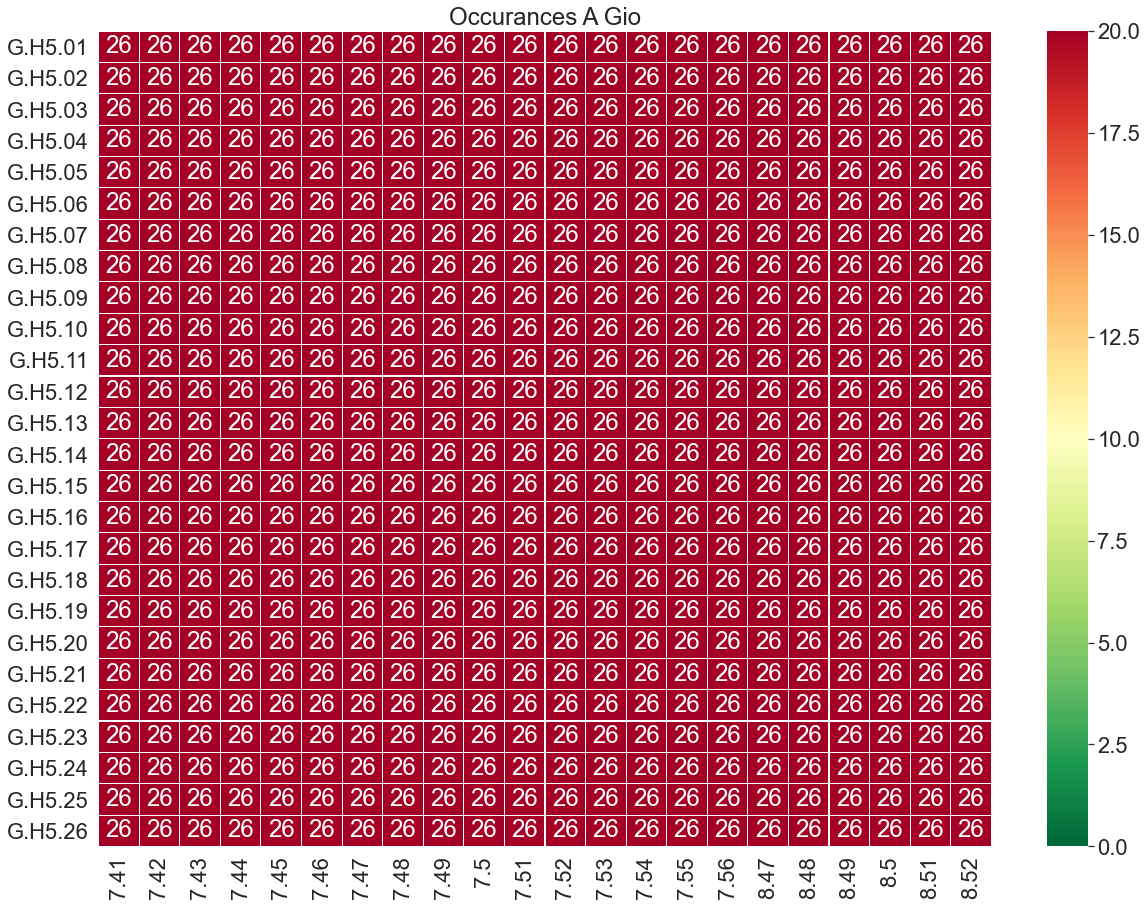

In [16]:
make_overview_plots(occ_df, title='Occurances', cl='A', gprot='Gio', save=False)

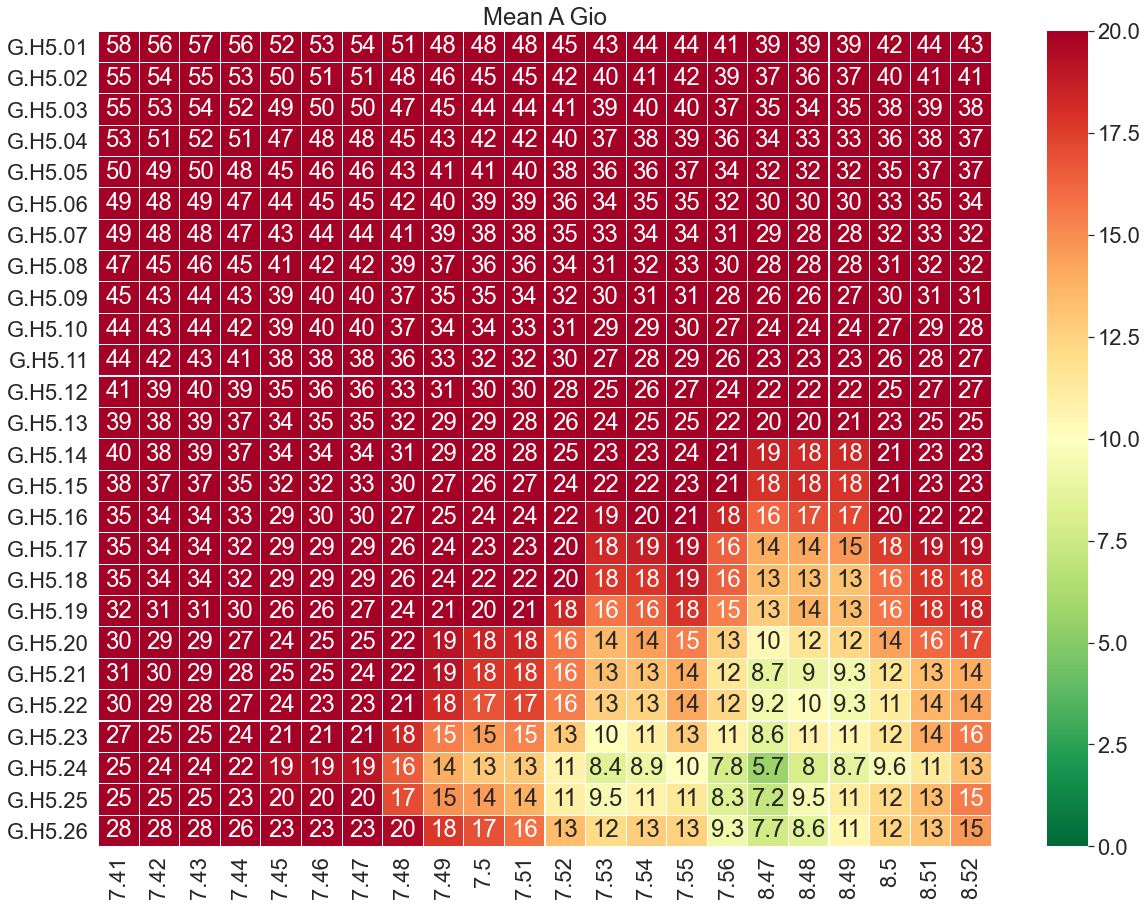

In [17]:
make_overview_plots(mean_df, title='Mean', cl='A', gprot='Gio', save=False)

In [19]:
make_overview_plots(std_df, title='Std', cl='A', gprot='Gio', save=False)

TypeError: make_overview_plots() got an unexpected keyword argument 'vmax'

In [33]:
occ_df1, mean_df1, std_df1 = make_overview_df(list_dists_df_list[0])
occ_df2, mean_df2, std_df2 = make_overview_df(list_dists_df_list[1])
diff_df = get_overview_diff(std_df1, std_df2, mean_df1, mean_df2, ab=False, cutoff_mean=12)

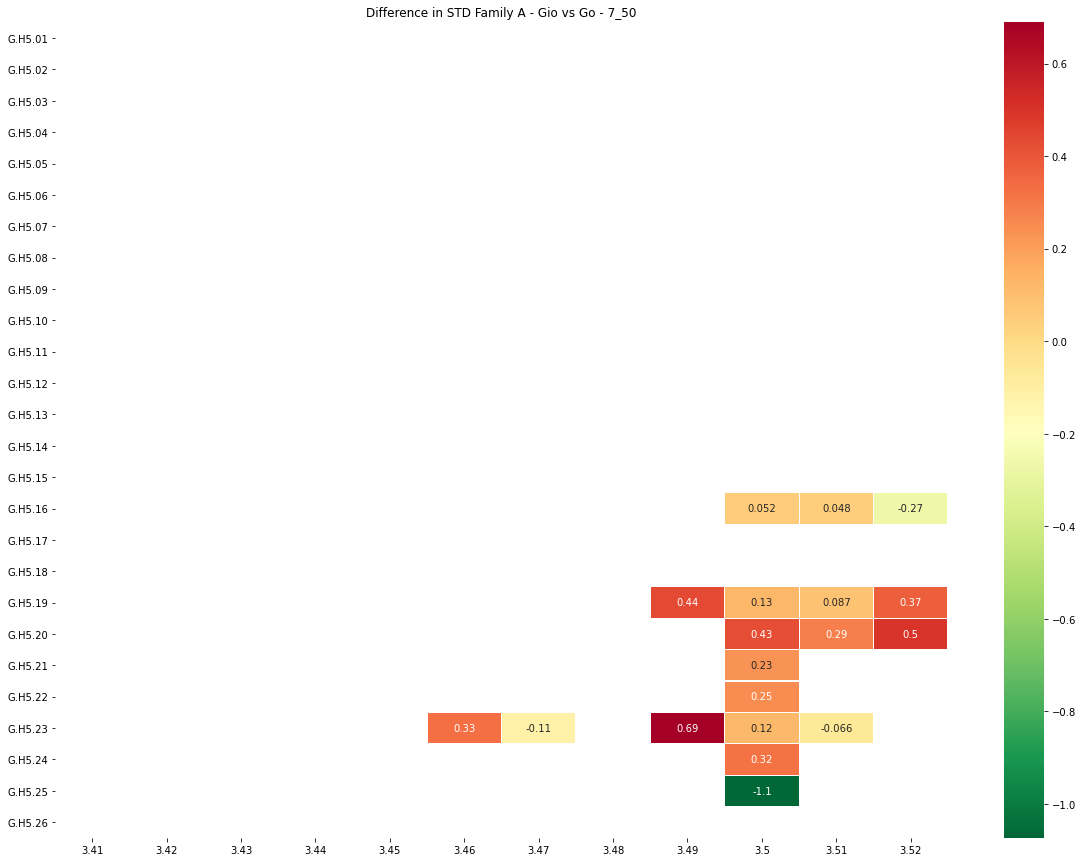

In [34]:
make_overview_plots(diff_df, title='Difference in STD', cl='Family A', gprot='- Gio vs Go - 7_50', save=True)

In [41]:
section = 'H5'
poi =  'G.H5.23', 3.5
start = 3.42
end = 3.53
l = [filtered_indices_gio, filtered_indices_gs, filtered_indices_q11]
list_poi_list, list_dists_df_list = get_interaction_tables(p, l, poi=poi, start=start, end=end, eps=.05)
occ_df1, mean_df1, std_df1 = make_overview_df(list_dists_df_list[0])
occ_df2, mean_df2, std_df2 = make_overview_df(list_dists_df_list[1])
diff_df = get_overview_diff(std_df1, std_df2, mean_df1, mean_df2, ab=False, cutoff_mean=12)

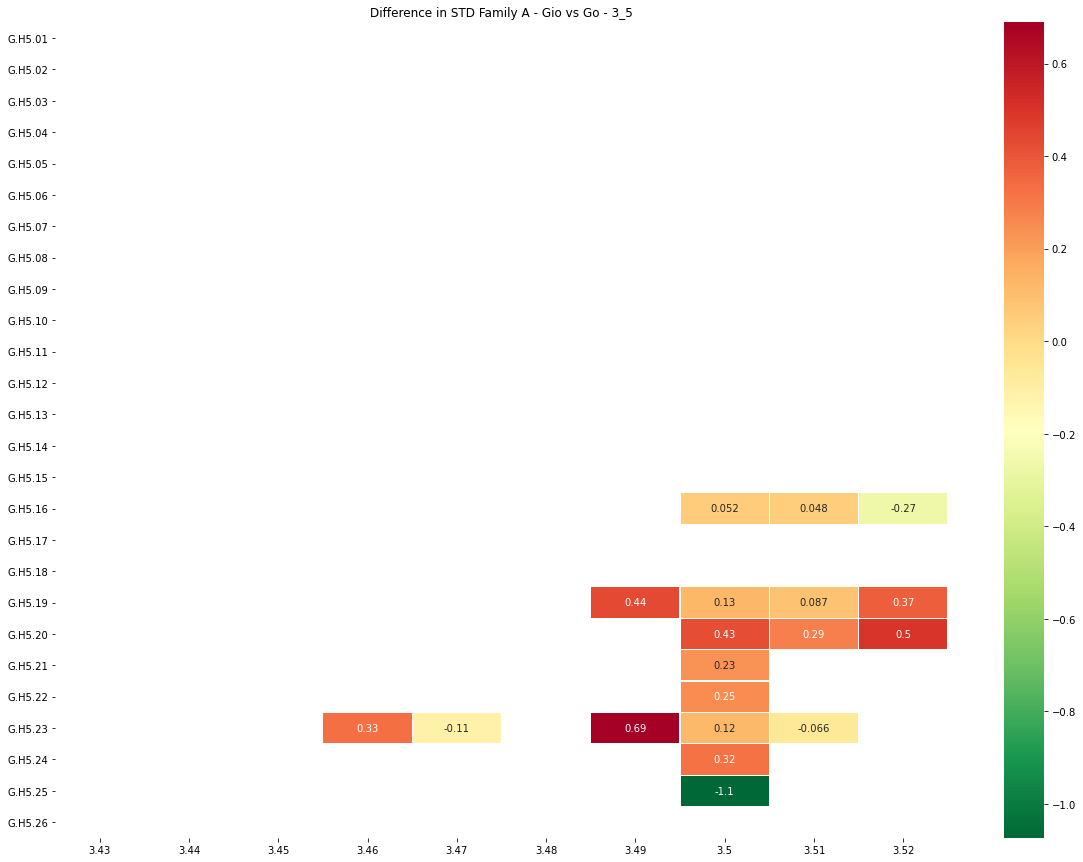

In [42]:
poi_str = list(str(poi[1]))[0] + '_' + ''.join(list(str(poi[1]))[2:])
make_overview_plots(diff_df, title='Difference in STD', cl='Family A', gprot='- Gio vs Go - ' + poi_str, save=True)

In [43]:
section = 'H5'
poi =  'G.H5.23', 7.5
start = 7.48
end = 7.56
l = [filtered_indices_gio, filtered_indices_gs, filtered_indices_q11]
list_poi_list, list_dists_df_list = get_interaction_tables(p, l, poi=poi, start=start, end=end, eps=.05)
occ_df1, mean_df1, std_df1 = make_overview_df(list_dists_df_list[0])
occ_df2, mean_df2, std_df2 = make_overview_df(list_dists_df_list[1])
diff_df = get_overview_diff(std_df1, std_df2, mean_df1, mean_df2, ab=False, cutoff_mean=16)

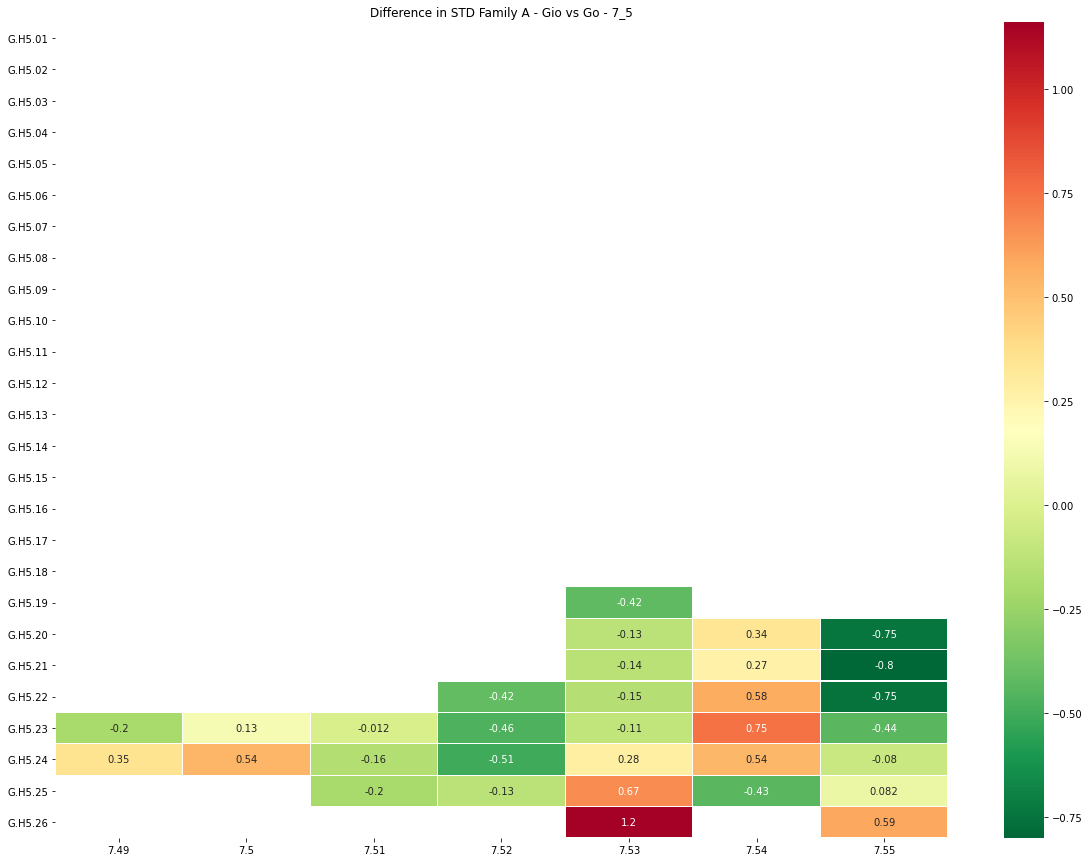

In [44]:
poi_str = list(str(poi[1]))[0] + '_' + ''.join(list(str(poi[1]))[2:])
make_overview_plots(diff_df, title='Difference in STD', cl='Family A', gprot='- Gio vs Go - ' + poi_str, save=True)

## HELICES - ANGLE ANALYSIS

To do helices analysis (both helices in the gprotein and gpcrs) we need to initialize a processor in 'rg' mode:

In [45]:
del p

In [4]:
p = CifProcessor()
p.read_pkl_metainfo()
p.read_pkl(mode='rg', folder='data/processed/')

Reading files with generic numbers on receptors and gproteins.


Filter the data...

In [5]:
f_act = p.make_filter(State='Active', Cl='Rhodopsin', gprotein=True)
f_act = f_act[f_act['Method']=='cryo-EM']
p.apply_filter(f_act)

In [6]:
len(p.dfl)

67

In [8]:
"""gs_count_df = count_g_positions(p.dfl)
cont_sec_g = find_cont_sections_g(gs_count_df, min_count=30, min_length=6)
G_SECTION_DICT = make_cont_section_dict_g(cont_sec_g)
G_SECTION_DICT['H5_1'] = (13, 23)
G_SECTION_DICT['H4_0'] = (3, 15)
R_SECTION_DICT['TM6'] = (6.35)"""

"gs_count_df = count_g_positions(p.dfl)\ncont_sec_g = find_cont_sections_g(gs_count_df, min_count=30, min_length=6)\nG_SECTION_DICT = make_cont_section_dict_g(cont_sec_g)\nG_SECTION_DICT['H5_1'] = (13, 23)\nG_SECTION_DICT['H4_0'] = (3, 15)\nR_SECTION_DICT['TM6'] = (6.35)"

In [ ]:
G_SECTION_DICT

In [ ]:
R_SECTION_DICT